In [1]:
'''Loading libraries'''
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import os 
import math

#path = "C:/Users/raoki/Documents/Project 1/"
path = 'C:/Users/raque/Google Drive/SFU/CMPT884 - Course Project and presentation'
os.chdir(path)
%matplotlib inline  

In [2]:
'''Loading Logistic Regresson Features by gene'''
#Pre-prossing on R
gsd = pd.read_table('data_gscore_features_bygene.csv', sep=';',index_col=False)
gsd.head()
print(gsd[gsd.gene=='TBL1XR1'])
print(gsd[gsd.gene=='MECOM'])


          gene  ensembl_gene_id    gene_biotype  chromosome_name      start  \
16364  TBL1XR1  ENSG00000177565  protein_coding                3  177019340   

             end   g_score    mutsig   avg_expr     sirna  
16364  177228000  0.091841 -2.581867  11.923896 -2.136782  
       gene  ensembl_gene_id    gene_biotype  chromosome_name      start  \
9516  MECOM  ENSG00000085276  protein_coding                3  169083499   

            end   g_score    mutsig  avg_expr     sirna  
9516  169663618  0.101413 -0.050593   7.68007  0.239006  


In [3]:
'''Normalization Features'''
#The bigger the value, higher the chance of being a driver gene
#print(features.head())
gsd['mutsig'] = gsd['mutsig']*(-1) 
gsd['sirna'] = gsd['sirna']*(-1)

gsd['mutsig'] = (gsd['mutsig']-gsd['mutsig'].mean())/(gsd['mutsig'].std())
gsd['avg_expr'] = (gsd['avg_expr']-gsd['avg_expr'].mean())/(gsd['avg_expr'].std())
gsd['sirna'] = (gsd['sirna']-gsd['sirna'].mean())/(gsd['sirna'].std())

In [4]:
'''Droping SiRNA and NA'''
print(gsd.shape)
gsd = gsd.dropna(axis=0,how='any')
print(gsd.shape)

(19279, 10)
(12957, 10)


In [5]:
'''Selecting top100 genes in each feature'''
#The top100 genes will be added into the final dataset, 
#even if their g-score is not very large

#mutsig
gsd = gsd.sort_values('mutsig', ascending=0)
top_genes_f = gsd['gene'].head(100)
#avg_expr
gsd = gsd.sort_values('avg_expr', ascending=0)
top_genes_f = top_genes_f.append(gsd['gene'].head(100))
#sirna
gsd = gsd.sort_values('sirna', ascending=0)
top_genes_f = top_genes_f.append(gsd['gene'].head(100))

#removing duplicated genes on the vector 
top_genes_f = top_genes_f.unique()
top_genes_f = set(top_genes_f)

'''Evaluation'''
intogen = ['ADCY1','AHNAK','AKAP9','APC','AQR','ARFGAP3','ARID1B','ATIC','ATM','ATRX','BCLAF1',
           'BCOR','BNC2','BPTF','BRAF','CASP1','CAT','CDC27','CDH1','CDKN1B','CEP290','CHD1L',
           'CHD3','CHD4','CHEK2','CNOT1','CNOT3','CNTNAP1','CTNNB1','CUL2','CUL3','EEF1B2','EGFR',
           'EIF2AK3','EIF4G1','EP300','ERCC2','FAT1','FGFR2','FIP1L1','FN1','FRG1','G3BP2','GNAS',
           'HGF','HNF1A','HRAS','HSP90AB1','HSPA8','IDH1','IRS2','KDM6A','KEAP1','MECOM','MED12',
           'MLL2','MYH10','NAP1L1','NKX3-1','NOTCH1','NOTCH2','NUP98','PCDH18','PIK3CB','PLXNA1',
           'PRPF8','PTEN','RPSAP58','SCAI','SETDB1','SMAD4','SMARCA1','SMARCB1','SPOP','SVEP1','TAOK2',
           'TBL1XR1','TBX3','THRAP3','TJP1','TJP2','TP53','TP53BP1','TRIO','WHSC1L1','WNT5A','ZFHX3','ZNF814']


census = ['ACSL3','AR','AXIN1','BRAF','CANT1','DDX5','ELK4','ERG','ETV1','ETV4','ETV5',
          'FOXA1','HERPUD1','HNRNPA2B1','KLF6','KLK2','NCOR2','NDRG1','PTEN','RAF1',
          'SALL4','SLC45A3','SPOP','TMPRSS2','ZFHX3']

evaluation = list(set(intogen) | set(census))

#forcing those genes to appear on the dataset
#top_genes_f = set.union(top_genes_f, evaluation)

'''This genes have high values from features, they should be at the data after
the filter, even if their g-score are not large'''
#Bool variable: 1 if gene is on top100 from features, 0 otherwise 
gsd['top_features'] = 0
gsd = gsd.reset_index(drop=True)

for i in np.arange(0,gsd.shape[0]):  
    if gsd.gene[i] in top_genes_f:
        gsd.loc[i,'top_features'] = 1

In [6]:
'''Defining driver genes model's seed'''
#top100 genes from g-score are used as driver genes seed
#top101-1500 genes from g-score or present in the top100 features are the passengers genes seed 
#The threhold 1500 was defined based on the paper (they mentioned 84 regions with about 14 genes each)
gsd = gsd.sort_values(by=['g_score'],axis=0,ascending=False)
gsd['top_gscore'] = 0
gsd['top_gscore'][101:1200] = 1

'''Creating data'''
#y: 1 if gene is driver, 0 otherwise 
gd = gsd[0:100]
gd['y']=1
gp = gsd.loc[((gsd.top_gscore==1) | (gsd.top_features==1))]
gp['y']=0

#new dataset deleting unimportant columns 
#some warnings, but everything is fine  
f = 4
data = pd.concat([gd,gp])
data['intercept']=1
data = data[['gene','g_score','intercept','mutsig','avg_expr','sirna','y']]
data.columns = ['gene','gscore','intercept','mutsig','avg_expr','sirna','y']

C:\Users\raque\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\raque\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\raque\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 

In [7]:
'''Checking g-score distribution of driver and passengers genes'''
print('driver genes size - seed',gd['g_score'].shape)
print('passenger genes size - seed',gp['g_score'].shape)

driver genes size - seed (100,)
passenger genes size - seed (1369,)


In [8]:
'''Metropolis-Hastings algorithm'''
#Definitions 
#theta: set of unknown paramets
#using normal distribution instead of exponential distribution

#Unknown parameters - start values
#N(mu0,var0): driver genes
#N(mu1,var1): passenger genes
theta_start1 = [0,0,0,0] #w0,w1,w2,mu0, mu1, var0, var1
theta_start2 = [0.06,0.06,0.0004,0.0008] #w0,w1,w2,mu0, mu1, var0, var1
T = np.array(data['y'])

'''Likelihood 1: P(T|w,x)~logit()'''
def likelihood1_old(param,data,T,f):
    xw = data[['intercept','mutsig','avg_expr','sirna']].dot(param)
    l1 = 1/(1+np.exp(-xw))
    l0 = 1 - l1  
    l1[T==0] = l0[T==0]
    l1 = l1+0.000001
    return np.log(l1).sum()

'''Likelihood 2: P(Gscore|T,mean,sd)~Normal(mean,sd)'''
def likelihood2_old(param,T,data,f):
    media = T
    media=[param[0] if x==0 else param[1] for x in media]
    var = T
    var = [param[2] if x==0 else param[3] for x in var]
    l2 = scipy.stats.norm(media, np.sqrt(var)).pdf(data.gscore)
    #print('\n',data.gscore.mean(),data.gscore.var(),param[4:8],l2[0:3])
    return np.log(l2).sum()



In [9]:
'''Priori: w0,w1,w2,w3, mu0,mu1, var0,va1'''
def priori1(param,f):
    w = scipy.stats.norm(0,0.25).pdf(param[0:f])
    return np.log(w).sum()

'''Priori: w0,w1,w2,w3, mu0,mu1, var0,va1'''
def priori2(param,f):
    mu0 = scipy.stats.norm(0.04,np.sqrt(0.03)).pdf(param[0])
    mu1 = scipy.stats.norm(0.07,np.sqrt(0.01)).pdf(param[1])
    return (np.log(mu1)+np.log(mu0))

In [10]:
'''Posterior'''
def posterior2(param,T,data,f,l):
    #print(np.around(likelihood2_old(param,T,data,f),2),np.around(likelihood1_old(param,data,T,f),2),
    #      np.around(priori(param,f),2),np.around(param,4))
    print(l,likelihood2_old(param,T,data,f),priori2(param,f),param)
    return (likelihood2_old(param,T,data,f)+priori2(param,f))

def posterior1(param,T,data,f,l):
    print(l,likelihood1_old(param,data,T,f),priori1(param,f))
    return (likelihood1_old(param,data,T,f)+priori1(param,f))


#Vector with proposed values 
# Values are proposed from a Normal distribution
# mean is equal to current values and variance are hyperparameters 
#theta_proposed = np.random.normal(theta_current,[0.5,0.5,0.5,0.5,0.02,0.02,0.0004,0.0004])
'''ProposalValue'''
def proposalvalues1(param):
    part1 = np.random.normal(param[0:4],[0.075,0.075,0.075,0.075])
    return(part1)

def proposalvalues2(param):
    part1 = np.random.normal(param[0:2],[0.001,0.001])
    l = np.array(param[2:4])-0.00001
    l[l<=0.000001] = 0.000001
    h = np.array(param[2:4])+0.00001
    part2 = np.random.uniform(low = l, high = h)
    return(np.concatenate([part1,part2]))


In [11]:
def T_update_old(param1,param2,f):
    print(param2,'\n')
    xw = data[['intercept','mutsig','avg_expr','sirna']].dot(param1)
    t11 = 1/(1+np.exp(-xw)) #array    
    t21 = scipy.stats.norm(param2[1], np.sqrt(param2[3])).pdf(data.gscore)

    t10 = 1-(1/(1+np.exp(-xw))) #array    
    t20 = scipy.stats.norm(param2[0], np.sqrt(param2[2])).pdf(data.gscore)
    
    t1 = t11*t21
    t0 = t10*t20
    
    prob_t1 = t1/(t1+t0)
    
    t_new = np.random.binomial(1,prob_t1,len(prob_t1))
    #print(t_new[0:10],'\n')
    return t_new


In [12]:
'''MCMC'''
def runMCMC_old(startvalue1,startvalue2,iterations,T,data,f):
    chain1 = np.zeros((iterations+1,len(startvalue1)))
    chain2 = np.zeros((iterations+1,len(startvalue2)))
    Tmatrix = np.zeros((iterations+1,len(T)))
    chain1[0]=proposalvalues1(startvalue1)
    chain2[0]=proposalvalues2(startvalue2)
    Tmatrix[0]=T
    for i in np.arange(iterations):
        print('\n',i)

        proposal1 = proposalvalues1(chain1[i,])
        prob1 = np.exp(posterior1(proposal1,T,data,f,'p')-posterior1(chain1[i,],T,data,f,'c'))
        t1 = np.all(np.random.uniform(0,1,1) < prob1)   
                
        if t1: 
            chain1[i+1] = proposal1
            T = T_update_old(chain1[i+1],chain2[i],f) 
            Tmatrix[i+1] = T
        else: 
            chain1[i+1] = chain1[i]
            Tmatrix[i+1] = Tmatrix[i]
 
        proposal2 = proposalvalues2(chain2[i,])
        prob2 = np.exp(posterior2(proposal2,T,data,f,'p')-posterior2(chain2[i,],T,data,f,'c'))
        t2 = np.all(np.random.uniform(0,1,1) < prob2)

        if t2:
            chain2[i+1] = proposal2
        else: 
            chain2[i+1] = chain2[i]
            
#        if (t1) or (t2):
#            Tmatrix[i+1] = T
#        else:
#            Tmatrix[i+1] = Tmatrix[i]
            
    return chain1,chain2, T, Tmatrix        


In [13]:
f=4
chain1,chain2, Tnew, Tmatrix = runMCMC_old(theta_start1,theta_start2,8000,T,data,f)
np.savetxt('complete_chain1_T.csv',chain1,delimiter=';')
np.savetxt('complete_chain2_T.csv',chain2,delimiter=';')
np.savetxt('complete_matrix_T.csv',Tmatrix,delimiter=';')



 0
p -963.5945184275978 1.62882419246
c -1064.3175584899734 1.76513181423
[ 0.05916407  0.06136135  0.00040764  0.0007988 ] 

p 3337.71929347 2.20774509593 [ 0.05918187  0.06093415  0.00040905  0.0007909 ]
c 3334.72858207 2.20813463959 [ 0.05916407  0.06136135  0.00040764  0.0007988 ]

 1
p -1017.0128368474625 1.79742119872
c -1018.509771822865 1.62882419246
[ 0.05918187  0.06093415  0.00040905  0.0007909 ] 

p 3365.13510433 2.20627491152 [ 0.0592189   0.05945869  0.00040886  0.00079728]
c 3354.20756124 2.20774509593 [ 0.05918187  0.06093415  0.00040905  0.0007909 ]

 2
p -1026.1243414038595 1.40497074505
c -1018.1332590310922 1.79742119872
p 3382.32661579 2.20526180696 [ 0.05817646  0.05798437  0.00041259  0.00079736]
c 3365.13510433 2.20627491152 [ 0.0592189   0.05945869  0.00040886  0.00079728]

 3
p -1024.3126989272782 1.7380902876
c -1018.1332590310922 1.79742119872
p 3388.48599772 2.20413247017 [ 0.05800908  0.05700072  0.00041654  0.0007965 ]
c 3382.32661579 2.20526180696 [ 0.0

p -827.0265114033413 -4.34448417155
c -830.1176321404731 -3.95814842924
[ 0.06130957  0.04740134  0.00036875  0.00082277] 

p 3557.9436034 2.18300862621 [ 0.06212215  0.04683889  0.00036552  0.00081481]
c 3556.82330305 2.18488370945 [ 0.06130957  0.04740134  0.00036875  0.00082277]

 36
p -816.6804606626434 -5.54559277299
c -825.8654242866637 -4.34448417155
[ 0.06212215  0.04683889  0.00036552  0.00081481] 

p 3571.0006329 2.18341963186 [ 0.06269881  0.04720523  0.00036036  0.0008166 ]
c 3571.24363727 2.18300862621 [ 0.06212215  0.04683889  0.00036552  0.00081481]

 37
p -800.2765965871287 -5.25391199706
c -798.5140116288604 -5.54559277299
[ 0.06269881  0.04720523  0.00036036  0.0008166 ] 

p 3561.12061159 2.18070075837 [ 0.06312133  0.0461772   0.00036879  0.00080839]
c 3561.23687694 2.18341963186 [ 0.06269881  0.04720523  0.00036036  0.0008166 ]

 38
p -842.0239312320078 -4.49048584766
c -838.0246211147046 -5.25391199706
[ 0.06312133  0.0461772   0.00036879  0.00080839] 

p 3563.4075

c -729.2754040687147 -13.2144030619
p 3625.94812097 2.17577645665 [ 0.06063358  0.04349914  0.00030233  0.00079503]
c 3625.49258144 2.17432241344 [ 0.06092337  0.04303035  0.00031003  0.00078763]

 68
p -731.069468677716 -13.2729791083
c -729.2754040687147 -13.2144030619
p 3620.76474968 2.17846039401 [ 0.05971782  0.04429136  0.00030268  0.00079372]
c 3625.94812097 2.17577645665 [ 0.06063358  0.04349914  0.00030233  0.00079503]

 69
p -721.7595418531504 -16.9532512529
c -729.2754040687147 -13.2144030619
[ 0.06063358  0.04349914  0.00030233  0.00079503] 

p 3625.59306893 2.17909732684 [ 0.06108268  0.04490751  0.00030933  0.00080305]
c 3628.80134582 2.17577645665 [ 0.06063358  0.04349914  0.00030233  0.00079503]

 70
p -702.1386499516093 -16.025844853
c -699.4654456397578 -16.9532512529
p 3622.28562742 2.17764032447 [ 0.05971812  0.0439744   0.00031255  0.00080521]
c 3625.59306893 2.17909732684 [ 0.06108268  0.04490751  0.00030933  0.00080305]

 71
p -701.049791646822 -20.6649140249
c -

c 3655.39341945 2.15798278894 [ 0.06162007  0.03768476  0.00028657  0.00083789]

 102
p -625.1072394800541 -19.4345127555
c -616.3172645678259 -22.2251872746
p 3655.58696684 2.1631394221 [ 0.06054209  0.03907603  0.00027772  0.00083357]
c 3655.72529982 2.16204481683 [ 0.06081467  0.0387842   0.00028695  0.0008364 ]

 103
p -607.8117052927638 -28.1328551203
c -616.3172645678259 -22.2251872746
[ 0.06054209  0.03907603  0.00027772  0.00083357] 

p 3685.1567033 2.15598179312 [ 0.06147641  0.03704005  0.00028416  0.0008343 ]
c 3683.79362454 2.1631394221 [ 0.06054209  0.03907603  0.00027772  0.00083357]

 104
p -618.5718843016269 -30.2197429911
c -621.2747390335736 -28.1328551203
[ 0.06147641  0.03704005  0.00028416  0.0008343 ] 

p 3690.72650077 2.1568821491 [ 0.06142615  0.03730336  0.00027706  0.00083165]
c 3690.54971964 2.15598179312 [ 0.06147641  0.03704005  0.00028416  0.0008343 ]

 105
p -608.2202540214437 -29.1993663618
c -605.2631905441636 -30.2197429911
p 3690.74848499 2.1544531106

c 3713.64281655 2.14536107653 [ 0.06219196  0.03410631  0.00028078  0.00083095]

 136
p -614.1168260440835 -25.2588414377
c -601.553431295741 -30.1662969656
p 3707.28923535 2.14820434993 [ 0.06031415  0.03453033  0.00027847  0.00083903]
c 3713.113379 2.14751262436 [ 0.06198022  0.03466668  0.00028345  0.00083994]

 137
p -604.9494158409751 -31.3781912548
c -601.553431295741 -30.1662969656
p 3712.09736458 2.15097787828 [ 0.06252402  0.03577908  0.00028606  0.00084849]
c 3713.113379 2.14751262436 [ 0.06198022  0.03466668  0.00028345  0.00083994]

 138
p -599.3208799838864 -31.4975845759
c -601.553431295741 -30.1662969656
[ 0.06198022  0.03466668  0.00028345  0.00083994] 

p 3712.48574886 2.15137306123 [ 0.0597859   0.03533324  0.00028813  0.00083202]
c 3721.0643173 2.14751262436 [ 0.06198022  0.03466668  0.00028345  0.00083994]

 139
p -588.8626079616848 -35.4399080384
c -587.2782966070655 -31.4975845759
p 3715.62659443 2.14518999974 [ 0.06348032  0.03433259  0.00029215  0.00084165]
c 37

c 3716.91469432 2.14254114629 [ 0.06194032  0.03327865  0.00026106  0.00086836]

 169
p -517.5732369770761 -46.1678189471
c -516.4249705832867 -43.3730287929
p 3717.27812613 2.14578417956 [ 0.06166798  0.03411748  0.00026897  0.00087011]
c 3716.20351737 2.14926973878 [ 0.06168568  0.03510604  0.00026325  0.00087418]

 170
p -516.211390649521 -44.6424571949
c -516.4249705832867 -43.3730287929
[ 0.06166798  0.03411748  0.00026897  0.00087011] 

p 3731.03254705 2.15024236414 [ 0.06110927  0.03526733  0.00025904  0.00087401]
c 3732.99936963 2.14578417956 [ 0.06166798  0.03411748  0.00026897  0.00087011]

 171
p -517.8437407908258 -42.912116966
c -514.3659061642375 -44.6424571949
p 3731.45545106 2.15073313677 [ 0.06167563  0.03552587  0.00027717  0.00086949]
c 3732.99936963 2.14578417956 [ 0.06166798  0.03411748  0.00026897  0.00087011]

 172
p -511.7521570036575 -46.2722123522
c -514.3659061642375 -44.6424571949
[ 0.06166798  0.03411748  0.00026897  0.00087011] 

p 3729.97194915 2.14604483

c -501.1066846067526 -48.7870825766
p 3715.95976966 2.14750780987 [ 0.06301847  0.03488637  0.00025245  0.00086709]
c 3722.99398025 2.14526311956 [ 0.06148321  0.03393569  0.000262    0.00085884]

 202
p -505.05261993943213 -51.2553471113
c -501.1066846067526 -48.7870825766
p 3722.47347003 2.1455424891 [ 0.06156596  0.03402974  0.00025321  0.00086877]
c 3722.99398025 2.14526311956 [ 0.06148321  0.03393569  0.000262    0.00085884]

 203
p -499.14043575051903 -54.5506620442
c -501.1066846067526 -48.7870825766
p 3721.64295536 2.14446692945 [ 0.06041615  0.03351081  0.00026184  0.00086575]
c 3722.99398025 2.14526311956 [ 0.06148321  0.03393569  0.000262    0.00085884]

 204
p -499.5150137051059 -49.2369480901
c -501.1066846067526 -48.7870825766
[ 0.06148321  0.03393569  0.000262    0.00085884] 

p 3735.69432168 2.15330802043 [ 0.06108493  0.03615642  0.00026602  0.00085691]
c 3739.15423942 2.14526311956 [ 0.06148321  0.03393569  0.000262    0.00085884]

 205
p -499.0084852942002 -53.583863

c 3733.94618756 2.13599651328 [ 0.06277273  0.0316993   0.00026788  0.00085952]

 237
p -517.1910968502863 -43.1798578423
c -515.2416067976803 -41.9794673236
p 3735.95364598 2.1395637682 [ 0.06164948  0.03242034  0.00026397  0.00085311]
c 3733.94618756 2.13599651328 [ 0.06277273  0.0316993   0.00026788  0.00085952]

 238
p -517.7236278557067 -41.0693320231
c -515.2416067976803 -41.9794673236
[ 0.06164948  0.03242034  0.00026397  0.00085311] 

p 3725.97310417 2.14525302932 [ 0.06070334  0.03378118  0.00025793  0.00085317]
c 3730.74731627 2.1395637682 [ 0.06164948  0.03242034  0.00026397  0.00085311]

 239
p -527.3759517156585 -42.7901087366
c -526.3247633497747 -41.0693320231
p 3730.58983535 2.13623295311 [ 0.06125729  0.03147136  0.00027052  0.00084868]
c 3730.74731627 2.1395637682 [ 0.06164948  0.03242034  0.00026397  0.00085311]

 240
p -525.2580819058802 -43.1238314114
c -526.3247633497747 -41.0693320231
p 3731.77513063 2.13631148533 [ 0.06208436  0.03164721  0.00027996  0.00085145]

[ 0.06206903  0.0310202   0.00027904  0.00081791] 

p 3754.18453414 2.13292696582 [ 0.06074796  0.0305322   0.00027343  0.00082506]
c 3757.64894565 2.13389835439 [ 0.06206903  0.0310202   0.00027904  0.00081791]

 273
p -547.8337846501275 -36.4807704497
c -540.358969660219 -37.423494384
p 3757.54137016 2.13279723079 [ 0.06242006  0.03080508  0.00027198  0.00082714]
c 3757.64894565 2.13389835439 [ 0.06206903  0.0310202   0.00027904  0.00081791]

 274
p -543.8616793793921 -34.6560008481
c -540.358969660219 -37.423494384
[ 0.06206903  0.0310202   0.00027904  0.00081791] 

p 3741.98900095 2.13532644793 [ 0.06261432  0.03149362  0.00028796  0.00082569]
c 3743.09679698 2.13389835439 [ 0.06206903  0.0310202   0.00027904  0.00081791]

 275
p -565.8209016101902 -37.3016138722
c -558.2539796354896 -34.6560008481
p 3742.39749715 2.14034349832 [ 0.06214001  0.03272432  0.00028469  0.00082007]
c 3741.98900095 2.13532644793 [ 0.06261432  0.03149362  0.00028796  0.00082569]

 276
p -564.1286504232231

c 3709.00424371 2.14208338404 [ 0.06239456  0.03324541  0.00025955  0.0007646 ]

 309
p -532.9103524918605 -40.4780692799
c -527.8664063005991 -43.8981579435
p 3711.49843578 2.14178158728 [ 0.06131612  0.03295073  0.00027451  0.00075475]
c 3711.31455716 2.14326753302 [ 0.06149568  0.03338897  0.00026838  0.00075937]

 310
p -525.1110673898061 -49.2611395283
c -527.8664063005991 -43.8981579435
p 3709.59179762 2.13955138353 [ 0.06062701  0.03222584  0.00027605  0.0007456 ]
c 3711.49843578 2.14178158728 [ 0.06131612  0.03295073  0.00027451  0.00075475]

 311
p -525.2431308107157 -47.2692548114
c -527.8664063005991 -43.8981579435
p 3709.56158303 2.13711538852 [ 0.06078379  0.03161455  0.00028538  0.00074283]
c 3709.59179762 2.13955138353 [ 0.06062701  0.03222584  0.00027605  0.0007456 ]

 312
p -534.8036874188125 -42.5433158419
c -527.8664063005991 -43.8981579435
p 3709.25696469 2.13396893307 [ 0.06152489  0.03093697  0.00029527  0.00073989]
c 3709.56158303 2.13711538852 [ 0.06078379  0.03

c -525.1344634478853 -44.6873584053
p 3756.77424534 2.12675093999 [ 0.06261131  0.02932695  0.00026977  0.00073213]
c 3757.14419116 2.13329781331 [ 0.06234955  0.03091954  0.00027181  0.00073245]

 343
p -528.2378894489848 -46.9188395746
c -525.1344634478853 -44.6873584053
p 3753.29146564 2.13274518689 [ 0.06342617  0.03098837  0.00027732  0.00073724]
c 3757.14419116 2.13329781331 [ 0.06234955  0.03091954  0.00027181  0.00073245]

 344
p -523.7283444559686 -47.2439603855
c -525.1344634478853 -44.6873584053
p 3738.76137533 2.13067266756 [ 0.065067    0.03079752  0.00027395  0.00073356]
c 3757.14419116 2.13329781331 [ 0.06234955  0.03091954  0.00027181  0.00073245]

 345
p -534.2332512412253 -39.6608604926
c -525.1344634478853 -44.6873584053
p 3753.77070022 2.12938177188 [ 0.06073719  0.0296421   0.000263    0.00073762]
c 3757.14419116 2.13329781331 [ 0.06234955  0.03091954  0.00027181  0.00073245]

 346
p -526.6310686063545 -44.5684522326
c -525.1344634478853 -44.6873584053
p 3752.26726

c 3763.78602891 2.12530443208 [ 0.06222888  0.02890325  0.00029141  0.00073478]

 378
p -457.6667128466514 -62.0726104243
c -460.0382042802786 -58.0750782588
p 3757.57636013 2.12749529773 [ 0.06360644  0.02970014  0.00029315  0.00073292]
c 3763.78602891 2.12530443208 [ 0.06222888  0.02890325  0.00029141  0.00073478]

 379
p -462.3802812014594 -61.2419968326
c -460.0382042802786 -58.0750782588
p 3764.01715905 2.12025143228 [ 0.06171946  0.02760347  0.00029376  0.00073061]
c 3763.78602891 2.12530443208 [ 0.06222888  0.02890325  0.00029141  0.00073478]

 380
p -464.4026395434316 -55.4332875189
c -460.0382042802786 -58.0750782588
[ 0.06171946  0.02760347  0.00029376  0.00073061] 

p 3750.69072888 2.12035216241 [ 0.06176868  0.02763565  0.0003014   0.00073142]
c 3751.60675994 2.12025143228 [ 0.06171946  0.02760347  0.00029376  0.00073061]

 381
p -518.4675675306486 -57.5794939063
c -517.1838436890434 -55.4332875189
p 3746.98011258 2.11960444576 [ 0.06043024  0.02723881  0.00030371  0.000732

p 3775.73250071 2.11794659498 [ 0.06117889  0.02697335  0.00028152  0.00072386]
c 3776.65778073 2.12041151446 [ 0.0612994   0.0275702   0.00028217  0.0007152 ]

 413
p -492.85592527993515 -45.3926965851
c -490.4827934608967 -45.5841800835
p 3776.4923177 2.11443358686 [ 0.06144707  0.02620797  0.00029086  0.00072049]
c 3775.73250071 2.11794659498 [ 0.06117889  0.02697335  0.00028152  0.00072386]

 414
p -491.46752218329647 -46.1777911604
c -490.4827934608967 -45.5841800835
p 3777.98037567 2.1174532928 [ 0.06198434  0.02699337  0.00028393  0.00071178]
c 3776.4923177 2.11443358686 [ 0.06144707  0.02620797  0.00029086  0.00072049]

 415
p -495.3326954106647 -45.0086199954
c -490.4827934608967 -45.5841800835
p 3773.22017274 2.11906797916 [ 0.06045323  0.02711719  0.00028309  0.0007087 ]
c 3777.98037567 2.1174532928 [ 0.06198434  0.02699337  0.00028393  0.00071178]

 416
p -489.63163307455835 -48.8015274857
c -490.4827934608967 -45.5841800835
p 3776.9974527 2.12790214955 [ 0.06232375  0.0295

 450
p -471.8120662416416 -48.6636402377
c -472.1102421396267 -47.0781798761
[ 0.06164629  0.02593413  0.00028747  0.00069325] 

p 3810.91265108 2.11309850286 [ 0.06229939  0.0260453   0.00029594  0.00068456]
c 3810.29083866 2.11308757573 [ 0.06164629  0.02593413  0.00028747  0.00069325]

 451
p -482.71274848826005 -52.9953730984
c -480.9247470182307 -48.6636402377
p 3809.52675501 2.11777805147 [ 0.0614289   0.02697544  0.00028746  0.00068503]
c 3810.91265108 2.11309850286 [ 0.06229939  0.0260453   0.00029594  0.00068456]

 452
p -487.3365262457759 -47.1070224239
c -480.9247470182307 -48.6636402377
p 3810.12691187 2.11781534141 [ 0.06180527  0.0270472   0.00028597  0.0006862 ]
c 3809.52675501 2.11777805147 [ 0.0614289   0.02697544  0.00028746  0.00068503]

 453
p -488.118603278269 -49.5532601223
c -480.9247470182307 -48.6636402377
p 3807.33697993 2.12053905417 [ 0.06122508  0.02758785  0.00029225  0.00069341]
c 3810.12691187 2.11781534141 [ 0.06180527  0.0270472   0.00028597  0.0006862

c -500.9003661923944 -41.4065288937
p 3776.91932649 2.11373725425 [ 0.06137089  0.02603688  0.00029008  0.00065866]
c 3776.89875326 2.11588248374 [ 0.06284179  0.02677762  0.00028445  0.00065888]

 484
p -505.91757499450983 -43.4056909277
c -500.9003661923944 -41.4065288937
p 3773.40286669 2.10892011655 [ 0.06343722  0.02529837  0.00028599  0.00066007]
c 3776.91932649 2.11373725425 [ 0.06137089  0.02603688  0.00029008  0.00065866]

 485
p -505.4735229050411 -40.5109505495
c -500.9003661923944 -41.4065288937
p 3774.30998836 2.11850224843 [ 0.0606928   0.02702368  0.00029617  0.00066535]
c 3776.91932649 2.11373725425 [ 0.06137089  0.02603688  0.00029008  0.00065866]

 486
p -500.0988285856992 -43.6800291774
c -500.9003661923944 -41.4065288937
[ 0.06137089  0.02603688  0.00029008  0.00065866] 

p 3795.15536248 2.11506470066 [ 0.06148845  0.02635911  0.00029763  0.0006648 ]
c 3795.53158527 2.11373725425 [ 0.06137089  0.02603688  0.00029008  0.00065866]

 487
p -518.822031009149 -39.2994375

p 3798.80595103 2.10420574415 [ 0.06330266  0.02423298  0.00029068  0.00058922]
c 3802.33596086 2.11041221551 [ 0.06122234  0.02526337  0.00028253  0.00059606]

 518
p -482.84746641588316 -43.5174224802
c -476.35958907095505 -44.8554933972
p 3793.89118067 2.10870934888 [ 0.06408051  0.02536524  0.00029831  0.0005823 ]
c 3798.80595103 2.10420574415 [ 0.06330266  0.02423298  0.00029068  0.00058922]

 519
p -475.10866598104843 -47.4890837273
c -476.35958907095505 -44.8554933972
p 3799.39502439 2.10586598945 [ 0.06066766  0.02417385  0.00028903  0.00059139]
c 3798.80595103 2.10420574415 [ 0.06330266  0.02423298  0.00029068  0.00058922]

 520
p -485.2562369437238 -42.8796861952
c -476.35958907095505 -44.8554933972
p 3798.04199399 2.10240360814 [ 0.06059167  0.02341322  0.00028907  0.00059402]
c 3799.39502439 2.10586598945 [ 0.06066766  0.02417385  0.00028903  0.00059139]

 521
p -479.88277704751243 -43.9235794327
c -476.35958907095505 -44.8554933972
p 3799.27723006 2.10766544586 [ 0.0605331

c -514.4794799223722 -43.8565225295
p 3795.52720106 2.119888861 [ 0.06187691  0.02754497  0.00030805  0.00057002]
c 3796.92069586 2.11808252571 [ 0.06242184  0.02721555  0.00030305  0.0005617 ]

 553
p -521.7836557913367 -43.2824686934
c -514.4794799223722 -43.8565225295
p 3797.46699648 2.11676238974 [ 0.06240901  0.02690587  0.00029713  0.00055739]
c 3796.92069586 2.11808252571 [ 0.06242184  0.02721555  0.00030305  0.0005617 ]

 554
p -538.4144769495628 -37.2507476586
c -514.4794799223722 -43.8565225295
p 3796.72268165 2.11733133197 [ 0.06249922  0.02705382  0.00030348  0.00056575]
c 3797.46699648 2.11676238974 [ 0.06240901  0.02690587  0.00029713  0.00055739]

 555
p -516.4349274934445 -44.5263775592
c -514.4794799223722 -43.8565225295
p 3791.63440077 2.1176244222 [ 0.06398743  0.02739188  0.00030058  0.00056709]
c 3796.72268165 2.11733133197 [ 0.06249922  0.02705382  0.00030348  0.00056575]

 556
p -514.431718913815 -43.6712042365
c -514.4794799223722 -43.8565225295
[ 0.06249922  0.

c -476.91906396020846 -35.6814155841
p 3822.95191032 2.10993605374 [ 0.05966076  0.0249204   0.00030556  0.00057881]
c 3833.93693877 2.10255645339 [ 0.06185688  0.02363871  0.00030154  0.00057629]

 589
p -485.48360913946067 -36.7177975982
c -476.91906396020846 -35.6814155841
p 3829.97096484 2.10343167085 [ 0.0630611   0.02402354  0.00030992  0.00057618]
c 3833.93693877 2.10255645339 [ 0.06185688  0.02363871  0.00030154  0.00057629]

 590
p -475.45806233587473 -38.7187409283
c -476.91906396020846 -35.6814155841
p 3827.30907462 2.09861289102 [ 0.06371363  0.02309546  0.00030116  0.0005779 ]
c 3833.93693877 2.10255645339 [ 0.06185688  0.02363871  0.00030154  0.00057629]

 591
p -478.50860656246067 -35.7676006938
c -476.91906396020846 -35.6814155841
p 3832.1848107 2.10956528706 [ 0.06181713  0.02516953  0.0003055   0.000567  ]
c 3833.93693877 2.10255645339 [ 0.06185688  0.02363871  0.00030154  0.00057629]

 592
p -474.54471758345625 -37.0286985819
c -476.91906396020846 -35.6814155841
[ 0.

c -541.3594231375652 -36.1512994039
p 3843.31814097 2.09558988851 [ 0.06268029  0.02228756  0.00029021  0.00048833]
c 3841.10345955 2.0891544151 [ 0.06288468  0.02098896  0.00028917  0.00048842]

 623
p -539.9243736649945 -39.5500916006
c -541.3594231375652 -36.1512994039
p 3838.37021369 2.09393115753 [ 0.06396785  0.02214992  0.00028661  0.00048762]
c 3843.31814097 2.09558988851 [ 0.06268029  0.02228756  0.00029021  0.00048833]

 624
p -546.2937273655558 -35.5580065933
c -541.3594231375652 -36.1512994039
p 3844.75807119 2.10322769531 [ 0.06247769  0.02388308  0.00028553  0.00047898]
c 3843.31814097 2.09558988851 [ 0.06268029  0.02228756  0.00029021  0.00048833]

 625
p -538.4896881249998 -40.2112782426
c -541.3594231375652 -36.1512994039
p 3843.51681126 2.10637235207 [ 0.06167792  0.02444072  0.00028163  0.00047962]
c 3844.75807119 2.10322769531 [ 0.06247769  0.02388308  0.00028553  0.00047898]

 626
p -548.1868113097177 -31.8451260753
c -541.3594231375652 -36.1512994039
p 3843.405628

c -494.4070451677328 -35.74272832
[ 0.06176524  0.02327217  0.00028635  0.00047915] 

p 3834.13191143 2.10636048528 [ 0.0599595   0.02417712  0.00028173  0.0004739 ]
c 3845.35907806 2.10091702712 [ 0.06176524  0.02327217  0.00028635  0.00047915]

 658
p -505.9655011327359 -34.6930359543
c -499.3583322699953 -37.9119064255
p 3838.20547233 2.10141668768 [ 0.06048844  0.02318675  0.00029116  0.00048383]
c 3845.35907806 2.10091702712 [ 0.06176524  0.02327217  0.00028635  0.00047915]

 659
p -506.11819983886113 -38.9982477012
c -499.3583322699953 -37.9119064255
p 3825.75025662 2.10591760961 [ 0.05918189  0.02397024  0.0002935   0.00047484]
c 3845.35907806 2.10091702712 [ 0.06176524  0.02327217  0.00028635  0.00047915]

 660
p -496.99973072027876 -41.0242614331
c -499.3583322699953 -37.9119064255
p 3845.93943672 2.09677621573 [ 0.06234085  0.02248322  0.00028078  0.00047252]
c 3845.35907806 2.10091702712 [ 0.06176524  0.02327217  0.00028635  0.00047915]

 661
p -497.9780313918292 -41.4197814

p 3857.19159458 2.09518668614 [ 0.06086459  0.02192823  0.00028135  0.00046935]
c 3859.69899062 2.10383109104 [ 0.06170143  0.02388998  0.00028318  0.00046105]

 691
p -459.75411420749356 -52.9995530527
c -460.7473592625506 -48.8902285544
p 3844.49354838 2.11550133622 [ 0.05989623  0.02620777  0.00027809  0.00046246]
c 3859.69899062 2.10383109104 [ 0.06170143  0.02388998  0.00028318  0.00046105]

 692
p -458.7630915064588 -51.133251615
c -460.7473592625506 -48.8902285544
[ 0.06170143  0.02388998  0.00028318  0.00046105] 

p 3855.64267028 2.10333828102 [ 0.06153571  0.0237574   0.00028837  0.00045552]
c 3855.76669447 2.10383109104 [ 0.06170143  0.02388998  0.00028318  0.00046105]

 693
p -502.0144858424732 -48.8812345564
c -488.59327060892366 -51.133251615
p 3853.37483349 2.09973338647 [ 0.06107998  0.0229155   0.00028624  0.00045649]
c 3855.64267028 2.10333828102 [ 0.06153571  0.0237574   0.00028837  0.00045552]

 694
p -487.7752698141117 -50.1560845892
c -488.59327060892366 -51.133251

c 3879.10603488 2.10433588484 [ 0.06257212  0.02413947  0.00027783  0.00045748]

 726
p -459.294041490208 -49.5704843563
c -455.61354809767647 -52.1708286239
p 3874.2336547 2.11243108518 [ 0.06267872  0.02595824  0.0002841   0.00045836]
c 3879.10603488 2.10433588484 [ 0.06257212  0.02413947  0.00027783  0.00045748]

 727
p -464.5532936572116 -45.5107982087
c -455.61354809767647 -52.1708286239
p 3876.29622634 2.1086275441 [ 0.06158772  0.024924    0.00028088  0.00045968]
c 3879.10603488 2.10433588484 [ 0.06257212  0.02413947  0.00027783  0.00045748]

 728
p -471.17730180133475 -45.3507521753
c -455.61354809767647 -52.1708286239
p 3875.61957963 2.11183701913 [ 0.06237383  0.02577177  0.00027614  0.00044946]
c 3879.10603488 2.10433588484 [ 0.06257212  0.02413947  0.00027783  0.00045748]

 729
p -458.26820332622344 -50.2252767973
c -455.61354809767647 -52.1708286239
[ 0.06257212  0.02413947  0.00027783  0.00045748] 

p 3861.65162595 2.11117003979 [ 0.06171205  0.02551179  0.00027621  0.000

p -427.7101435873263 -55.203469468
c -420.66725758275857 -56.5810911068
p 3875.297713 2.08843512241 [ 0.06168131  0.02066093  0.00028196  0.00042357]
c 3875.20673379 2.08309074491 [ 0.06178185  0.01960382  0.00028705  0.00042923]

 763
p -430.90849203983703 -58.3358860283
c -420.66725758275857 -56.5810911068
p 3874.15740585 2.09319363074 [ 0.06119769  0.02156359  0.00027951  0.00041613]
c 3875.297713 2.08843512241 [ 0.06168131  0.02066093  0.00028196  0.00042357]

 764
p -424.15258474191467 -53.1783581969
c -420.66725758275857 -56.5810911068
[ 0.06168131  0.02066093  0.00028196  0.00042357] 

p 3867.93846171 2.08925353408 [ 0.06055449  0.02066604  0.00028397  0.00041651]
c 3871.97900583 2.08843512241 [ 0.06168131  0.02066093  0.00028196  0.00042357]

 765
p -452.1882621286562 -55.9663156407
c -447.10458547257406 -53.1783581969
p 3856.65053021 2.09037658735 [ 0.05945383  0.02074498  0.00027355  0.00042079]
c 3871.97900583 2.08843512241 [ 0.06168131  0.02066093  0.00028196  0.00042357]



c -428.2462196273248 -57.9967069185
p 3897.76520581 2.07624037465 [ 0.06215117  0.01831466  0.00028452  0.00041106]
c 3897.97656497 2.08144197321 [ 0.06239179  0.01936632  0.00027929  0.00041171]

 796
p -431.6508271042436 -61.4188863135
c -428.2462196273248 -57.9967069185
p 3898.4468642 2.07965593853 [ 0.06203528  0.01896306  0.00027665  0.00040628]
c 3897.76520581 2.07624037465 [ 0.06215117  0.01831466  0.00028452  0.00041106]

 797
p -441.32571817551377 -59.1892164499
c -428.2462196273248 -57.9967069185
p 3897.50080096 2.0806716841 [ 0.06265125  0.01925279  0.00027657  0.00040989]
c 3898.4468642 2.07965593853 [ 0.06203528  0.01896306  0.00027665  0.00040628]

 798
p -432.92863634190667 -54.5095823607
c -428.2462196273248 -57.9967069185
p 3894.59490407 2.07423226158 [ 0.06291715  0.0180382   0.00027122  0.00041575]
c 3897.50080096 2.0806716841 [ 0.06265125  0.01925279  0.00027657  0.00040989]

 799
p -435.67871648103335 -53.6738286466
c -428.2462196273248 -57.9967069185
p 3896.979889

p -427.86772077829204 -60.9850396741
c -427.8464127628697 -60.2689785864
[ 0.06140638  0.01994555  0.00028932  0.00036688] 

p 3896.13465806 2.08361515821 [ 0.06284367  0.01986526  0.00028245  0.00035992]
c 3896.42824586 2.08507735661 [ 0.06140638  0.01994555  0.00028932  0.00036688]

 830
p -421.9642713009669 -61.995082831
c -418.74990299880227 -60.9850396741
p 3892.30190223 2.08906608326 [ 0.06066963  0.02064408  0.00027942  0.00037012]
c 3896.42824586 2.08507735661 [ 0.06140638  0.01994555  0.00028932  0.00036688]

 831
p -423.4179645818813 -57.2715314393
c -418.74990299880227 -60.9850396741
p 3896.11533983 2.07983172753 [ 0.06246365  0.01905984  0.00029061  0.00037261]
c 3896.42824586 2.08507735661 [ 0.06140638  0.01994555  0.00028932  0.00036688]

 832
p -420.5724024530857 -62.5383576066
c -418.74990299880227 -60.9850396741
p 3893.99060635 2.0801915913 [ 0.06318947  0.01923922  0.00028223  0.00036717]
c 3896.11533983 2.07983172753 [ 0.06246365  0.01905984  0.00029061  0.00037261]


c 3913.26111091 2.08293217142 [ 0.06128099  0.01950113  0.0002813   0.00033686]

 863
p -437.2047666697264 -59.352966309
c -434.1069863772735 -59.219180705
p 3907.62542114 2.08602170597 [ 0.06022968  0.01997109  0.00028238  0.0003345 ]
c 3913.26111091 2.08293217142 [ 0.06128099  0.01950113  0.0002813   0.00033686]

 864
p -431.78770064572865 -61.4653251267
c -434.1069863772735 -59.219180705
[ 0.06128099  0.01950113  0.0002813   0.00033686] 

p 3902.75042442 2.08234617714 [ 0.06114699  0.0193665   0.00027599  0.00033934]
c 3903.79501472 2.08293217142 [ 0.06128099  0.01950113  0.0002813   0.00033686]

 865
p -416.44582741469424 -58.1653197157
c -411.8448822492105 -61.4653251267
[ 0.06128099  0.01950113  0.0002813   0.00033686] 

p 3922.1863752 2.08198481396 [ 0.06100129  0.019275    0.00028615  0.00034557]
c 3923.83164198 2.08293217142 [ 0.06128099  0.01950113  0.0002813   0.00033686]

 866
p -416.3070970896385 -57.7155114376
c -412.19667337459026 -58.1653197157
p 3923.37667046 2.0840792

p 3921.44567026 2.08042310563 [ 0.06239674  0.01916622  0.00029045  0.00033155]
c 3919.26468483 2.0916228684 [ 0.06212765  0.02137829  0.00029378  0.00033483]

 900
p -441.19777763041395 -46.6647792669
c -441.40452688725765 -45.6742681417
[ 0.06239674  0.01916622  0.00029045  0.00033155] 

p 3905.08620815 2.08070225486 [ 0.06184063  0.01914049  0.00028221  0.00032769]
c 3904.83829908 2.08042310563 [ 0.06239674  0.01916622  0.00029045  0.00033155]

 901
p -448.95237475039863 -48.4986539241
c -449.10745601139183 -46.6647792669
p 3902.86989628 2.07913595175 [ 0.06098706  0.01871451  0.00028478  0.0003257 ]
c 3905.08620815 2.08070225486 [ 0.06184063  0.01914049  0.00028221  0.00032769]

 902
p -459.63577071307094 -47.4870236701
c -449.10745601139183 -46.6647792669
p 3903.74230742 2.07449189506 [ 0.06264425  0.01804828  0.0002848   0.0003261 ]
c 3905.08620815 2.08070225486 [ 0.06184063  0.01914049  0.00028221  0.00032769]

 903
p -444.214427627632 -50.3794586775
c -449.10745601139183 -46.66

c -410.65170194854045 -62.2370425618
p 3926.24798092 2.07804996729 [ 0.06186187  0.01862465  0.00027994  0.00028449]
c 3925.4396726 2.07821858741 [ 0.06212858  0.01869558  0.00027494  0.00028892]

 934
p -415.5880517959221 -57.4358106187
c -410.65170194854045 -62.2370425618
[ 0.06186187  0.01862465  0.00027994  0.00028449] 

p 3940.6743108 2.0843483483 [ 0.05903497  0.01948272  0.00027691  0.00028722]
c 3962.31888121 2.07804996729 [ 0.06186187  0.01862465  0.00027994  0.00028449]

 935
p -409.622890796195 -59.0483555846
c -411.6196111821839 -57.4358106187
[ 0.06186187  0.01862465  0.00027994  0.00028449] 

p 3929.81193904 2.07581648669 [ 0.06198408  0.01820898  0.00028177  0.00028459]
c 3929.51320114 2.07804996729 [ 0.06186187  0.01862465  0.00027994  0.00028449]

 936
p -419.4051432155264 -53.875527126
c -403.5812652773665 -59.0483555846
p 3924.11676263 2.0724878964 [ 0.06058186  0.01738083  0.00027209  0.00029367]
c 3929.81193904 2.07581648669 [ 0.06198408  0.01820898  0.00028177  0.

p -367.717484721402 -66.9902455857
c -368.7872288279087 -64.6134204094
p 3942.76113819 2.06438937246 [ 0.06259254  0.01613154  0.00029726  0.0002757 ]
c 3945.01668572 2.06065921781 [ 0.06158474  0.01530763  0.00029907  0.00027483]

 970
p -380.0397855833107 -61.1922079002
c -368.7872288279087 -64.6134204094
p 3943.66770124 2.05681445276 [ 0.06115238  0.01455354  0.00029582  0.00027848]
c 3945.01668572 2.06065921781 [ 0.06158474  0.01530763  0.00029907  0.00027483]

 971
p -362.6517044881325 -69.8620766895
c -368.7872288279087 -64.6134204094
[ 0.06158474  0.01530763  0.00029907  0.00027483] 

p 3939.84823553 2.05192197794 [ 0.05998277  0.01353588  0.00030526  0.00026867]
c 3947.24820714 2.06065921781 [ 0.06158474  0.01530763  0.00029907  0.00027483]

 972
p -372.0008389274129 -65.8571291819
c -366.714736869244 -69.8620766895
[ 0.06158474  0.01530763  0.00029907  0.00027483] 

p 3946.39557864 2.05536304052 [ 0.06213565  0.01441988  0.0002963   0.00027615]
c 3947.97736634 2.06065921781 [ 

c 3934.70181687 2.07351299933 [ 0.06187464  0.01775079  0.00029514  0.00027516]

 1002
p -413.2537871574861 -55.9393979892
c -407.4689583935874 -56.9059960339
p 3932.84041392 2.07254791036 [ 0.0624973   0.0176543   0.00028995  0.00028119]
c 3934.70181687 2.07351299933 [ 0.06187464  0.01775079  0.00029514  0.00027516]

 1003
p -417.7983467486089 -55.0577285804
c -407.4689583935874 -56.9059960339
p 3933.94007529 2.06878442095 [ 0.06094977  0.01672943  0.00029018  0.00027863]
c 3934.70181687 2.07351299933 [ 0.06187464  0.01775079  0.00029514  0.00027516]

 1004
p -405.3960124046569 -59.0959742669
c -407.4689583935874 -56.9059960339
[ 0.06187464  0.01775079  0.00029514  0.00027516] 

p 3928.83047887 2.08394106213 [ 0.0597256   0.01949041  0.00028753  0.00027792]
c 3940.60689218 2.07351299933 [ 0.06187464  0.01775079  0.00029514  0.00027516]

 1005
p -381.5417743799061 -57.5608356891
c -375.819204195282 -59.0959742669
p 3935.27551847 2.08252416044 [ 0.06178939  0.0194926   0.00028963  0.000

c -406.43966830555576 -59.2325823395
p 3940.19693762 2.07136416132 [ 0.06218557  0.01738451  0.00027992  0.00026595]
c 3939.16781259 2.06639921629 [ 0.06191628  0.01641225  0.00027223  0.00027031]

 1037
p -414.4573782021145 -53.6653758461
c -406.43966830555576 -59.2325823395
[ 0.06218557  0.01738451  0.00027992  0.00026595] 

p 3948.3388207 2.07981859979 [ 0.06235029  0.01904065  0.00028382  0.00026805]
c 3951.87625102 2.07136416132 [ 0.06218557  0.01738451  0.00027992  0.00026595]

 1038
p -419.69842859834716 -57.5237412084
c -413.17103891794693 -53.6653758461
p 3949.22381401 2.07788851207 [ 0.06208579  0.01862515  0.00028765  0.00027352]
c 3951.87625102 2.07136416132 [ 0.06218557  0.01738451  0.00027992  0.00026595]

 1039
p -412.5243709181112 -52.6997764493
c -413.17103891794693 -53.6653758461
[ 0.06218557  0.01738451  0.00027992  0.00026595] 

p 3951.66741793 2.06948263609 [ 0.06281419  0.01711719  0.00027955  0.00027126]
c 3953.56145641 2.07136416132 [ 0.06218557  0.01738451  0.0

p 3951.03469385 2.08600333488 [ 0.06146764  0.02013967  0.00025588  0.00026625]
c 3955.58109533 2.07767891141 [ 0.06096257  0.01842787  0.0002627   0.00027319]

 1072
p -401.0457406741291 -58.0418157729
c -400.7984295042941 -57.2439541684
p 3949.35179983 2.07959806743 [ 0.06018379  0.01869714  0.00026051  0.00027889]
c 3955.58109533 2.07767891141 [ 0.06096257  0.01842787  0.0002627   0.00027319]

 1073
p -404.42083905087077 -56.8976935433
c -400.7984295042941 -57.2439541684
p 3952.4812983 2.073340936 [ 0.06047473  0.01752922  0.00025802  0.00028221]
c 3955.58109533 2.07767891141 [ 0.06096257  0.01842787  0.0002627   0.00027319]

 1074
p -399.0258558089304 -63.1260570042
c -400.7984295042941 -57.2439541684
p 3957.35422361 2.07372798386 [ 0.06183537  0.01778648  0.00025342  0.00026624]
c 3955.58109533 2.07767891141 [ 0.06096257  0.01842787  0.0002627   0.00027319]

 1075
p -397.46579456311036 -60.9386110758
c -400.7984295042941 -57.2439541684
[ 0.06183537  0.01778648  0.00025342  0.00026

p 3941.59099918 2.08065017296 [ 0.06122771  0.01904383  0.00027655  0.00025811]
c 3942.35684191 2.07741966872 [ 0.06192407  0.01851093  0.00027093  0.00026332]

 1108
p -391.62979078945295 -60.9312923531
c -390.22506957129485 -62.8591511629
[ 0.06122771  0.01904383  0.00027655  0.00025811] 

p 3956.53621126 2.07431979357 [ 0.06039805  0.01770612  0.00028398  0.00026449]
c 3959.51860092 2.08065017296 [ 0.06122771  0.01904383  0.00027655  0.00025811]

 1109
p -414.0970514577158 -62.9737801617
c -415.2345519929489 -60.9312923531
[ 0.06122771  0.01904383  0.00027655  0.00025811] 

p 3955.35404673 2.07776028879 [ 0.06140165  0.01850382  0.0002697   0.00026639]
c 3955.18787247 2.08065017296 [ 0.06122771  0.01904383  0.00027655  0.00025811]

 1110
p -399.24242664717417 -63.6703726153
c -400.546228355568 -62.9737801617
[ 0.06140165  0.01850382  0.0002697   0.00026639] 

p 3946.65555203 2.07147521615 [ 0.06145746  0.01730502  0.00026667  0.00026964]
c 3945.44016454 2.07776028879 [ 0.06140165  0

 1141
p -403.27008915746626 -55.3796021116
c -391.8033069081285 -56.5426979523
p 3953.66979251 2.07383672067 [ 0.06374356  0.01808578  0.00029237  0.00025856]
c 3962.11517992 2.07062470722 [ 0.0617355   0.01718175  0.00028907  0.00026386]

 1142
p -396.9588057504914 -54.7503634839
c -391.8033069081285 -56.5426979523
p 3961.93570114 2.07171684799 [ 0.06200213  0.01742588  0.00028253  0.00026408]
c 3962.11517992 2.07062470722 [ 0.0617355   0.01718175  0.00028907  0.00026386]

 1143
p -400.21424021487036 -53.4665201675
c -391.8033069081285 -56.5426979523
p 3961.1487217 2.06738770071 [ 0.06267708  0.01670301  0.0002893   0.00026236]
c 3961.93570114 2.07171684799 [ 0.06200213  0.01742588  0.00028253  0.00026408]

 1144
p -399.0572943709694 -54.9917936511
c -391.8033069081285 -56.5426979523
p 3961.22877247 2.07174355633 [ 0.06178377  0.01740066  0.00027341  0.00026809]
c 3961.93570114 2.07171684799 [ 0.06200213  0.01742588  0.00028253  0.00026408]

 1145
p -391.7024602758187 -61.2347825562
c

c -388.3990137472394 -59.4623872513
p 3958.86624266 2.05704996751 [ 0.06082833  0.01455513  0.00027979  0.00026821]
c 3961.81857721 2.05830976637 [ 0.06206104  0.01494263  0.00027407  0.00026232]

 1176
p -384.09047160514416 -68.6011628436
c -388.3990137472394 -59.4623872513
p 3961.7751045 2.05696699368 [ 0.06150514  0.01462634  0.00028037  0.00026156]
c 3961.81857721 2.05830976637 [ 0.06206104  0.01494263  0.00027407  0.00026232]

 1177
p -390.25822927123096 -58.2218524914
c -388.3990137472394 -59.4623872513
p 3955.34598279 2.05792461942 [ 0.05992679  0.01460245  0.0002799   0.00025494]
c 3961.7751045 2.05696699368 [ 0.06150514  0.01462634  0.00028037  0.00026156]

 1178
p -388.87044901451844 -61.4511418343
c -388.3990137472394 -59.4623872513
p 3955.20445376 2.05188537639 [ 0.06042793  0.01358252  0.00027669  0.00026387]
c 3961.7751045 2.05696699368 [ 0.06150514  0.01462634  0.00028037  0.00026156]

 1179
p -393.2782555001932 -57.7292519696
c -388.3990137472394 -59.4623872513
p 3959.3

c 3951.13848727 2.06202709201 [ 0.0614002   0.01553403  0.00029295  0.00024144]

 1210
p -384.84699533016817 -51.6708203404
c -384.4555028423479 -50.8682630776
p 3950.21030068 2.06808355789 [ 0.06060146  0.01655288  0.00029568  0.00023043]
c 3951.20570064 2.05516111079 [ 0.06180784  0.01434041  0.00029575  0.00023329]

 1211
p -391.9376369521494 -47.8333998594
c -384.4555028423479 -50.8682630776
p 3949.37076248 2.07288319909 [ 0.06137504  0.01756167  0.00029987  0.00023432]
c 3950.21030068 2.06808355789 [ 0.06060146  0.01655288  0.00029568  0.00023043]

 1212
p -380.6852616305002 -53.6290004813
c -384.4555028423479 -50.8682630776
[ 0.06137504  0.01756167  0.00029987  0.00023432] 

p 3928.19085005 2.08674331762 [ 0.06141938  0.02028136  0.00030887  0.00023537]
c 3935.41312796 2.07288319909 [ 0.06137504  0.01756167  0.00029987  0.00023432]

 1213
p -407.73219878138457 -57.4128132374
c -405.98408048225065 -53.6290004813
p 3934.61769791 2.07273881357 [ 0.06214055  0.01764007  0.00030616  0

c 3951.51631821 2.06439853113 [ 0.06156492  0.01599302  0.00027819  0.00020132]

 1244
p -390.59867225974466 -55.7438803935
c -379.6935621175768 -58.0380134535
p 3950.46151568 2.06774146923 [ 0.06087796  0.01652464  0.0002833   0.00020604]
c 3951.51631821 2.06439853113 [ 0.06156492  0.01599302  0.00027819  0.00020132]

 1245
p -382.9935814456273 -58.2913778596
c -379.6935621175768 -58.0380134535
p 3941.82131199 2.06634508535 [ 0.05934538  0.01607329  0.00028315  0.00020594]
c 3950.46151568 2.06774146923 [ 0.06087796  0.01652464  0.0002833   0.00020604]

 1246
p -377.1484930461604 -60.923843106
c -379.6935621175768 -58.0380134535
[ 0.06087796  0.01652464  0.0002833   0.00020604] 

p 3966.54639562 2.06303230787 [ 0.06152822  0.01573578  0.00029256  0.00021387]
c 3965.53410717 2.06774146923 [ 0.06087796  0.01652464  0.0002833   0.00020604]

 1247
p -381.81857876209745 -64.7129097589
c -385.0847457483699 -60.923843106
[ 0.06152822  0.01573578  0.00029256  0.00021387] 

p 3952.82084832 2.06

p 3963.79753564 2.05371987672 [ 0.05844449  0.01368     0.00026583  0.00016984]
c 3986.02493345 2.04968515968 [ 0.06116873  0.01328435  0.00027328  0.00017356]

 1279
p -382.30541898386537 -57.2058305898
c -378.7746913731081 -58.9183383678
p 3987.84255701 2.05277353963 [ 0.06120928  0.01383663  0.00028296  0.00016422]
c 3986.02493345 2.04968515968 [ 0.06116873  0.01328435  0.00027328  0.00017356]

 1280
p -383.1173456911578 -55.8516253822
c -378.7746913731081 -58.9183383678
p 3988.1056878 2.06145446313 [ 0.06198175  0.01550611  0.00028557  0.00016503]
c 3987.84255701 2.05277353963 [ 0.06120928  0.01383663  0.00028296  0.00016422]

 1281
p -378.5848208293114 -59.8390863044
c -378.7746913731081 -58.9183383678
[ 0.06198175  0.01550611  0.00028557  0.00016503] 

p 3991.50330695 2.07387772665 [ 0.06122479  0.01773126  0.00028778  0.00015793]
c 3997.71816869 2.06145446313 [ 0.06198175  0.01550611  0.00028557  0.00016503]

 1282
p -388.6119707028206 -62.2161864488
c -390.38673618451037 -59.83

c -355.98493661137314 -76.4715369002
p 4004.54189263 2.05359394902 [ 0.06080607  0.01393251  0.00028943  0.00015604]
c 4005.22542131 2.05634795206 [ 0.06171906  0.01454244  0.00028027  0.00015242]

 1313
p -359.38349531128125 -75.6928407145
c -355.98493661137314 -76.4715369002
p 4002.06395352 2.05715404126 [ 0.06025514  0.01450314  0.00029837  0.00015035]
c 4004.54189263 2.05359394902 [ 0.06080607  0.01393251  0.00028943  0.00015604]

 1314
p -358.86682922189345 -77.9170102059
c -355.98493661137314 -76.4715369002
p 4004.62857595 2.0472762227 [ 0.06075594  0.01281074  0.00028499  0.00014615]
c 4004.54189263 2.05359394902 [ 0.06080607  0.01393251  0.00028943  0.00015604]

 1315
p -363.39542812896485 -74.716184711
c -355.98493661137314 -76.4715369002
p 4005.96521067 2.04698819987 [ 0.06154216  0.01285731  0.00029254  0.00013656]
c 4004.62857595 2.0472762227 [ 0.06075594  0.01281074  0.00028499  0.00014615]

 1316
p -352.92036516017083 -84.2265568193
c -355.98493661137314 -76.4715369002
p 

p 3989.97663824 2.04950559053 [ 0.06138351  0.01327955  0.0002641   0.0001371 ]
c 3990.53438358 2.0498693604 [ 0.06101263  0.01329748  0.00026892  0.00014278]

 1350
p -368.57587972318197 -58.8132099952
c -360.90595423078435 -60.7756770679
p 3982.52443279 2.03876047674 [ 0.06057344  0.01131916  0.00025633  0.0001286 ]
c 3989.97663824 2.04950559053 [ 0.06138351  0.01327955  0.0002641   0.0001371 ]

 1351
p -357.68526625378223 -63.0926254564
c -360.90595423078435 -60.7756770679
[ 0.06138351  0.01327955  0.0002641   0.0001371 ] 

p 4008.58426606 2.04957232113 [ 0.06094083  0.01323628  0.00027183  0.00013359]
c 4007.15597891 2.04950559053 [ 0.06138351  0.01327955  0.0002641   0.0001371 ]

 1352
p -361.4520245963006 -72.9248325367
c -361.949500674181 -63.0926254564
p 4008.40488455 2.04987155783 [ 0.06110402  0.01330919  0.00027537  0.00014063]
c 4008.58426606 2.04957232113 [ 0.06094083  0.01323628  0.00027183  0.00013359]

 1353
p -371.6460736608033 -65.3089188018
c -361.949500674181 -63.09

c -376.2110506215111 -58.0804886619
p 4024.17025478 2.03404229742 [ 0.06095521  0.01056499  0.00028669  0.00011535]
c 4028.26750338 2.044824746 [ 0.06187347  0.01252164  0.00029242  0.00011768]

 1386
p -371.40727350321106 -63.637281095
c -376.2110506215111 -58.0804886619
p 4023.23405163 2.03382589876 [ 0.06100944  0.01053497  0.00030178  0.00011136]
c 4028.26750338 2.044824746 [ 0.06187347  0.01252164  0.00029242  0.00011768]

 1387
p -388.9670141202416 -48.8571909754
c -376.2110506215111 -58.0804886619
p 4027.34785589 2.04318710171 [ 0.06065369  0.01208795  0.00028603  0.00012155]
c 4028.26750338 2.044824746 [ 0.06187347  0.01252164  0.00029242  0.00011768]

 1388
p -376.54365931234616 -58.4263364108
c -376.2110506215111 -58.0804886619
[ 0.06065369  0.01208795  0.00028603  0.00012155] 

p 4035.33091124 2.03282910015 [ 0.06042208  0.01029961  0.0002769   0.00011191]
c 4039.19527271 2.04318710171 [ 0.06065369  0.01208795  0.00028603  0.00012155]

 1389
p -377.5955041809302 -58.93519874

p 4031.54272515 2.05320052312 [ 0.06173648  0.01398003  0.00027163  0.00012182]
c 4032.50140394 2.04875531482 [ 0.0619071   0.01321391  0.00026728  0.00011289]

 1423
p -370.5595110591259 -62.3366319848
c -368.84502690813014 -63.1921565236
[ 0.0619071   0.01321391  0.00026728  0.00011289] 

p 4037.55693812 2.04716701705 [ 0.0604312   0.01275269  0.00026496  0.00010852]
c 4037.78957874 2.04875531482 [ 0.0619071   0.01321391  0.00026728  0.00011289]

 1424
p -372.7816480489108 -59.8710713575
c -365.8508072903282 -62.3366319848
p 4031.82492671 2.05757390594 [ 0.06172612  0.01476487  0.00026031  0.00010851]
c 4037.78957874 2.04875531482 [ 0.0619071   0.01321391  0.00026728  0.00011289]

 1425
p -371.5094610500049 -59.1551862472
c -365.8508072903282 -62.3366319848
[ 0.0619071   0.01321391  0.00026728  0.00011289] 

p 4012.77809728 2.05724209235 [ 0.06169231  0.0147004   0.0002612   0.00011011]
c 4016.12362348 2.04875531482 [ 0.0619071   0.01321391  0.00026728  0.00011289]

 1426
p -378.2416

p -371.07813958086183 -64.9921824515
c -366.4253381105796 -62.9537516668
p 4009.96059197 2.03994638422 [ 0.06175021  0.01166372  0.0002713   0.00012444]
c 4012.23033605 2.04334101557 [ 0.06092948  0.01214756  0.00027299  0.00011741]

 1458
p -378.9117444706924 -60.0303355515
c -366.4253381105796 -62.9537516668
p 4011.59820881 2.04080935133 [ 0.06060271  0.0116728   0.00027928  0.00011451]
c 4012.23033605 2.04334101557 [ 0.06092948  0.01214756  0.00027299  0.00011741]

 1459
p -377.1991037205487 -55.1288990761
c -366.4253381105796 -62.9537516668
p 4002.0501605 2.05445917264 [ 0.05899766  0.01387289  0.00028055  0.00011409]
c 4011.59820881 2.04080935133 [ 0.06060271  0.0116728   0.00027928  0.00011451]

 1460
p -367.9976984778746 -65.5324488274
c -366.4253381105796 -62.9537516668
p 4002.8863434 2.03819783094 [ 0.05951941  0.01110365  0.00027074  0.00010631]
c 4011.59820881 2.04080935133 [ 0.06060271  0.0116728   0.00027928  0.00011451]

 1461
p -370.28002506871456 -61.4051585534
c -366.4

c -378.5196459236863 -60.8243408497
p 4028.60903814 2.04809724644 [ 0.06275385  0.01320902  0.00028613  0.00011145]
c 4036.10511855 2.04160677831 [ 0.06167078  0.01193914  0.00029349  0.00010236]

 1491
p -375.6934677274644 -60.3055498429
c -378.5196459236863 -60.8243408497
[ 0.06167078  0.01193914  0.00029349  0.00010236] 

p 4033.19398791 2.04276201602 [  6.16555402e-02   1.21365540e-02   2.87307970e-04   9.44626549e-05]
c 4033.20530196 2.04160677831 [ 0.06167078  0.01193914  0.00029349  0.00010236]

 1492
p -384.7407055282789 -61.3464184125
c -388.05241718049905 -60.3055498429
[  6.16555402e-02   1.21365540e-02   2.87307970e-04   9.44626549e-05] 

p 4030.54623209 2.04168742792 [  6.09879761e-02   1.18694638e-02   2.93208624e-04   9.47477742e-05]
c 4030.16758529 2.04276201602 [  6.16555402e-02   1.21365540e-02   2.87307970e-04   9.44626549e-05]

 1493
p -363.9356575741901 -62.2476579433
c -365.64723613920563 -61.3464184125
[  6.09879761e-02   1.18694638e-02   2.93208624e-04   9.47477

 1519
p -372.11974423020115 -56.2368815006
c -373.0023013685215 -54.5296201197
[  6.03142039e-02   1.19319060e-02   3.07858715e-04   9.95637326e-05] 

p 4026.55547456 2.04573710406 [ 0.05974225  0.01242328  0.00031338  0.0001042 ]
c 4030.75690541 2.04251401672 [  6.03142039e-02   1.19319060e-02   3.07858715e-04   9.95637326e-05]

 1520
p -384.2660586328638 -51.5840394666
c -374.2574644030878 -56.2368815006
p 4027.76591218 2.04964651511 [  6.01004907e-02   1.31481519e-02   3.09941513e-04   9.81566319e-05]
c 4030.75690541 2.04251401672 [  6.03142039e-02   1.19319060e-02   3.07858715e-04   9.95637326e-05]

 1521
p -371.96549797583265 -59.3014092079
c -374.2574644030878 -56.2368815006
[  6.03142039e-02   1.19319060e-02   3.07858715e-04   9.95637326e-05] 

p 4015.75342575 2.04573380659 [  5.99844481e-02   1.24505663e-02   3.01956516e-04   9.02743893e-05]
c 4016.97457819 2.04251401672 [  6.03142039e-02   1.19319060e-02   3.07858715e-04   9.95637326e-05]

 1522
p -365.77997927882313 -58.58373

p 4033.70864558 2.04614950063 [  6.05433182e-02   1.25885593e-02   2.86141407e-04   8.50866867e-05]
c 4034.8113038 2.04307337592 [  6.10022116e-02   1.21100957e-02   2.81868323e-04   8.88339021e-05]

 1548
p -381.1156066914475 -51.5038547676
c -373.20339705928706 -57.4614905526
p 4033.20213154 2.03552066698 [  6.11093324e-02   1.08325129e-02   2.80667915e-04   9.65881604e-05]
c 4034.8113038 2.04307337592 [  6.10022116e-02   1.21100957e-02   2.81868323e-04   8.88339021e-05]

 1549
p -379.182793392852 -56.9524177702
c -373.20339705928706 -57.4614905526
p 4033.00553669 2.04499409014 [  6.14595981e-02   1.24991051e-02   2.73728250e-04   8.51434318e-05]
c 4034.8113038 2.04307337592 [  6.10022116e-02   1.21100957e-02   2.81868323e-04   8.88339021e-05]

 1550
p -375.00065642383333 -56.8800681358
c -373.20339705928706 -57.4614905526
[  6.10022116e-02   1.21100957e-02   2.81868323e-04   8.88339021e-05] 

p 4032.35120771 2.04766033196 [  6.16338792e-02   1.29866277e-02   2.75300245e-04   8.54730

p 4041.93917759 2.04311428827 [  6.18636156e-02   1.22235817e-02   2.61302767e-04   9.97179045e-05]
c 4043.9646536 2.03913119578 [  6.16803066e-02   1.15154976e-02   2.61504053e-04   9.52412393e-05]

 1580
p -362.63845595791156 -68.3825942879
c -368.5928411532143 -62.4207168342
[  6.16803066e-02   1.15154976e-02   2.61504053e-04   9.52412393e-05] 

p 4023.35596776 2.03377738711 [  6.18271776e-02   1.06250625e-02   2.58331223e-04   9.00916683e-05]
c 4027.34942225 2.03913119578 [  6.16803066e-02   1.15154976e-02   2.61504053e-04   9.52412393e-05]

 1581
p -364.46061192061825 -67.6215785434
c -361.2478982162223 -68.3825942879
p 4020.95867974 2.04221005249 [  6.30209265e-02   1.22169220e-02   2.67702780e-04   8.59377565e-05]
c 4027.34942225 2.03913119578 [  6.16803066e-02   1.15154976e-02   2.61504053e-04   9.52412393e-05]

 1582
p -367.61989021075476 -65.7239796192
c -361.2478982162223 -68.3825942879
p 4023.23689013 2.03207509823 [  6.12311404e-02   1.02673978e-02   2.58392988e-04   9.351

c -361.3682407189437 -73.5379194739
p 4038.39238154 2.03252391427 [  6.12036325e-02   1.03393216e-02   2.72020309e-04   7.33825875e-05]
c 4037.63228521 2.03339916444 [  6.16375958e-02   1.05382950e-02   2.68708188e-04   7.55209431e-05]

 1609
p -372.11707484111844 -75.1847990583
c -361.3682407189437 -73.5379194739
p 4036.81624678 2.03849862226 [  6.24705353e-02   1.15067633e-02   2.81896553e-04   7.94057567e-05]
c 4038.39238154 2.03252391427 [  6.12036325e-02   1.03393216e-02   2.72020309e-04   7.33825875e-05]

 1610
p -363.91107512632004 -70.1126282424
c -361.3682407189437 -73.5379194739
[  6.12036325e-02   1.03393216e-02   2.72020309e-04   7.33825875e-05] 

p 4029.81619659 2.03038331735 [  5.97257305e-02   9.81385811e-03   2.62394740e-04   7.52619012e-05]
c 4036.61070289 2.03252391427 [  6.12036325e-02   1.03393216e-02   2.72020309e-04   7.33825875e-05]

 1611
p -366.7573851085915 -69.9006532045
c -362.497447348429 -70.1126282424
p 4036.14448864 2.03763442688 [  6.14403077e-02   1.12

 1640
p -377.82094448059394 -67.7700470204
c -379.284653673924 -63.6922346216
p 4041.59109107 2.04182410391 [  6.29481689e-02   1.21405328e-02   2.98373867e-04   7.03236602e-05]
c 4050.83958519 2.03554489709 [  6.12420279e-02   1.08524417e-02   2.93594234e-04   6.84708803e-05]

 1641
p -383.0026676934305 -62.4219765683
c -379.284653673924 -63.6922346216
p 4038.4849527 2.02288038034 [  5.98507090e-02   8.59330915e-03   2.87375831e-04   7.41780459e-05]
c 4050.83958519 2.03554489709 [  6.12420279e-02   1.08524417e-02   2.93594234e-04   6.84708803e-05]

 1642
p -381.2229723593652 -68.892387703
c -379.284653673924 -63.6922346216
p 4050.95273143 2.03899444091 [  6.09989132e-02   1.14093361e-02   3.01180667e-04   7.62826489e-05]
c 4050.83958519 2.03554489709 [  6.12420279e-02   1.08524417e-02   2.93594234e-04   6.84708803e-05]

 1643
p -376.3339587806657 -67.3251539869
c -379.284653673924 -63.6922346216
p 4045.64599066 2.04106866601 [  5.95737345e-02   1.15991796e-02   2.98651942e-04   8.5408

p 4031.90709094 2.04071717091 [  5.99352447e-02   1.15797573e-02   2.98165822e-04   8.70338158e-05]
c 4032.48682425 2.03258343878 [  6.08152238e-02   1.03037169e-02   2.95439965e-04   8.26465806e-05]

 1671
p -353.44370807085244 -70.777217749
c -355.40909133305905 -68.5912523913
[  5.99352447e-02   1.15797573e-02   2.98165822e-04   8.70338158e-05] 

p 4018.73522749 2.03555052059 [  5.95940159e-02   1.06640586e-02   2.98113182e-04   8.39292979e-05]
c 4021.44977894 2.04071717091 [  5.99352447e-02   1.15797573e-02   2.98165822e-04   8.70338158e-05]

 1672
p -376.05072059223306 -70.7828229926
c -360.34798701893334 -70.777217749
p 4013.1898473 2.03115071542 [  5.91432516e-02   9.87870176e-03   2.99929446e-04   9.21517679e-05]
c 4021.44977894 2.04071717091 [  5.99352447e-02   1.15797573e-02   2.98165822e-04   8.70338158e-05]

 1673
p -360.41000067004074 -70.9135099221
c -360.34798701893334 -70.777217749
[  5.99352447e-02   1.15797573e-02   2.98165822e-04   8.70338158e-05] 

p 4013.41870663 2

p -380.90196230196864 -58.0790223187
c -374.4830604397424 -59.4969009962
p 4036.69715626 2.04334205685 [ 0.0606578   0.0121152   0.00027414  0.00010273]
c 4037.11205209 2.04146978155 [ 0.06057043  0.01178234  0.00027941  0.00010102]

 1703
p -378.2799132233857 -58.1970016872
c -374.4830604397424 -59.4969009962
p 4035.24848297 2.04012133911 [ 0.06206207  0.01173279  0.00027407  0.00010438]
c 4036.69715626 2.04334205685 [ 0.0606578   0.0121152   0.00027414  0.00010273]

 1704
p -376.15316557981924 -57.883780669
c -374.4830604397424 -59.4969009962
[ 0.0606578   0.0121152   0.00027414  0.00010273] 

p 4050.3636708 2.04532065109 [ 0.0615543   0.01256774  0.00026773  0.00010223]
c 4050.32568482 2.04334205685 [ 0.0606578   0.0121152   0.00027414  0.00010273]

 1705
p -388.47357030582106 -52.4046932204
c -380.5690010653433 -57.883780669
p 4050.41886964 2.03736740673 [  6.15010624e-02   1.11927487e-02   2.71488624e-04   9.78200606e-05]
c 4050.3636708 2.04532065109 [ 0.0615543   0.01256774  0.00

p 4035.37309279 2.04288423976 [  6.22840980e-02   1.22373157e-02   2.86355675e-04   8.42353813e-05]
c 4037.2393974 2.04464441311 [  6.16892621e-02   1.24670250e-02   2.93249453e-04   8.33949786e-05]

 1738
p -395.7262304810036 -48.3616298424
c -370.1801939598599 -56.430327148
p 4035.64560158 2.04188071086 [  6.21837405e-02   1.20510066e-02   2.79249834e-04   8.71018467e-05]
c 4035.37309279 2.04288423976 [  6.22840980e-02   1.22373157e-02   2.86355675e-04   8.42353813e-05]

 1739
p -375.9976815135326 -54.7945926152
c -370.1801939598599 -56.430327148
p 4033.24831405 2.04394056145 [  6.23935190e-02   1.24346310e-02   2.71859352e-04   8.99345199e-05]
c 4035.64560158 2.04188071086 [  6.21837405e-02   1.20510066e-02   2.79249834e-04   8.71018467e-05]

 1740
p -368.34252875803855 -58.8833269441
c -370.1801939598599 -56.430327148
[  6.21837405e-02   1.20510066e-02   2.79249834e-04   8.71018467e-05] 

p 4029.81781613 2.0387749582 [  6.21637170e-02   1.15149858e-02   2.71107954e-04   7.82968896e

p 4042.89026036 2.03568560719 [  6.09106727e-02   1.08368756e-02   2.97704198e-04   6.95032287e-05]
c 4045.21211083 2.03929845088 [  6.09546188e-02   1.14559556e-02   2.89726180e-04   7.91412156e-05]

 1768
p -368.91850533761215 -60.7461375177
c -366.10704226127456 -64.1160827162
[  6.09546188e-02   1.14559556e-02   2.89726180e-04   7.91412156e-05] 

p 4034.48476439 2.03590981836 [  6.20870552e-02   1.10175410e-02   2.85226855e-04   7.92601600e-05]
c 4037.44212484 2.03929845088 [  6.09546188e-02   1.14559556e-02   2.89726180e-04   7.91412156e-05]

 1769
p -376.25237829197334 -58.5289346149
c -371.54250920568694 -60.7461375177
p 4033.50705714 2.04591971002 [  6.05931028e-02   1.25544895e-02   2.98692247e-04   7.06964002e-05]
c 4037.44212484 2.03929845088 [  6.09546188e-02   1.14559556e-02   2.89726180e-04   7.91412156e-05]

 1770
p -378.9141538922878 -61.8541099319
c -371.54250920568694 -60.7461375177
p 4033.01259374 2.04331168449 [  5.96266676e-02   1.19904854e-02   2.94252349e-04   7.

p 4024.67369762 2.04335687643 [  6.18434127e-02   1.22630354e-02   2.93153464e-04   9.14798850e-05]
c 4020.09569097 2.03752422466 [  6.26034584e-02   1.13574424e-02   2.86389946e-04   8.35988184e-05]

 1798
p -348.82218672680466 -77.42934281
c -349.29251881865855 -75.4913489959
p 4018.93570898 2.04738447898 [  6.25809521e-02   1.30607037e-02   2.86669355e-04   8.97596735e-05]
c 4024.67369762 2.04335687643 [  6.18434127e-02   1.22630354e-02   2.93153464e-04   9.14798850e-05]

 1799
p -352.97573851143005 -77.1947225349
c -349.29251881865855 -75.4913489959
p 4024.33929163 2.04703636585 [  6.12033813e-02   1.28235095e-02   2.86168026e-04   8.41966964e-05]
c 4024.67369762 2.04335687643 [  6.18434127e-02   1.22630354e-02   2.93153464e-04   9.14798850e-05]

 1800
p -353.0503445185306 -72.4416382222
c -349.29251881865855 -75.4913489959
[  6.12033813e-02   1.28235095e-02   2.86168026e-04   8.41966964e-05] 

p 4010.25864876 2.03457688407 [  6.16980963e-02   1.07440633e-02   2.86760092e-04   9.39

c -358.2971936663297 -71.0109356731
p 4038.85569896 2.04639665172 [  5.87784819e-02   1.24303667e-02   2.91270967e-04   8.70133196e-05]
c 4050.53676424 2.0397720454 [  6.04752682e-02   1.14803190e-02   2.81548229e-04   8.81049401e-05]

 1827
p -366.1005461996064 -65.6337715257
c -358.2971936663297 -71.0109356731
p 4047.61512724 2.03881411333 [  5.98258423e-02   1.12425673e-02   2.86864556e-04   8.95237950e-05]
c 4050.53676424 2.0397720454 [  6.04752682e-02   1.14803190e-02   2.81548229e-04   8.81049401e-05]

 1828
p -362.71523480999645 -67.9955738664
c -358.2971936663297 -71.0109356731
p 4049.26912286 2.04645956763 [  6.04354072e-02   1.26297447e-02   2.87602554e-04   8.13699602e-05]
c 4050.53676424 2.0397720454 [  6.04752682e-02   1.14803190e-02   2.81548229e-04   8.81049401e-05]

 1829
p -365.3647741912216 -71.1746396575
c -358.2971936663297 -71.0109356731
p 4050.99797619 2.04333719886 [  6.06691223e-02   1.21157075e-02   2.86125245e-04   8.08050324e-05]
c 4050.53676424 2.0397720454 

p 4017.3360213 2.04426013631 [  6.08543086e-02   1.22975791e-02   2.98048413e-04   8.26124272e-05]
c 4014.50997612 2.0463097817 [  6.10710842e-02   1.26803087e-02   2.97729987e-04   7.57829272e-05]

 1859
p -362.18262394975085 -69.4675221974
c -353.5733913026719 -64.9564182625
p 4014.26087902 2.03502332229 [  6.21855043e-02   1.08797199e-02   2.97859009e-04   8.81067111e-05]
c 4017.3360213 2.04426013631 [  6.08543086e-02   1.22975791e-02   2.98048413e-04   8.26124272e-05]

 1860
p -357.7375524117932 -61.2274632162
c -353.5733913026719 -64.9564182625
[  6.08543086e-02   1.22975791e-02   2.98048413e-04   8.26124272e-05] 

p 4009.53370151 2.05337832998 [  5.91770283e-02   1.37009168e-02   3.03268400e-04   7.97904361e-05]
c 4021.3682392 2.04426013631 [  6.08543086e-02   1.22975791e-02   2.98048413e-04   8.26124272e-05]

 1861
p -365.2135330061812 -57.7977516243
c -356.3727076488871 -61.2274632162
p 4016.07705409 2.0532737092 [  6.11016771e-02   1.39122260e-02   2.96426896e-04   9.16156047e

p 4023.1992217 2.03498475883 [  6.21541211e-02   1.08692750e-02   2.92160024e-04   9.79573023e-05]
c 4021.91794589 2.04058791986 [  6.26554150e-02   1.18889698e-02   2.96593579e-04   9.99579197e-05]

 1888
p -358.69734122355845 -64.7312361015
c -357.5251683915159 -63.4725462049
p 4020.1873615 2.02900631777 [  6.17382514e-02   9.81614870e-03   2.91625589e-04   9.36192349e-05]
c 4023.1992217 2.03498475883 [  6.21541211e-02   1.08692750e-02   2.92160024e-04   9.79573023e-05]

 1889
p -355.9801045135735 -64.5708946561
c -357.5251683915159 -63.4725462049
[  6.21541211e-02   1.08692750e-02   2.92160024e-04   9.79573023e-05] 

p 4020.8001919 2.02982477973 [ 0.06365943  0.01019486  0.00028455  0.00010027]
c 4035.19973342 2.03498475883 [  6.21541211e-02   1.08692750e-02   2.92160024e-04   9.79573023e-05]

 1890
p -371.35089006302474 -67.7866452289
c -370.7679625982531 -64.5708946561
p 4025.81918578 2.03276573322 [  6.34610603e-02   1.06623976e-02   2.89629181e-04   9.12239790e-05]
c 4035.199733

c 4015.54878353 2.0397245495 [  6.18619578e-02   1.16396243e-02   2.80864205e-04   8.55672106e-05]

 1920
p -359.3744869580858 -63.7445390182
c -357.71193375210436 -62.5348420489
p 4015.44774313 2.04632609733 [  6.04414873e-02   1.26072064e-02   2.85631092e-04   7.74843802e-05]
c 4015.54878353 2.0397245495 [  6.18619578e-02   1.16396243e-02   2.80864205e-04   8.55672106e-05]

 1921
p -362.57184970708954 -59.3618368991
c -357.71193375210436 -62.5348420489
[  6.04414873e-02   1.26072064e-02   2.85631092e-04   7.74843802e-05] 

p 4043.30389795 2.04278015766 [  6.02438980e-02   1.19695665e-02   2.78143370e-04   7.18909213e-05]
c 4044.58903298 2.04632609733 [  6.04414873e-02   1.26072064e-02   2.85631092e-04   7.74843802e-05]

 1922
p -384.32969793740017 -60.9356781935
c -380.65352742541523 -59.3618368991
p 4038.06255301 2.05082701552 [  6.04222388e-02   1.33945534e-02   2.83891888e-04   6.75215246e-05]
c 4044.58903298 2.04632609733 [  6.04414873e-02   1.26072064e-02   2.85631092e-04   7.74

c -368.5909321127099 -59.5698503718
[  6.06385733e-02   1.24682510e-02   2.82208958e-04   8.71132951e-05] 

p 4039.31944664 2.03701127046 [  6.14363425e-02   1.11243528e-02   2.84156625e-04   8.04938503e-05]
c 4041.30376339 2.04539268939 [  6.06385733e-02   1.24682510e-02   2.82208958e-04   8.71132951e-05]

 1947
p -377.1584905227977 -57.6315837793
c -375.40250932119454 -57.1296738163
p 4041.1678897 2.0410809978 [  6.12085448e-02   1.17918784e-02   2.84413808e-04   8.13770076e-05]
c 4041.30376339 2.04539268939 [  6.06385733e-02   1.24682510e-02   2.82208958e-04   8.71132951e-05]

 1948
p -375.284273450591 -56.9197575421
c -375.40250932119454 -57.1296738163
[  6.12085448e-02   1.17918784e-02   2.84413808e-04   8.13770076e-05] 

p 4024.03258344 2.03961948233 [  6.13720023e-02   1.15611799e-02   2.81014041e-04   7.27050460e-05]
c 4026.89609892 2.0410809978 [  6.12085448e-02   1.17918784e-02   2.84413808e-04   8.13770076e-05]

 1949
p -359.70524608450387 -59.5146802071
c -360.7896054464764

c 4054.50105786 2.04073322621 [  6.13781681e-02   1.17528288e-02   2.94256227e-04   9.01135229e-05]

 1975
p -369.2273190338202 -62.8794072201
c -365.8075976530701 -65.0150082239
p 4053.66268577 2.04268050262 [  6.03939448e-02   1.19699062e-02   2.90432335e-04   8.61592275e-05]
c 4054.50105786 2.04073322621 [  6.13781681e-02   1.17528288e-02   2.94256227e-04   9.01135229e-05]

 1976
p -366.7331371495569 -66.0041141753
c -365.8075976530701 -65.0150082239
[  6.13781681e-02   1.17528288e-02   2.94256227e-04   9.01135229e-05] 

p 4023.73499835 2.0419050386 [  6.30375970e-02   1.21663727e-02   2.84507706e-04   8.05080199e-05]
c 4032.38932833 2.04073322621 [  6.13781681e-02   1.17528288e-02   2.94256227e-04   9.01135229e-05]

 1977
p -371.529957716386 -71.0373795936
c -364.2362107040883 -66.0041141753
p 4026.65162141 2.03977773405 [  5.97740817e-02   1.14009665e-02   2.91781947e-04   8.06641977e-05]
c 4032.38932833 2.04073322621 [  6.13781681e-02   1.17528288e-02   2.94256227e-04   9.0113522

p 4036.29073217 2.03606665219 [  6.23657950e-02   1.10791757e-02   2.91266463e-04   9.45851752e-05]
c 4038.12688698 2.03911801499 [ 0.0615084   0.01149209  0.0002993   0.00010277]

 2006
p -361.367684581386 -67.0737118383
c -352.1189185815491 -73.7052230625
p 4032.89805872 2.03316793983 [ 0.06258054  0.01061633  0.00030184  0.00010112]
c 4038.12688698 2.03911801499 [ 0.0615084   0.01149209  0.0002993   0.00010277]

 2007
p -350.00757025924617 -76.2555389895
c -352.1189185815491 -73.7052230625
[ 0.0615084   0.01149209  0.0002993   0.00010277] 

p 4039.62659736 2.03678329783 [ 0.0621324   0.0111715   0.00030436  0.00010285]
c 4042.14858989 2.03911801499 [ 0.0615084   0.01149209  0.0002993   0.00010277]

 2008
p -352.02409879871175 -83.0247220021
c -351.3263327168558 -76.2555389895
p 4042.63517738 2.03971224703 [  6.17744056e-02   1.16266072e-02   2.94554558e-04   9.84658370e-05]
c 4042.14858989 2.03911801499 [ 0.0615084   0.01149209  0.0002993   0.00010277]

 2009
p -354.33305013585806 -

c -376.1258666850159 -56.4118490756
[  6.08188648e-02   1.14692113e-02   2.85216328e-04   7.67601946e-05] 

p 4024.80339629 2.03434172761 [  6.08598473e-02   1.06042043e-02   2.92844306e-04   7.98711031e-05]
c 4025.98166269 2.03947056148 [  6.08188648e-02   1.14692113e-02   2.85216328e-04   7.67601946e-05]

 2036
p -376.77561057660944 -56.7843333494
c -374.8499028407625 -56.6476337647
p 4021.48834697 2.03162747214 [  6.00966084e-02   1.00619861e-02   2.83290818e-04   8.95598652e-05]
c 4024.80339629 2.03434172761 [  6.08598473e-02   1.06042043e-02   2.92844306e-04   7.98711031e-05]

 2037
p -386.489980692012 -53.4571647369
c -374.8499028407625 -56.6476337647
p 4024.7694087 2.04082535786 [  6.15136101e-02   1.17852779e-02   2.93402350e-04   7.25830378e-05]
c 4024.80339629 2.03434172761 [  6.08598473e-02   1.06042043e-02   2.92844306e-04   7.98711031e-05]

 2038
p -378.2209624753463 -59.0435236708
c -374.8499028407625 -56.6476337647
p 4021.92870706 2.03913819533 [  6.17671867e-02   1.1527

p -364.55469827489486 -62.4933526711
c -357.2492069448125 -66.1808573802
p 4029.27929023 2.04164869477 [  5.97244661e-02   1.17155187e-02   2.91044103e-04   9.76839093e-05]
c 4032.38164492 2.04304416445 [  6.03605224e-02   1.20286916e-02   2.97162081e-04   9.28643353e-05]

 2064
p -359.9317268502837 -67.5336649415
c -357.2492069448125 -66.1808573802
p 4028.19467814 2.05304195607 [  6.07026456e-02   1.38214109e-02   2.92382381e-04   9.30674851e-05]
c 4032.38164492 2.04304416445 [  6.03605224e-02   1.20286916e-02   2.97162081e-04   9.28643353e-05]

 2065
p -363.15099852340563 -62.7695209774
c -357.2492069448125 -66.1808573802
p 4030.81517257 2.04358835019 [  5.99107861e-02   1.20705081e-02   2.90253071e-04   8.85474428e-05]
c 4032.38164492 2.04304416445 [  6.03605224e-02   1.20286916e-02   2.97162081e-04   9.28643353e-05]

 2066
p -359.89932230201805 -63.2381711026
c -357.2492069448125 -66.1808573802
[  5.99107861e-02   1.20705081e-02   2.90253071e-04   8.85474428e-05] 

p 4031.67365268 

c -369.2169759413831 -60.8099108476
p 4028.17157727 2.04346526108 [ 0.06011951  0.0120733   0.00028204  0.00010024]
c 4031.10397343 2.03957733321 [  6.13166310e-02   1.15472277e-02   2.84046249e-04   9.42923784e-05]

 2094
p -370.71743572147585 -63.4394831473
c -369.2169759413831 -60.8099108476
p 4022.04199437 2.03930710231 [ 0.06295206  0.01170765  0.00029105  0.0001    ]
c 4031.10397343 2.03957733321 [  6.13166310e-02   1.15472277e-02   2.84046249e-04   9.42923784e-05]

 2095
p -373.3184000600966 -57.8251795348
c -369.2169759413831 -60.8099108476
[  6.13166310e-02   1.15472277e-02   2.84046249e-04   9.42923784e-05] 

p 4030.15800551 2.02472241929 [  6.18188257e-02   9.11811380e-03   2.89891202e-04   9.55057447e-05]
c 4040.86663297 2.03957733321 [  6.13166310e-02   1.15472277e-02   2.84046249e-04   9.42923784e-05]

 2096
p -380.0283050855884 -60.4010175073
c -379.12697114908326 -57.8251795348
p 4036.16361852 2.03084445401 [ 0.06164116  0.01011063  0.00028412  0.00010093]
c 4040.866632

c 4018.10023455 2.03738397142 [  6.09975683e-02   1.11349499e-02   2.96768540e-04   6.99551097e-05]

 2121
p -377.43496305139325 -61.4499716315
c -372.12755054674653 -60.9410873186
p 4013.22618361 2.03533585477 [  6.21713112e-02   1.09308310e-02   2.90716285e-04   6.88557154e-05]
c 4018.10023455 2.03738397142 [  6.09975683e-02   1.11349499e-02   2.96768540e-04   6.99551097e-05]

 2122
p -371.8966246031688 -61.4052201991
c -372.12755054674653 -60.9410873186
[  6.09975683e-02   1.11349499e-02   2.96768540e-04   6.99551097e-05] 

p 4036.52565588 2.03087555493 [  6.06889469e-02   1.00037426e-02   2.86958876e-04   7.41076036e-05]
c 4038.83354872 2.03738397142 [  6.09975683e-02   1.11349499e-02   2.96768540e-04   6.99551097e-05]

 2123
p -370.78198486577855 -63.0381264369
c -367.02804701235635 -61.4052201991
p 4033.59480323 2.04348983185 [  5.97981497e-02   1.20406410e-02   2.97712216e-04   6.38280024e-05]
c 4038.83354872 2.03738397142 [  6.09975683e-02   1.11349499e-02   2.96768540e-04   6.

p 4035.01501474 2.0289647234 [  5.94167963e-02   9.54527001e-03   3.04380625e-04   7.11405457e-05]
c 4044.26438213 2.03717533775 [  6.00000952e-02   1.09839162e-02   2.94656218e-04   7.54955304e-05]

 2150
p -381.00335824658777 -65.4794611808
c -376.8297645726853 -65.4114475419
p 4041.88119395 2.04397405326 [  5.96385508e-02   1.21061240e-02   2.94396598e-04   7.59772679e-05]
c 4044.26438213 2.03717533775 [  6.00000952e-02   1.09839162e-02   2.94656218e-04   7.54955304e-05]

 2151
p -375.0135917507926 -69.6562003603
c -376.8297645726853 -65.4114475419
p 4031.28057243 2.03254597648 [  5.87300769e-02   1.00676933e-02   2.85195431e-04   6.83406497e-05]
c 4044.26438213 2.03717533775 [  6.00000952e-02   1.09839162e-02   2.94656218e-04   7.54955304e-05]

 2152
p -388.9132056326155 -61.7744736256
c -376.8297645726853 -65.4114475419
p 4039.03365995 2.03534481315 [  5.92268882e-02   1.05894047e-02   2.93201384e-04   8.06913335e-05]
c 4044.26438213 2.03717533775 [  6.00000952e-02   1.09839162e-0

p 4036.30079345 2.04552838458 [  6.05651978e-02   1.24830805e-02   2.49447236e-04   8.83439051e-05]
c 4039.84208366 2.04547595537 [  6.11814312e-02   1.25485475e-02   2.58353454e-04   8.42441205e-05]

 2180
p -360.7244383850017 -67.9271852704
c -360.38952963216514 -65.2982551543
[  6.11814312e-02   1.25485475e-02   2.58353454e-04   8.42441205e-05] 

p 4033.49427692 2.04185229596 [  6.15795875e-02   1.19701164e-02   2.60928568e-04   8.75496458e-05]
c 4032.65664848 2.04547595537 [  6.11814312e-02   1.25485475e-02   2.58353454e-04   8.42441205e-05]

 2181
p -376.7576654107596 -66.4922553984
c -367.1550662435093 -67.9271852704
p 4033.68526597 2.04648623601 [  6.10581808e-02   1.27095198e-02   2.65014420e-04   8.25225026e-05]
c 4033.49427692 2.04185229596 [  6.15795875e-02   1.19701164e-02   2.60928568e-04   8.75496458e-05]

 2182
p -373.070454096428 -67.4891533289
c -367.1550662435093 -67.9271852704
p 4032.20581603 2.0489695801 [  6.12060254e-02   1.31629575e-02   2.57648008e-04   9.230372

c 4061.56725464 2.04289043086 [  6.09352260e-02   1.20704193e-02   2.68007390e-04   7.84670232e-05]

 2209
p -379.6173772032097 -72.3810547965
c -373.22577075108137 -68.4228709815
p 4059.94591552 2.04588344241 [  6.16053584e-02   1.26722276e-02   2.68107407e-04   7.66869635e-05]
c 4061.56725464 2.04289043086 [  6.09352260e-02   1.20704193e-02   2.68007390e-04   7.84670232e-05]

 2210
p -376.2631078184258 -70.5024420518
c -373.22577075108137 -68.4228709815
p 4061.21453117 2.04218763422 [  6.09403846e-02   1.19498471e-02   2.64825576e-04   7.82440876e-05]
c 4061.56725464 2.04289043086 [  6.09352260e-02   1.20704193e-02   2.68007390e-04   7.84670232e-05]

 2211
p -372.0671223730545 -66.6587681261
c -373.22577075108137 -68.4228709815
[  6.09403846e-02   1.19498471e-02   2.64825576e-04   7.82440876e-05] 

p 4024.52479736 2.02703043231 [  6.06848483e-02   9.36576977e-03   2.56553132e-04   7.15065380e-05]
c 4037.25947658 2.04218763422 [  6.09403846e-02   1.19498471e-02   2.64825576e-04   7.82

c 4015.67798645 2.04578910712 [ 0.06168291  0.01266553  0.000272    0.00010833]

 2241
p -363.1495714174313 -67.2279880602
c -362.14129137295697 -68.274461219
[ 0.06106015  0.01175967  0.00026884  0.0001004 ] 

p 4023.98627721 2.05216388456 [ 0.06047349  0.01363742  0.0002758   0.00010658]
c 4025.4112348 2.04099803823 [ 0.06106015  0.01175967  0.00026884  0.0001004 ]

 2242
p -357.7753885161312 -65.7712815983
c -357.498816568341 -67.2279880602
[ 0.06106015  0.01175967  0.00026884  0.0001004 ] 

p 4042.92492293 2.04006252697 [ 0.06142945  0.01164406  0.000273    0.00010245]
c 4042.61582237 2.04099803823 [ 0.06106015  0.01175967  0.00026884  0.0001004 ]

 2243
p -365.5241468271091 -71.3483113008
c -367.7818862724944 -65.7712815983
p 4041.42107249 2.03818928925 [  6.11284249e-02   1.12875629e-02   2.66153777e-04   9.83764997e-05]
c 4042.92492293 2.04006252697 [ 0.06142945  0.01164406  0.000273    0.00010245]

 2244
p -366.12243912131265 -67.0131799011
c -367.7818862724944 -65.7712815983
[

p 4040.25699762 2.04356311096 [ 0.06140947  0.01224458  0.00027806  0.00010065]
c 4039.34721813 2.04366391418 [  6.18342475e-02   1.23150820e-02   2.79667246e-04   9.15497030e-05]

 2270
p -367.5591368115398 -64.861303757
c -366.0693306555033 -63.4041927133
p 4029.17201755 2.03859525931 [  5.93538952e-02   1.11529392e-02   2.82773584e-04   9.14500267e-05]
c 4040.25699762 2.04356311096 [ 0.06140947  0.01224458  0.00027806  0.00010065]

 2271
p -362.56831271336927 -66.9351866779
c -366.0693306555033 -63.4041927133
[ 0.06140947  0.01224458  0.00027806  0.00010065] 

p 4022.59934002 2.0525855347 [ 0.06264527  0.01399024  0.00027052  0.00010289]
c 4029.85984111 2.04356311096 [ 0.06140947  0.01224458  0.00027806  0.00010065]

 2272
p -377.8295981133308 -68.1484463203
c -367.6589696394745 -66.9351866779
p 4029.99116882 2.04573215982 [ 0.06128756  0.01260625  0.00027715  0.00010494]
c 4029.85984111 2.04356311096 [ 0.06140947  0.01224458  0.00027806  0.00010065]

 2273
p -368.3226649785477 -66.

p -361.70519680985217 -64.0508719077
c -360.233633757265 -66.7209030424
[  6.18226561e-02   1.32448404e-02   2.74629675e-04   9.58118976e-05] 

p 4029.98743363 2.05430376561 [  6.07974417e-02   1.40581880e-02   2.79744536e-04   9.15799636e-05]
c 4032.05794783 2.04899242939 [  6.18226561e-02   1.32448404e-02   2.74629675e-04   9.58118976e-05]

 2305
p -364.0785918298661 -61.8906276068
c -361.9923470853796 -64.0508719077
[  6.18226561e-02   1.32448404e-02   2.74629675e-04   9.58118976e-05] 

p 4030.57686503 2.04953756547 [  6.25462491e-02   1.34354904e-02   2.70625523e-04   8.85709438e-05]
c 4035.24754128 2.04899242939 [  6.18226561e-02   1.32448404e-02   2.74629675e-04   9.58118976e-05]

 2306
p -374.54807185495645 -59.842685191
c -372.05448103651815 -61.8906276068
[  6.18226561e-02   1.32448404e-02   2.74629675e-04   9.58118976e-05] 

p 4055.62102683 2.04821653648 [  6.10456040e-02   1.30107938e-02   2.66246868e-04   9.02195957e-05]
c 4055.40949436 2.04899242939 [  6.18226561e-02   1.3

c -364.7314696456371 -58.7623148886
p 4023.70339913 2.05218551637 [ 0.05909718  0.01348043  0.00028664  0.00011154]
c 4034.29708621 2.04368757159 [ 0.06122485  0.01224341  0.00027676  0.00011157]

 2337
p -378.3159298057526 -54.6923800691
c -364.7314696456371 -58.7623148886
p 4033.57259701 2.04620657206 [ 0.06175242  0.01274718  0.00027011  0.00010663]
c 4034.29708621 2.04368757159 [ 0.06122485  0.01224341  0.00027676  0.00011157]

 2338
p -367.4931643313495 -59.3554194226
c -364.7314696456371 -58.7623148886
p 4032.54566718 2.04370415575 [  6.20689543e-02   1.23518418e-02   2.65234403e-04   9.73951115e-05]
c 4033.57259701 2.04620657206 [ 0.06175242  0.01274718  0.00027011  0.00010663]

 2339
p -372.6688947040451 -56.8759470691
c -364.7314696456371 -58.7623148886
p 4023.30776727 2.03819510065 [ 0.06310577  0.01153737  0.0002589   0.00010134]
c 4032.54566718 2.04370415575 [  6.20689543e-02   1.23518418e-02   2.65234403e-04   9.73951115e-05]

 2340
p -366.5985745819745 -59.6034409697
c -3

c -359.3768865494213 -68.8189919581
[  6.25009620e-02   1.19831423e-02   2.75684726e-04   9.65843326e-05] 

p 4023.44179549 2.04487279711 [  6.10367303e-02   1.24259704e-02   2.80473791e-04   9.84127386e-05]
c 4019.07740264 2.04125096456 [  6.25009620e-02   1.19831423e-02   2.75684726e-04   9.65843326e-05]

 2366
p -362.5632401179575 -69.1182909047
c -363.1738652761871 -67.2742591312
p 4023.54729039 2.04708883997 [ 0.06133913  0.01284953  0.00027459  0.00010831]
c 4023.44179549 2.04487279711 [  6.10367303e-02   1.24259704e-02   2.80473791e-04   9.84127386e-05]

 2367
p -373.21986222803383 -60.7789106194
c -363.1738652761871 -67.2742591312
p 4020.95373197 2.04878349338 [ 0.06006415  0.01299228  0.00028365  0.00010646]
c 4023.54729039 2.04708883997 [ 0.06133913  0.01284953  0.00027459  0.00010831]

 2368
p -369.92131121688254 -63.380175165
c -363.1738652761871 -67.2742591312
p 4023.42847896 2.04335858329 [ 0.06129913  0.01219559  0.00028062  0.00011498]
c 4023.54729039 2.04708883997 [ 0.

c -359.9417590217014 -73.597732155
p 4039.67948919 2.03841544262 [ 0.06015114  0.01121161  0.00028812  0.00010099]
c 4039.70980357 2.03479644694 [ 0.06052835  0.01064227  0.00028072  0.0001002 ]

 2401
p -380.6624967665594 -69.8257980557
c -359.9417590217014 -73.597732155
p 4034.33123658 2.0375166595 [ 0.05939123  0.01097402  0.00028162  0.00010208]
c 4039.67948919 2.03841544262 [ 0.06015114  0.01121161  0.00028812  0.00010099]

 2402
p -360.6354193766705 -80.2433288105
c -359.9417590217014 -73.597732155
p 4041.61005957 2.04160665627 [  6.06418027e-02   1.18142769e-02   2.78819737e-04   9.88392148e-05]
c 4039.67948919 2.03841544262 [ 0.06015114  0.01121161  0.00028812  0.00010099]

 2403
p -364.60559501823326 -70.7831272087
c -359.9417590217014 -73.597732155
p 4037.18776756 2.03132078066 [ 0.06076923  0.01008726  0.00027708  0.00010663]
c 4041.61005957 2.04160665627 [  6.06418027e-02   1.18142769e-02   2.78819737e-04   9.88392148e-05]

 2404
p -375.2912676449849 -72.4464744302
c -359.9

p -366.17375924895606 -63.0409925911
c -359.41188007243295 -64.8546356563
p 4029.88730631 2.0571422309 [  6.22316958e-02   1.47537743e-02   3.00462357e-04   9.87627901e-05]
c 4038.59036328 2.04898200881 [  6.10588308e-02   1.31469038e-02   2.99017148e-04   9.81030244e-05]

 2431
p -357.5381508840432 -66.3478601581
c -359.41188007243295 -64.8546356563
[  6.10588308e-02   1.31469038e-02   2.99017148e-04   9.81030244e-05] 

p 4016.51332763 2.04753413714 [  6.24477548e-02   1.30694324e-02   2.99757124e-04   9.48873644e-05]
c 4020.05652455 2.04898200881 [  6.10588308e-02   1.31469038e-02   2.99017148e-04   9.81030244e-05]

 2432
p -360.1333073310001 -64.6024575221
c -355.2078192966921 -66.3478601581
p 4017.7992568 2.03953974078 [  6.22482353e-02   1.16566196e-02   2.95632992e-04   9.98218390e-05]
c 4020.05652455 2.04898200881 [  6.10588308e-02   1.31469038e-02   2.99017148e-04   9.81030244e-05]

 2433
p -352.1455954006174 -71.4818491276
c -355.2078192966921 -66.3478601581
p 4020.00116839 2.

c 4039.84718432 2.04032279433 [  6.10774812e-02   1.16459352e-02   3.12141351e-04   8.02906470e-05]

 2462
p -366.8558115119636 -65.3534453015
c -365.6001142353359 -65.1071238858
[  6.10774812e-02   1.16459352e-02   3.12141351e-04   8.02906470e-05] 

p 4007.99235369 2.04213378712 [  6.20410452e-02   1.20765344e-02   3.12274237e-04   7.09334332e-05]
c 4012.8328184 2.04032279433 [  6.10774812e-02   1.16459352e-02   3.12141351e-04   8.02906470e-05]

 2463
p -360.8868087952404 -63.8072195411
c -357.43003022583196 -65.3534453015
p 4012.04012471 2.04066610142 [  6.16023664e-02   1.17688795e-02   3.05114577e-04   8.07580873e-05]
c 4012.8328184 2.04032279433 [  6.10774812e-02   1.16459352e-02   3.12141351e-04   8.02906470e-05]

 2464
p -360.40141028547504 -63.9615340743
c -357.43003022583196 -65.3534453015
p 4001.90573579 2.02769161172 [  6.25776062e-02   9.70081949e-03   3.15676874e-04   8.99342320e-05]
c 4012.8328184 2.04032279433 [  6.10774812e-02   1.16459352e-02   3.12141351e-04   8.02906

 2493
p -364.894100640231 -65.431716515
c -364.2800123587741 -61.2312263926
p 4018.64689563 2.04102324306 [  6.13603505e-02   1.18004600e-02   3.19166122e-04   9.69397168e-05]
c 4017.26228698 2.03780810268 [  6.21823789e-02   1.13522538e-02   3.10894687e-04   9.78773135e-05]

 2494
p -372.40562390214603 -56.9451644024
c -364.2800123587741 -61.2312263926
p 4013.61944581 2.05706867521 [  6.04996486e-02   1.45176833e-02   3.24251967e-04   9.66570579e-05]
c 4018.64689563 2.04102324306 [  6.13603505e-02   1.18004600e-02   3.19166122e-04   9.69397168e-05]

 2495
p -374.5220225045336 -56.2871586326
c -364.2800123587741 -61.2312263926
p 4020.99680294 2.04661493758 [  6.15148207e-02   1.27885945e-02   3.11648853e-04   9.74338382e-05]
c 4018.64689563 2.04102324306 [  6.13603505e-02   1.18004600e-02   3.19166122e-04   9.69397168e-05]

 2496
p -371.99808565199845 -57.3135448524
c -364.2800123587741 -61.2312263926
p 4020.76009042 2.04553337077 [  6.18662498e-02   1.26441419e-02   3.10048897e-04   9

p 4032.95018658 2.03769716168 [  6.11928956e-02   1.12115374e-02   3.19922382e-04   9.96115130e-05]
c 4030.08254023 2.04361271757 [  6.24129023e-02   1.23802196e-02   3.26652356e-04   9.43668524e-05]

 2524
p -372.570160772432 -61.1011857611
c -370.3390188085099 -59.6619892028
p 4029.04000969 2.02959196721 [ 0.06148139  0.00988275  0.00031159  0.00010319]
c 4032.95018658 2.03769716168 [  6.11928956e-02   1.12115374e-02   3.19922382e-04   9.96115130e-05]

 2525
p -367.6469782267203 -63.7345597429
c -370.3390188085099 -59.6619892028
p 4031.23800963 2.03432514317 [ 0.06097799  0.01061528  0.00031775  0.00010389]
c 4032.95018658 2.03769716168 [  6.11928956e-02   1.12115374e-02   3.19922382e-04   9.96115130e-05]

 2526
p -369.03117469688203 -62.1064977727
c -370.3390188085099 -59.6619892028
p 4031.33860255 2.04059141869 [  6.03932103e-02   1.16109303e-02   3.25144405e-04   9.39750285e-05]
c 4032.95018658 2.03769716168 [  6.11928956e-02   1.12115374e-02   3.19922382e-04   9.96115130e-05]

 2

p 4009.41211644 2.04522295205 [ 0.05873343  0.01222198  0.00031086  0.00011012]
c 4020.4760434 2.04539224588 [ 0.06085163  0.01249379  0.00031513  0.00010223]

 2558
p -369.4639131282355 -59.1211462737
c -368.4845793591624 -60.6412031678
[ 0.06085163  0.01249379  0.00031513  0.00010223] 

p 4009.07970196 2.04255643504 [ 0.06138771  0.01206786  0.00032456  0.00010857]
c 4011.00757822 2.04539224588 [ 0.06085163  0.01249379  0.00031513  0.00010223]

 2559
p -371.79188250497197 -51.7170860294
c -361.9001389106448 -59.1211462737
p 4008.65015572 2.04944442857 [ 0.06078584  0.01319477  0.00032099  0.00010607]
c 4011.00757822 2.04539224588 [ 0.06085163  0.01249379  0.00031513  0.00010223]

 2560
p -382.189916701164 -56.1474826686
c -361.9001389106448 -59.1211462737
p 4010.21845713 2.04442408225 [ 0.06093166  0.01233534  0.00031781  0.00010931]
c 4011.00757822 2.04539224588 [ 0.06085163  0.01249379  0.00031513  0.00010223]

 2561
p -361.3079237141104 -60.9526965735
c -361.9001389106448 -59.1211

c -355.0846048468033 -69.132033997
p 4029.9381934 2.04145300308 [  6.21199661e-02   1.19691305e-02   3.06406103e-04   9.48222854e-05]
c 4030.55774135 2.04132353795 [ 0.06153174  0.01187315  0.0003106   0.00010232]

 2593
p -357.1175397982724 -69.7752482645
c -355.0846048468033 -69.132033997
p 4027.784557 2.04558221047 [ 0.0625377   0.01273937  0.00029812  0.00010235]
c 4029.9381934 2.04145300308 [  6.21199661e-02   1.19691305e-02   3.06406103e-04   9.48222854e-05]

 2594
p -356.35889595743095 -67.6468207574
c -355.0846048468033 -69.132033997
[  6.21199661e-02   1.19691305e-02   3.06406103e-04   9.48222854e-05] 

p 4017.69081829 2.04340171341 [  6.25500985e-02   1.23614459e-02   3.01781483e-04   8.48794098e-05]
c 4020.62678008 2.04145300308 [  6.21199661e-02   1.19691305e-02   3.06406103e-04   9.48222854e-05]

 2595
p -363.0907095228664 -65.2729999292
c -360.2165673522512 -67.6468207574
p 4011.34286714 2.02662907637 [  6.20511114e-02   9.46014421e-03   3.07301671e-04   8.91483524e-05]
c

c -366.228583506904 -62.4001509526
p 4006.86521787 2.051878323 [ 0.06164411  0.01373263  0.00029299  0.00010375]
c 4010.60724793 2.03752025061 [  6.02538166e-02   1.10712679e-02   3.02484258e-04   9.57180554e-05]

 2625
p -362.9673334905826 -66.7992905527
c -366.228583506904 -62.4001509526
p 4008.36810291 2.03306032309 [ 0.06140295  0.01045306  0.0003117   0.00010262]
c 4010.60724793 2.03752025061 [  6.02538166e-02   1.10712679e-02   3.02484258e-04   9.57180554e-05]

 2626
p -374.52688632762295 -55.0854919961
c -366.228583506904 -62.4001509526
p 4009.49910079 2.0371022224 [  6.00554397e-02   1.09777880e-02   3.07059281e-04   8.67215374e-05]
c 4010.60724793 2.03752025061 [  6.02538166e-02   1.10712679e-02   3.02484258e-04   9.57180554e-05]

 2627
p -365.49827515437295 -67.6656460859
c -366.228583506904 -62.4001509526
p 4008.91386 2.04463484371 [  5.96492289e-02   1.22215851e-02   2.96616446e-04   9.65184050e-05]
c 4010.60724793 2.03752025061 [  6.02538166e-02   1.10712679e-02   3.024842

p 4031.04508024 2.04024744029 [ 0.06122485  0.01165083  0.00029014  0.00011734]
c 4031.60999893 2.04177884984 [ 0.06075222  0.01185698  0.00028509  0.00011108]

 2658
p -371.15170801425694 -65.7289624091
c -366.64801391146875 -65.9532850244
p 4024.93365175 2.04070584833 [ 0.05948626  0.01152735  0.0002942   0.00010684]
c 4031.60999893 2.04177884984 [ 0.06075222  0.01185698  0.00028509  0.00011108]

 2659
p -365.6429543652742 -67.6362831748
c -366.64801391146875 -65.9532850244
[ 0.06075222  0.01185698  0.00028509  0.00011108] 

p 4024.64434039 2.04959382689 [ 0.06055715  0.01319333  0.00028339  0.00011213]
c 4026.44515971 2.04177884984 [ 0.06075222  0.01185698  0.00028509  0.00011108]

 2660
p -360.54672186975216 -68.0043645051
c -359.016049477692 -67.6362831748
[ 0.06075222  0.01185698  0.00028509  0.00011108] 

p 4010.45231852 2.03798423082 [ 0.06181589  0.01133646  0.00029382  0.0001114 ]
c 4011.93651969 2.04177884984 [ 0.06075222  0.01185698  0.00028509  0.00011108]

 2661
p -372.20

p 4012.94902059 2.05108490281 [ 0.06374328  0.01387401  0.00028033  0.00011802]
c 4026.61337868 2.05182366597 [ 0.06087985  0.01362675  0.00028729  0.00011176]

 2691
p -365.34237025521713 -67.5264888983
c -368.14803456464625 -64.9257752602
[ 0.06087985  0.01362675  0.00028729  0.00011176] 

p 4031.347561 2.05156136854 [ 0.06127809  0.01362986  0.00028057  0.00011373]
c 4030.87236523 2.05182366597 [ 0.06087985  0.01362675  0.00028729  0.00011176]

 2692
p -372.204207832844 -68.0522316207
c -369.73408563812114 -67.5264888983
p 4027.93418365 2.05580705767 [ 0.06194715  0.01447488  0.00027122  0.00010665]
c 4031.347561 2.05156136854 [ 0.06127809  0.01362986  0.00028057  0.00011373]

 2693
p -364.0556800841091 -74.6421040481
c -369.73408563812114 -67.5264888983
p 4031.14655281 2.04509390369 [ 0.06111897  0.01247443  0.00028509  0.00011998]
c 4031.347561 2.05156136854 [ 0.06127809  0.01362986  0.00028057  0.00011373]

 2694
p -374.18880945024466 -64.3382104952
c -369.73408563812114 -67.5264

p 4028.43383679 2.03446611767 [  6.19329789e-02   1.07541960e-02   2.77165451e-04   9.44987885e-05]
c 4032.27365551 2.04084441604 [  6.15302947e-02   1.17906080e-02   2.84744255e-04   9.61922494e-05]

 2724
p -391.7779248350949 -52.8639714944
c -380.9868843633738 -54.5847148369
p 4021.87728866 2.02675400669 [  6.05748878e-02   9.30773771e-03   2.84081807e-04   9.48037969e-05]
c 4032.27365551 2.04084441604 [  6.15302947e-02   1.17906080e-02   2.84744255e-04   9.61922494e-05]

 2725
p -387.9565339929433 -53.6258270971
c -380.9868843633738 -54.5847148369
p 4031.76953801 2.04627061012 [ 0.06127267  0.0126983   0.00029192  0.00010432]
c 4032.27365551 2.04084441604 [  6.15302947e-02   1.17906080e-02   2.84744255e-04   9.61922494e-05]

 2726
p -388.8359161643396 -52.6321912676
c -380.9868843633738 -54.5847148369
p 4031.80359617 2.04346904333 [  6.17095649e-02   1.22656350e-02   3.00292930e-04   9.75774526e-05]
c 4031.76953801 2.04627061012 [ 0.06127267  0.0126983   0.00029192  0.00010432]

 2

p 3993.65155616 2.03063590469 [ 0.06142241  0.01004962  0.00029734  0.00010586]
c 3997.25855497 2.03702547198 [  6.14098817e-02   1.11235555e-02   2.96306074e-04   9.70946608e-05]

 2759
p -361.72484223854576 -58.7974422441
c -360.0075142845467 -59.296425795
p 3994.84287426 2.04073985157 [ 0.05951678  0.01153656  0.000302    0.00010368]
c 3997.25855497 2.03702547198 [  6.14098817e-02   1.11235555e-02   2.96306074e-04   9.70946608e-05]

 2760
p -380.17231756277437 -55.0742176229
c -360.0075142845467 -59.296425795
p 3988.45338166 2.0510262988 [ 0.05884333  0.01324741  0.00030571  0.00010243]
c 3994.84287426 2.04073985157 [ 0.05951678  0.01153656  0.000302    0.00010368]

 2761
p -357.982961730499 -63.3356237534
c -360.0075142845467 -59.296425795
p 3996.90926237 2.03998744948 [ 0.06037419  0.01150537  0.00030011  0.00010972]
c 3994.84287426 2.04073985157 [ 0.05951678  0.01153656  0.000302    0.00010368]

 2762
p -360.58927263131187 -61.321602938
c -360.0075142845467 -59.296425795
p 3997.0

 2791
p -382.39897604661815 -53.0713406876
c -369.5567846224677 -56.2238320305
p 4036.0712017 2.04002343933 [  6.19484613e-02   1.17016947e-02   2.95047227e-04   7.63015721e-05]
c 4037.85097419 2.03797281407 [  6.11801597e-02   1.12569139e-02   3.00041800e-04   8.01573438e-05]

 2792
p -374.8690709679729 -52.1770975758
c -369.5567846224677 -56.2238320305
p 4033.38346951 2.03817542288 [  6.25396181e-02   1.14603873e-02   2.98124967e-04   8.02833791e-05]
c 4037.85097419 2.03797281407 [  6.11801597e-02   1.12569139e-02   3.00041800e-04   8.01573438e-05]

 2793
p -383.22465806303666 -52.237691253
c -369.5567846224677 -56.2238320305
p 4036.51673978 2.03879099642 [  6.16531771e-02   1.14540105e-02   3.07339563e-04   7.81072303e-05]
c 4037.85097419 2.03797281407 [  6.11801597e-02   1.12569139e-02   3.00041800e-04   8.01573438e-05]

 2794
p -375.4281046090775 -56.3404600054
c -369.5567846224677 -56.2238320305
p 4030.03351497 2.03323261098 [  6.27047170e-02   1.06430075e-02   3.07040396e-04   7

p 4020.73836031 2.02903860979 [  6.25724511e-02   9.92397489e-03   2.88293052e-04   8.36502812e-05]
c 4029.25218077 2.03743745531 [  6.12785970e-02   1.11776899e-02   2.97087886e-04   8.94937760e-05]

 2825
p -370.46897609792796 -68.6336832725
c -360.7510266569862 -68.7867228839
p 4006.65395776 2.02614707208 [  6.39076261e-02   9.61562122e-03   3.05770217e-04   9.30657400e-05]
c 4029.25218077 2.03743745531 [  6.12785970e-02   1.11776899e-02   2.97087886e-04   8.94937760e-05]

 2826
p -369.10493166070205 -64.5595512
c -360.7510266569862 -68.7867228839
p 4027.71787325 2.04034646033 [  6.16615723e-02   1.17213384e-02   3.02938371e-04   9.38223658e-05]
c 4029.25218077 2.03743745531 [  6.12785970e-02   1.11776899e-02   2.97087886e-04   8.94937760e-05]

 2827
p -364.7346865324708 -69.9372641762
c -360.7510266569862 -68.7867228839
p 4028.34776935 2.03970995127 [  6.15192767e-02   1.15946858e-02   3.05062221e-04   9.16157070e-05]
c 4029.25218077 2.03743745531 [  6.12785970e-02   1.11776899e-02

c 4048.73100897 2.03695749389 [  6.13709820e-02   1.11073009e-02   2.83375496e-04   8.67487171e-05]

 2854
p -370.59623599221277 -63.4384665914
c -366.54922774253146 -66.20629948
[  6.15083401e-02   1.12643878e-02   2.75201541e-04   8.17235879e-05] 

p 4042.42089686 2.02936306011 [  6.15989658e-02   9.85872303e-03   2.76048906e-04   7.63571086e-05]
c 4049.42565216 2.03778322302 [  6.15083401e-02   1.12643878e-02   2.75201541e-04   8.17235879e-05]

 2855
p -378.80161036860915 -64.3645327769
c -375.7718763545439 -63.4384665914
p 4045.28204134 2.03674622804 [  6.19961847e-02   1.11481728e-02   2.66152541e-04   7.38514914e-05]
c 4049.42565216 2.03778322302 [  6.15083401e-02   1.12643878e-02   2.75201541e-04   8.17235879e-05]

 2856
p -377.27016215033217 -64.6948897871
c -375.7718763545439 -63.4384665914
p 4042.55581307 2.03143135462 [  6.25605937e-02   1.03220955e-02   2.76282404e-04   8.12306609e-05]
c 4049.42565216 2.03778322302 [  6.15083401e-02   1.12643878e-02   2.75201541e-04   8.172

p -368.98143894068613 -66.7476047818
c -364.40075166432524 -75.1086763178
[ 0.06126483  0.01339089  0.00029869  0.00010069] 

p 4026.43983952 2.05866862072 [  6.05330319e-02   1.48109435e-02   3.03533383e-04   9.76170937e-05]
c 4032.78567891 2.05022085132 [ 0.06126483  0.01339089  0.00029869  0.00010069]

 2886
p -372.35728016839687 -67.9955563017
c -365.6000229993732 -66.7476047818
p 4029.99710076 2.05340619629 [ 0.0601912   0.0138242   0.00029101  0.00010666]
c 4032.78567891 2.05022085132 [ 0.06126483  0.01339089  0.00029869  0.00010069]

 2887
p -371.81605866764727 -62.4312412418
c -365.6000229993732 -66.7476047818
p 4033.11466606 2.04787766446 [  6.18916123e-02   1.30575848e-02   2.91174045e-04   9.99785683e-05]
c 4032.78567891 2.05022085132 [ 0.06126483  0.01339089  0.00029869  0.00010069]

 2888
p -375.7443851539002 -60.3456768025
c -365.6000229993732 -66.7476047818
p 4032.05218399 2.05548459622 [ 0.06144649  0.01435173  0.0002925   0.0001083 ]
c 4033.11466606 2.04787766446 [  6.


 2916
p -367.5893534935525 -69.811202738
c -364.39641487162237 -67.3085545455
p 4026.15487639 2.05157132278 [  6.17235507e-02   1.36882887e-02   2.82862024e-04   9.91740591e-05]
c 4025.74931818 2.0539022414 [ 0.06138613  0.0140604   0.00028078  0.000106  ]

 2917
p -364.2992916004563 -66.7048517065
c -364.39641487162237 -67.3085545455
[  6.17235507e-02   1.36882887e-02   2.82862024e-04   9.91740591e-05] 

p 4028.84919533 2.04876394906 [  6.05021002e-02   1.30408174e-02   2.76660407e-04   9.47392600e-05]
c 4028.25928717 2.05157132278 [  6.17235507e-02   1.36882887e-02   2.82862024e-04   9.91740591e-05]

 2918
p -362.25733406509147 -67.5397691559
c -356.88398795862145 -66.7048517065
p 4030.18896559 2.04677377664 [ 0.06135215  0.01279604  0.0002753   0.00010301]
c 4028.84919533 2.04876394906 [  6.05021002e-02   1.30408174e-02   2.76660407e-04   9.47392600e-05]

 2919
p -363.185996952821 -66.6877631715
c -356.88398795862145 -66.7048517065
p 4025.7073398 2.05521535923 [ 0.06064695  0.01420

p 4029.77341555 2.05613684482 [  6.26179334e-02   1.46242023e-02   2.98208074e-04   9.82659367e-05]
c 4039.71283853 2.04988628905 [  6.15020832e-02   1.33616691e-02   2.88790148e-04   9.16546335e-05]

 2952
p -363.163485403532 -68.5990314478
c -364.0652308285166 -65.2088889266
p 4036.45056637 2.05424979306 [ 0.06151051  0.01413848  0.00028485  0.00010091]
c 4039.71283853 2.04988628905 [  6.15020832e-02   1.33616691e-02   2.88790148e-04   9.16546335e-05]

 2953
p -365.57165932626015 -65.5170468513
c -364.0652308285166 -65.2088889266
p 4038.03704149 2.05286765941 [  6.11812097e-02   1.38498581e-02   2.83577361e-04   9.65820477e-05]
c 4039.71283853 2.04988628905 [  6.15020832e-02   1.33616691e-02   2.88790148e-04   9.16546335e-05]

 2954
p -365.7713662845792 -65.6312888881
c -364.0652308285166 -65.2088889266
p 4028.14747828 2.05118610671 [  6.33759730e-02   1.38406553e-02   2.97201718e-04   8.99589147e-05]
c 4039.71283853 2.04988628905 [  6.15020832e-02   1.33616691e-02   2.88790148e-04  

c 4033.48760463 2.04373269826 [  6.02618877e-02   1.21360431e-02   2.85041221e-04   8.74252233e-05]

 2981
p -358.10263420342307 -66.3061639503
c -354.4567977843946 -69.4278410308
[  6.02590295e-02   1.17939153e-02   2.91429076e-04   8.91888194e-05] 

p 4047.78620956 2.03608000736 [  6.10430329e-02   1.09192393e-02   2.97063788e-04   8.38503951e-05]
c 4046.85291949 2.0417490889 [  6.02590295e-02   1.17939153e-02   2.91429076e-04   8.91888194e-05]

 2982
p -369.80000694864697 -61.2971162937
c -363.4845318495336 -66.3061639503
p 4039.66605537 2.04976458392 [  6.25960004e-02   1.34822616e-02   2.91432387e-04   8.54892097e-05]
c 4047.78620956 2.03608000736 [  6.10430329e-02   1.09192393e-02   2.97063788e-04   8.38503951e-05]

 2983
p -374.21445030453503 -64.3195090312
c -363.4845318495336 -66.3061639503
p 4045.82610092 2.03364025824 [  6.12934304e-02   1.05374268e-02   3.06841179e-04   8.20178387e-05]
c 4047.78620956 2.03608000736 [  6.10430329e-02   1.09192393e-02   2.97063788e-04   8.385

c -357.796070044174 -68.5308212947
p 4029.236912 2.02907755286 [  5.94400858e-02   9.56643204e-03   2.96597339e-04   9.27612455e-05]
c 4035.7717953 2.03372440891 [  6.05371740e-02   1.04629570e-02   2.93046609e-04   9.35927222e-05]

 3013
p -365.0816236784671 -65.8302225473
c -357.796070044174 -68.5308212947
p 4025.47393484 2.02728728703 [  5.91490679e-02   9.24010508e-03   2.95752787e-04   9.52170837e-05]
c 4035.7717953 2.03372440891 [  6.05371740e-02   1.04629570e-02   2.93046609e-04   9.35927222e-05]

 3014
p -369.54404189228853 -68.8908167282
c -357.796070044174 -68.5308212947
p 4031.26615886 2.04777205907 [  6.14970730e-02   1.29889753e-02   2.90700501e-04   9.61747724e-05]
c 4035.7717953 2.03372440891 [  6.05371740e-02   1.04629570e-02   2.93046609e-04   9.35927222e-05]

 3015
p -356.20770581234694 -78.8313145518
c -357.796070044174 -68.5308212947
p 4035.2875162 2.02901690882 [  6.10417038e-02   9.73544246e-03   2.87213299e-04   8.38528416e-05]
c 4035.7717953 2.03372440891 [  6.0

c 4042.68472355 2.03591768381 [  6.07179246e-02   1.08535009e-02   2.90432484e-04   9.07277708e-05]

 3042
p -384.9485736318454 -67.4900719165
c -365.0820585357307 -69.4803705989
p 4042.45740026 2.0345911635 [  6.14615735e-02   1.07177667e-02   2.81396705e-04   9.23612604e-05]
c 4042.68472355 2.03591768381 [  6.07179246e-02   1.08535009e-02   2.90432484e-04   9.07277708e-05]

 3043
p -371.9819408791133 -77.0197735869
c -365.0820585357307 -69.4803705989
p 4029.56371047 2.02328385026 [  6.09892335e-02   8.78551485e-03   2.75063561e-04   8.60347330e-05]
c 4042.45740026 2.0345911635 [  6.14615735e-02   1.07177667e-02   2.81396705e-04   9.23612604e-05]

 3044
p -363.1915362117853 -72.5494896562
c -365.0820585357307 -69.4803705989
p 4038.90382801 2.03105283107 [  6.15718989e-02   1.01370960e-02   2.73638106e-04   9.88757188e-05]
c 4042.45740026 2.0345911635 [  6.14615735e-02   1.07177667e-02   2.81396705e-04   9.23612604e-05]

 3045
p -371.74355625616033 -70.4087264637
c -365.0820585357307 -

 3072
p -385.6725137924846 -52.4800820684
c -387.02790429338324 -51.6393413794
[  6.17534951e-02   1.26057585e-02   2.93534794e-04   9.98992668e-05] 

p 4037.0011318 2.04496672942 [ 0.06216609  0.01258374  0.00028457  0.00010145]
c 4038.4577373 2.04539511801 [  6.17534951e-02   1.26057585e-02   2.93534794e-04   9.98992668e-05]

 3073
p -393.6601424751787 -49.0139014841
c -381.9374832416795 -52.4800820684
p 4038.27701535 2.04626584465 [  6.17263543e-02   1.27542334e-02   2.99442433e-04   9.62327824e-05]
c 4038.4577373 2.04539511801 [  6.17534951e-02   1.26057585e-02   2.93534794e-04   9.98992668e-05]

 3074
p -378.2863952057681 -53.0347604674
c -381.9374832416795 -52.4800820684
[  6.17263543e-02   1.27542334e-02   2.99442433e-04   9.62327824e-05] 

p 4029.58319102 2.04131312413 [  6.37958476e-02   1.21663630e-02   3.05310647e-04   9.53349414e-05]
c 4042.44988728 2.04626584465 [  6.17263543e-02   1.27542334e-02   2.99442433e-04   9.62327824e-05]

 3075
p -395.44021306247606 -50.262752756

p -370.61536354229276 -58.6579966273
c -369.0434597344198 -59.6204524654
p 4028.73128414 2.04804174367 [  6.29025847e-02   1.32191772e-02   3.00210546e-04   9.18894581e-05]
c 4034.02404356 2.0451779317 [ 0.0620947   0.01261136  0.00029807  0.00010016]

 3103
p -375.6927321389328 -54.3173432698
c -369.0434597344198 -59.6204524654
p 4034.47222034 2.04656122648 [ 0.06073452  0.01268326  0.00029723  0.00010673]
c 4034.02404356 2.0451779317 [ 0.0620947   0.01261136  0.00029807  0.00010016]

 3104
p -371.18741890875003 -57.9065943797
c -369.0434597344198 -59.6204524654
[ 0.06073452  0.01268326  0.00029723  0.00010673] 

p 4010.32820402 2.05408149861 [ 0.06122216  0.01407163  0.00029719  0.00010218]
c 4012.90240043 2.04656122648 [ 0.06073452  0.01268326  0.00029723  0.00010673]

 3105
p -384.4992651080697 -53.7421743604
c -365.5506121455711 -57.9065943797
p 4004.3913481 2.05125333306 [  6.29222703e-02   1.37903091e-02   3.00109426e-04   9.96463880e-05]
c 4012.90240043 2.04656122648 [ 0.060734

c 4050.34762682 2.03913679666 [ 0.06152708  0.01149759  0.00027886  0.00010345]

 3132
p -368.26930487514267 -66.1851735809
c -368.94468840439725 -65.8155989997
[ 0.06152708  0.01149759  0.00027886  0.00010345] 

p 4016.20230618 2.03348640749 [ 0.0590629   0.0102599   0.00027062  0.00011298]
c 4031.51184253 2.03913679666 [ 0.06152708  0.01149759  0.00027886  0.00010345]

 3133
p -368.31931781884475 -67.3822398372
c -366.67022946700627 -66.1851735809
p 4031.40887381 2.04127004379 [ 0.06152817  0.01186351  0.00027357  0.00010191]
c 4031.51184253 2.03913679666 [ 0.06152708  0.01149759  0.00027886  0.00010345]

 3134
p -368.26221053579854 -66.1238530273
c -366.67022946700627 -66.1851735809
p 4028.81007999 2.03441056307 [ 0.06080463  0.01060934  0.00028108  0.00010976]
c 4031.40887381 2.04127004379 [ 0.06152817  0.01186351  0.00027357  0.00010191]

 3135
p -365.69935087350456 -72.5768045644
c -366.67022946700627 -66.1851735809
p 4028.12234062 2.03806657352 [ 0.06237116  0.01142027  0.000280

[  6.11956970e-02   1.17094101e-02   2.88192690e-04   9.86863025e-05] 

p 4028.39176929 2.03228440937 [  5.96067731e-02   1.01175362e-02   2.96937393e-04   9.92503000e-05]
c 4035.62697425 2.04060970562 [  6.11956970e-02   1.17094101e-02   2.88192690e-04   9.86863025e-05]

 3163
p -382.46652422963837 -55.0818589295
c -382.01226083054337 -52.3649933683
p 4034.0236109 2.0406656427 [ 0.06061877  0.01165006  0.00028655  0.00010558]
c 4035.62697425 2.04060970562 [  6.11956970e-02   1.17094101e-02   2.88192690e-04   9.86863025e-05]

 3164
p -385.94680272535163 -51.0178348581
c -382.01226083054337 -52.3649933683
p 4029.88874211 2.04106386814 [ 0.0625899   0.01196242  0.00029372  0.00010306]
c 4035.62697425 2.04060970562 [  6.11956970e-02   1.17094101e-02   2.88192690e-04   9.86863025e-05]

 3165
p -387.43604958377887 -50.86137592
c -382.01226083054337 -52.3649933683
p 4031.61258871 2.03182115919 [  6.20776882e-02   1.03272127e-02   2.89079952e-04   9.68395524e-05]
c 4035.62697425 2.04060970562

c 4052.1650016 2.0437987997 [ 0.062414    0.01241267  0.00029368  0.00010009]

 3196
p -401.7864802542756 -55.1089521761
c -395.58199506195695 -50.0972558028
p 4050.86092136 2.04301991957 [ 0.06027888  0.01201497  0.00029328  0.00010482]
c 4052.47839586 2.04486342283 [ 0.0621318   0.01256135  0.00028382  0.00010969]

 3197
p -406.6256801931974 -45.318691851
c -395.58199506195695 -50.0972558028
p 4050.96687437 2.03807831174 [ 0.06249496  0.01143808  0.00028284  0.00010062]
c 4052.47839586 2.04486342283 [ 0.0621318   0.01256135  0.00028382  0.00010969]

 3198
p -407.36085893844364 -47.7276520498
c -395.58199506195695 -50.0972558028
p 4041.05271065 2.03263648939 [ 0.06329762  0.01061917  0.00027583  0.00011539]
c 4052.47839586 2.04486342283 [ 0.0621318   0.01256135  0.00028382  0.00010969]

 3199
p -406.73417120924887 -53.0978393046
c -395.58199506195695 -50.0972558028
p 4052.80328165 2.04031112762 [ 0.06194095  0.01175012  0.00029176  0.00010448]
c 4052.47839586 2.04486342283 [ 0.0621318

c 4047.39468165 2.04016034086 [  6.07888681e-02   1.15836181e-02   2.82916958e-04   8.73426154e-05]

 3226
p -372.459840922267 -57.9945056641
c -371.72779657526104 -59.6302674746
[  6.17989372e-02   1.15353602e-02   2.85311074e-04   8.54802237e-05] 

p 4041.12223474 2.04485473623 [  6.30234769e-02   1.26767823e-02   2.76764922e-04   8.20199564e-05]
c 4048.21711591 2.03916137576 [  6.17989372e-02   1.15353602e-02   2.85311074e-04   8.54802237e-05]

 3227
p -380.0602260137418 -60.742832257
c -381.19530440821023 -57.9945056641
p 4045.02015947 2.03927881613 [  6.03113835e-02   1.13770885e-02   2.90364011e-04   7.57696239e-05]
c 4048.21711591 2.03916137576 [  6.17989372e-02   1.15353602e-02   2.85311074e-04   8.54802237e-05]

 3228
p -384.63469188039187 -62.6694262793
c -381.19530440821023 -57.9945056641
p 4041.20500917 2.05450742485 [  6.20251447e-02   1.42515590e-02   2.92767871e-04   8.66708386e-05]
c 4048.21711591 2.03916137576 [  6.17989372e-02   1.15353602e-02   2.85311074e-04   8.548

c 4039.02680659 2.04643811348 [ 0.06082511  0.01267273  0.00027023  0.00010253]

 3258
p -364.80723157850895 -63.8040237862
c -369.6138807387661 -57.6496101432
[  6.05181563e-02   1.25870734e-02   2.77991739e-04   9.47321826e-05] 

p 4008.75064595 2.04654215967 [  6.33541133e-02   1.30167442e-02   2.69455040e-04   9.45760427e-05]
c 4022.30388186 2.04615818904 [  6.05181563e-02   1.25870734e-02   2.77991739e-04   9.47321826e-05]

 3259
p -360.92827922374715 -63.2897920694
c -360.1944460394479 -63.8040237862
[  6.05181563e-02   1.25870734e-02   2.77991739e-04   9.47321826e-05] 

p 3996.76041809 2.04784728694 [  6.11000207e-02   1.29527377e-02   2.72123033e-04   9.72299164e-05]
c 3998.7540716 2.04615818904 [  6.05181563e-02   1.25870734e-02   2.77991739e-04   9.47321826e-05]

 3260
p -354.34750647117767 -64.0498172867
c -349.12159269824633 -63.2897920694
p 3990.71386372 2.05362991021 [  6.19842137e-02   1.40890045e-02   2.76215488e-04   9.99806676e-05]
c 3998.7540716 2.04615818904 [  6.05

 3289
p -353.669448007268 -71.9276717675
c -352.71268508616043 -69.0568159619
[  6.16150762e-02   1.04395434e-02   2.95129478e-04   9.07031797e-05] 

p 4028.1704514 2.02860788665 [  6.14805808e-02   9.71918502e-03   2.96693680e-04   8.52568586e-05]
c 4029.94333211 2.03282771695 [  6.16150762e-02   1.04395434e-02   2.95129478e-04   9.07031797e-05]

 3290
p -355.60660649066267 -69.9285672592
c -352.7923568989497 -71.9276717675
p 4017.98506196 2.02293780253 [  5.96337989e-02   8.57941631e-03   2.91632727e-04   8.27148453e-05]
c 4028.1704514 2.02860788665 [  6.14805808e-02   9.71918502e-03   2.96693680e-04   8.52568586e-05]

 3291
p -353.31513495484694 -75.3797008412
c -352.7923568989497 -71.9276717675
p 4030.72419626 2.03225276459 [  6.08604548e-02   1.02536080e-02   2.91135979e-04   8.64092545e-05]
c 4028.1704514 2.02860788665 [  6.14805808e-02   9.71918502e-03   2.96693680e-04   8.52568586e-05]

 3292
p -358.422852473694 -72.1576940791
c -352.7923568989497 -71.9276717675
p 4023.25115165

c 4036.8764826 2.04716185746 [  6.18523495e-02   1.29270003e-02   2.96202717e-04   9.32732028e-05]

 3320
p -372.0447715513235 -66.358413142
c -368.7883812861052 -66.7900920278
p 4035.19757758 2.03854775751 [ 0.06046272  0.01127002  0.00028333  0.0001027 ]
c 4037.05534706 2.04627654115 [ 0.0606298   0.01262103  0.0002925   0.0001012 ]

 3321
p -383.24467838408293 -59.0854726099
c -368.7883812861052 -66.7900920278
p 4029.24746378 2.04635732851 [ 0.05933289  0.01248473  0.00028877  0.0001092 ]
c 4037.05534706 2.04627654115 [ 0.0606298   0.01262103  0.0002925   0.0001012 ]

 3322
p -377.76587722785234 -62.9351941449
c -368.7883812861052 -66.7900920278
p 4037.89173553 2.04477925289 [  6.13912117e-02   1.24532671e-02   2.95572364e-04   9.94457300e-05]
c 4037.05534706 2.04627654115 [ 0.0606298   0.01262103  0.0002925   0.0001012 ]

 3323
p -370.7766555655512 -64.9149965175
c -368.7883812861052 -66.7900920278
[  6.13912117e-02   1.24532671e-02   2.95572364e-04   9.94457300e-05] 

p 4039.09282

p 4018.51414367 2.02970046143 [  6.06369721e-02   9.80225306e-03   2.94963841e-04   8.82794074e-05]
c 4023.02371865 2.04068918339 [  6.14971725e-02   1.17598675e-02   3.02826316e-04   8.44608231e-05]

 3353
p -358.0551623901828 -66.0384783286
c -353.70410043583837 -70.3785392543
[  6.14971725e-02   1.17598675e-02   3.02826316e-04   8.44608231e-05] 

p 4023.54869231 2.04139390639 [  6.27745134e-02   1.20433907e-02   2.95037069e-04   7.78606629e-05]
c 4029.79244867 2.04068918339 [  6.14971725e-02   1.17598675e-02   3.02826316e-04   8.44608231e-05]

 3354
p -358.31929353353337 -72.6665603
c -360.04630423504057 -66.0384783286
p 4025.35805579 2.05312301911 [  6.11628404e-02   1.38930439e-02   3.03410142e-04   8.79184012e-05]
c 4029.79244867 2.04068918339 [  6.14971725e-02   1.17598675e-02   3.02826316e-04   8.44608231e-05]

 3355
p -363.35420604266955 -63.9250412669
c -360.04630423504057 -66.0384783286
[  6.14971725e-02   1.17598675e-02   3.02826316e-04   8.44608231e-05] 

p 4031.99091353 2

p 4030.63339941 2.03931167253 [  6.02161926e-02   1.13717255e-02   3.12972483e-04   8.36251473e-05]
c 4029.99058811 2.03135130187 [  6.08710833e-02   1.01041507e-02   3.12050342e-04   8.16673526e-05]

 3384
p -357.79505263794 -66.9636100401
c -361.5237046652514 -62.49335152
p 4028.44991047 2.03048365524 [  6.04122568e-02   9.90690841e-03   3.13964682e-04   8.65317683e-05]
c 4030.63339941 2.03931167253 [  6.02161926e-02   1.13717255e-02   3.12972483e-04   8.36251473e-05]

 3385
p -364.7123043526583 -65.0545029939
c -361.5237046652514 -62.49335152
p 4028.69278428 2.04344691535 [  6.03422108e-02   1.20960622e-02   3.21673736e-04   7.57248818e-05]
c 4030.63339941 2.03931167253 [  6.02161926e-02   1.13717255e-02   3.12972483e-04   8.36251473e-05]

 3386
p -362.1369581874042 -64.3261450188
c -361.5237046652514 -62.49335152
p 4027.59636063 2.04540712627 [  6.02452714e-02   1.24241951e-02   3.16012110e-04   9.24134622e-05]
c 4030.63339941 2.03931167253 [  6.02161926e-02   1.13717255e-02   3.12

p 4043.20252708 2.05109770872 [  6.19016146e-02   1.36272073e-02   3.03175944e-04   8.88296706e-05]
c 4046.47816951 2.04164382836 [  6.09640397e-02   1.18590854e-02   3.06735628e-04   7.96237651e-05]

 3413
p -375.12387342972386 -62.9094628758
c -379.2951979367688 -58.4457482762
[  6.09640397e-02   1.18590854e-02   3.06735628e-04   7.96237651e-05] 

p 4037.89200554 2.0437358832 [  6.13143054e-02   1.22627621e-02   3.06648708e-04   8.95334007e-05]
c 4038.03240404 2.04164382836 [  6.09640397e-02   1.18590854e-02   3.06735628e-04   7.96237651e-05]

 3414
p -371.1389011611758 -57.2314573491
c -361.37772657141977 -62.9094628758
p 4037.42150791 2.04198048087 [  6.13157235e-02   1.19596991e-02   3.05476986e-04   9.86698987e-05]
c 4037.89200554 2.0437358832 [  6.13143054e-02   1.22627621e-02   3.06648708e-04   8.95334007e-05]

 3415
p -376.7880936214153 -60.4260558626
c -361.37772657141977 -62.9094628758
p 4033.6613468 2.05091664783 [  6.14295069e-02   1.35346836e-02   3.06453200e-04   8.53756

c 4026.95573613 2.04677456911 [  6.17826213e-02   1.28503083e-02   3.17388828e-04   8.71374547e-05]

 3442
p -356.2301947713568 -65.1423985572
c -353.2097131443308 -67.3270616731
p 4011.88638862 2.05573980267 [  6.28422404e-02   1.45832083e-02   3.15839434e-04   8.20994314e-05]
c 4026.95573613 2.04677456911 [  6.17826213e-02   1.28503083e-02   3.17388828e-04   8.71374547e-05]

 3443
p -350.6608826807576 -72.3800800981
c -353.2097131443308 -67.3270616731
p 4024.21962571 2.03476481747 [  6.23675636e-02   1.08588649e-02   3.23438828e-04   8.86357477e-05]
c 4026.95573613 2.04677456911 [  6.17826213e-02   1.28503083e-02   3.17388828e-04   8.71374547e-05]

 3444
p -350.98836313292543 -70.8095288998
c -353.2097131443308 -67.3270616731
[  6.17826213e-02   1.28503083e-02   3.17388828e-04   8.71374547e-05] 

p 4024.77357325 2.05320278999 [  6.17371986e-02   1.39805233e-02   3.23978429e-04   9.11405922e-05]
c 4029.34625617 2.04677456911 [  6.17826213e-02   1.28503083e-02   3.17388828e-04   8.7137

c 4037.60872437 2.04161416729 [  6.09039317e-02   1.18467710e-02   3.23032460e-04   9.34669781e-05]

 3470
p -357.38859192906125 -82.5034262486
c -358.7514832733794 -75.2271364293
p 4033.63546828 2.03355790982 [  6.25869484e-02   1.06828477e-02   3.14823036e-04   9.09081759e-05]
c 4037.60872437 2.04161416729 [  6.09039317e-02   1.18467710e-02   3.23032460e-04   9.34669781e-05]

 3471
p -362.36281082437046 -75.6695450742
c -358.7514832733794 -75.2271364293
p 4035.52698412 2.0426035039 [  6.04653193e-02   1.19650135e-02   3.28756814e-04   9.42059157e-05]
c 4037.60872437 2.04161416729 [  6.09039317e-02   1.18467710e-02   3.23032460e-04   9.34669781e-05]

 3472
p -371.6002096000138 -76.1048048496
c -358.7514832733794 -75.2271364293
p 4034.64247604 2.03658846386 [  6.05167432e-02   1.09436034e-02   3.29790957e-04   9.13001384e-05]
c 4035.52698412 2.0426035039 [  6.04653193e-02   1.19650135e-02   3.28756814e-04   9.42059157e-05]

 3473
p -355.9186466538984 -78.9879779931
c -358.7514832733794

p 4020.21681931 2.03447401069 [  6.26013415e-02   1.08393226e-02   3.06545580e-04   9.94562665e-05]
c 4025.05042461 2.0387852201 [  6.18429763e-02   1.14765298e-02   3.15212466e-04   9.04253354e-05]

 3505
p -353.97426582049417 -66.4353849388
c -349.04892151205706 -72.0357523535
[  6.18429763e-02   1.14765298e-02   3.15212466e-04   9.04253354e-05] 

p 4009.45118717 2.03623188657 [  6.05332520e-02   1.08851658e-02   3.22606585e-04   8.41505732e-05]
c 4010.82871827 2.0387852201 [  6.18429763e-02   1.14765298e-02   3.15212466e-04   9.04253354e-05]

 3506
p -357.2533714524037 -66.9201487873
c -352.56485978776755 -66.4353849388
p 4008.31823144 2.03332913186 [  6.16570100e-02   1.05288739e-02   3.23862978e-04   9.21536334e-05]
c 4010.82871827 2.0387852201 [  6.18429763e-02   1.14765298e-02   3.15212466e-04   9.04253354e-05]

 3507
p -353.6162082383573 -68.8442920229
c -352.56485978776755 -66.4353849388
p 4002.84965064 2.04340059412 [  6.30215914e-02   1.24234156e-02   3.16659747e-04   8.3771

c -371.40770522495876 -68.1517237935
p 4017.21466327 2.04320172902 [  5.86506103e-02   1.18643268e-02   3.23028450e-04   8.00806927e-05]
c 4030.20771007 2.04185550588 [  6.11915722e-02   1.19230240e-02   3.13275774e-04   8.20253460e-05]

 3534
p -381.30379847043946 -64.4981666949
c -371.40770522495876 -68.1517237935
p 4024.4054274 2.04168874586 [  6.23641042e-02   1.20409898e-02   3.16756826e-04   7.24398402e-05]
c 4030.20771007 2.04185550588 [  6.11915722e-02   1.19230240e-02   3.13275774e-04   8.20253460e-05]

 3535
p -378.94798231251707 -68.6729389146
c -371.40770522495876 -68.1517237935
p 4029.40483317 2.04439352718 [  6.04315196e-02   1.22702853e-02   3.10964297e-04   8.08499544e-05]
c 4030.20771007 2.04185550588 [  6.11915722e-02   1.19230240e-02   3.13275774e-04   8.20253460e-05]

 3536
p -374.5613168473115 -70.3132558361
c -371.40770522495876 -68.1517237935
p 4027.70563248 2.03958665857 [  6.14293785e-02   1.15625670e-02   3.19712163e-04   7.57308436e-05]
c 4030.20771007 2.0418

p 4005.71597719 2.03719526751 [  5.97422913e-02   1.09583639e-02   3.08730078e-04   9.09225152e-05]
c 4009.14109936 2.04248096045 [  6.10637584e-02   1.20152923e-02   3.01845219e-04   9.45901276e-05]

 3562
p -364.241552140589 -68.3074628823
c -359.9473345836851 -69.3118579754
p 4008.19650053 2.04145455062 [ 0.06041324  0.01176128  0.00029827  0.00010162]
c 4009.14109936 2.04248096045 [  6.10637584e-02   1.20152923e-02   3.01845219e-04   9.45901276e-05]

 3563
p -356.8001797948465 -72.6271244253
c -359.9473345836851 -69.3118579754
[ 0.06041324  0.01176128  0.00029827  0.00010162] 

p 4022.73934143 2.04800888749 [ 0.06046852  0.01290439  0.00030002  0.00010849]
c 4027.55874611 2.04145455062 [ 0.06041324  0.01176128  0.00029827  0.00010162]

 3564
p -369.40712386678007 -68.9529082449
c -355.87268232880353 -72.6271244253
p 4025.82379367 2.04181758045 [  6.18717937e-02   1.20006083e-02   3.08210860e-04   9.82091703e-05]
c 4027.55874611 2.04145455062 [ 0.06041324  0.01176128  0.00029827  0.

c 4015.05419294 2.04756471709 [ 0.06145438  0.01294726  0.00028732  0.00010788]

 3596
p -369.1677500483633 -68.2290313074
c -368.2785305828495 -62.698310568
p 4014.9521654 2.0445546165 [  6.14405594e-02   1.24203626e-02   2.77871605e-04   9.81426753e-05]
c 4015.05419294 2.04756471709 [ 0.06145438  0.01294726  0.00028732  0.00010788]

 3597
p -367.4536045538812 -63.6609342723
c -368.2785305828495 -62.698310568
[  6.14405594e-02   1.24203626e-02   2.77871605e-04   9.81426753e-05] 

p 4024.30461887 2.04598438793 [  6.06522020e-02   1.25728235e-02   2.86743693e-04   9.16679144e-05]
c 4023.66434431 2.0445546165 [  6.14405594e-02   1.24203626e-02   2.77871605e-04   9.81426753e-05]

 3598
p -354.48170505608255 -64.7065085067
c -353.77761296240476 -63.6609342723
p 4023.46049899 2.03566889191 [  6.13231787e-02   1.08831466e-02   2.91098705e-04   9.29185734e-05]
c 4024.30461887 2.04598438793 [  6.06522020e-02   1.25728235e-02   2.86743693e-04   9.16679144e-05]

 3599
p -347.0901918189229 -70.85

c -355.1701604714669 -73.2969962176
p 4033.98939412 2.04610733305 [  6.09191366e-02   1.26264630e-02   2.64819195e-04   8.96195871e-05]
c 4034.41090611 2.03783616316 [  6.16050897e-02   1.12852409e-02   2.72635982e-04   9.00472932e-05]

 3630
p -353.5033348817108 -76.8916886711
c -355.1701604714669 -73.2969962176
p 4027.09521477 2.05446709095 [  6.16500685e-02   1.41953778e-02   2.59334828e-04   8.89954085e-05]
c 4033.98939412 2.04610733305 [  6.09191366e-02   1.26264630e-02   2.64819195e-04   8.96195871e-05]

 3631
p -351.4509181667115 -77.8050353601
c -355.1701604714669 -73.2969962176
p 4033.83784911 2.0450384384 [  6.04968332e-02   1.23898387e-02   2.70501675e-04   8.46533823e-05]
c 4033.98939412 2.04610733305 [  6.09191366e-02   1.26264630e-02   2.64819195e-04   8.96195871e-05]

 3632
p -363.96208256947114 -72.0802599574
c -355.1701604714669 -73.2969962176
p 4035.64349077 2.04384186599 [  6.10056690e-02   1.22434176e-02   2.73667456e-04   8.70494410e-05]
c 4033.98939412 2.046107333

p -364.53686881578636 -62.9057980923
c -359.7762607355753 -66.6221662859
p 4027.38933731 2.041686922 [  6.22258417e-02   1.20229495e-02   2.89071194e-04   7.39586459e-05]
c 4030.16357301 2.0433292766 [  6.13388980e-02   1.21954057e-02   2.83387675e-04   7.94466538e-05]

 3658
p -362.4547972597071 -63.9432805969
c -359.7762607355753 -66.6221662859
[  6.13388980e-02   1.21954057e-02   2.83387675e-04   7.94466538e-05] 

p 4025.88243268 2.04263720197 [  6.00658933e-02   1.19243415e-02   2.80896741e-04   8.17872156e-05]
c 4027.46863984 2.0433292766 [  6.13388980e-02   1.21954057e-02   2.83387675e-04   7.94466538e-05]

 3659
p -374.8526415169085 -68.3877802448
c -370.40578161248493 -63.9432805969
p 4025.86446988 2.04597341125 [  6.06146255e-02   1.25664121e-02   2.74073157e-04   8.20584423e-05]
c 4027.46863984 2.0433292766 [  6.13388980e-02   1.21954057e-02   2.83387675e-04   7.94466538e-05]

 3660
p -374.0161811216629 -63.7517700061
c -370.40578161248493 -63.9432805969
[  6.13388980e-02   1

c -387.07514096066893 -56.9206379774
p 4054.04671879 2.04312992168 [  6.07684131e-02   1.20917501e-02   3.00783238e-04   8.24151239e-05]
c 4054.5897894 2.03745260442 [  6.12756036e-02   1.11799044e-02   2.96945259e-04   8.66903485e-05]

 3687
p -395.8056234061281 -52.0574725223
c -387.07514096066893 -56.9206379774
p 4051.98578138 2.03671012908 [  6.03595460e-02   1.09460708e-02   3.09639023e-04   7.34930950e-05]
c 4054.04671879 2.04312992168 [  6.07684131e-02   1.20917501e-02   3.00783238e-04   8.24151239e-05]

 3688
p -385.5153697639091 -60.3728598131
c -387.07514096066893 -56.9206379774
p 4050.86314001 2.04560670878 [  6.01341951e-02   1.24458800e-02   3.07057764e-04   7.77855311e-05]
c 4054.04671879 2.04312992168 [  6.07684131e-02   1.20917501e-02   3.00783238e-04   8.24151239e-05]

 3689
p -387.9106817091551 -56.127626267
c -387.07514096066893 -56.9206379774
[  6.07684131e-02   1.20917501e-02   3.00783238e-04   8.24151239e-05] 

p 4041.62996363 2.0406787213 [  6.10562609e-02   1.17

p 3992.08614541 2.05377562173 [  5.87278445e-02   1.37210843e-02   3.05577403e-04   9.07661496e-05]
c 4005.81966191 2.04214226256 [  6.07788416e-02   1.19226880e-02   2.97544069e-04   8.63134565e-05]

 3716
p -384.16042880535485 -53.3139089963
c -375.17045035571135 -54.5430673385
p 4005.334319 2.03736217459 [  6.08483711e-02   1.11135741e-02   3.01499921e-04   8.39078057e-05]
c 4005.81966191 2.04214226256 [  6.07788416e-02   1.19226880e-02   2.97544069e-04   8.63134565e-05]

 3717
p -379.1470735173954 -53.1578322783
c -375.17045035571135 -54.5430673385
p 4003.77243064 2.03792878156 [  6.01270536e-02   1.11261424e-02   3.09690655e-04   8.02785477e-05]
c 4005.334319 2.03736217459 [  6.08483711e-02   1.11135741e-02   3.01499921e-04   8.39078057e-05]

 3718
p -374.841897003725 -57.75354479
c -375.17045035571135 -54.5430673385
p 4001.66283529 2.03371465787 [  6.17395276e-02   1.06037824e-02   2.92567617e-04   8.12536569e-05]
c 4005.334319 2.03736217459 [  6.08483711e-02   1.11135741e-02   3

c -375.0154671388402 -54.9312879676
p 4039.41473229 2.0436370724 [ 0.06041233  0.01213714  0.00028668  0.00011144]
c 4041.89254235 2.04181911151 [ 0.06148718  0.01195297  0.00028255  0.00010387]

 3747
p -377.45211449348494 -52.5708026858
c -375.0154671388402 -54.9312879676
[ 0.06148718  0.01195297  0.00028255  0.00010387] 

p 4048.29454366 2.04228284547 [ 0.06108471  0.01198367  0.00029221  0.00010734]
c 4049.04055033 2.04181911151 [ 0.06148718  0.01195297  0.00028255  0.00010387]

 3748
p -388.70202284902126 -53.1971236571
c -384.82689455418074 -52.5708026858
p 4047.89292334 2.04409943913 [ 0.06114562  0.01230507  0.00027882  0.00010954]
c 4049.04055033 2.04181911151 [ 0.06148718  0.01195297  0.00028255  0.00010387]

 3749
p -389.4192001267564 -50.8017773604
c -384.82689455418074 -52.5708026858
p 4048.37058047 2.04770517139 [ 0.06122238  0.01294296  0.00028185  0.00010226]
c 4047.89292334 2.04409943913 [ 0.06114562  0.01230507  0.00027882  0.00010954]

 3750
p -387.2496603539843 -52.

c -364.47400657708204 -65.9790772716
p 4014.69182627 2.05986439912 [ 0.06157491  0.01516121  0.00029544  0.00010161]
c 4024.55754908 2.04827281761 [ 0.06114885  0.01303341  0.00029184  0.00010353]

 3776
p -383.2384858543274 -66.7213157271
c -364.47400657708204 -65.9790772716
p 4019.26574297 2.04595980646 [ 0.06275047  0.01283344  0.00030082  0.00010261]
c 4024.55754908 2.04827281761 [ 0.06114885  0.01303341  0.00029184  0.00010353]

 3777
p -371.36094985759155 -62.6434200398
c -364.47400657708204 -65.9790772716
p 4021.7098267 2.05243975565 [  6.16225036e-02   1.38297216e-02   2.92358479e-04   9.79553137e-05]
c 4024.55754908 2.04827281761 [ 0.06114885  0.01303341  0.00029184  0.00010353]

 3778
p -364.4733074823849 -70.6368097477
c -364.47400657708204 -65.9790772716
p 4024.27378665 2.04544104448 [  6.17711158e-02   1.26159884e-02   2.85696395e-04   9.64782664e-05]
c 4024.55754908 2.04827281761 [ 0.06114885  0.01303341  0.00029184  0.00010353]

 3779
p -373.59183831052337 -68.8224554974

 3807
p -362.7914163503584 -73.1138292081
c -366.77830194913815 -64.1067337079
p 4019.30858559 2.03090556572 [  5.90056348e-02   9.82339763e-03   2.79107755e-04   9.39259295e-05]
c 4037.18582978 2.03964238511 [  6.08465125e-02   1.15018567e-02   2.82794255e-04   9.78918956e-05]

 3808
p -369.0477423137609 -69.1283943704
c -366.77830194913815 -64.1067337079
p 4022.51934783 2.03591247283 [ 0.05884878  0.01064459  0.00028376  0.00010105]
c 4037.18582978 2.03964238511 [  6.08465125e-02   1.15018567e-02   2.82794255e-04   9.78918956e-05]

 3809
p -368.63618522883996 -65.1824812775
c -366.77830194913815 -64.1067337079
p 4034.67228081 2.03840315663 [  6.24149609e-02   1.14833396e-02   2.89129458e-04   9.82768752e-05]
c 4037.18582978 2.03964238511 [  6.08465125e-02   1.15018567e-02   2.82794255e-04   9.78918956e-05]

 3810
p -365.2246013113943 -65.1431761716
c -366.77830194913815 -64.1067337079
[  6.08465125e-02   1.15018567e-02   2.82794255e-04   9.78918956e-05] 

p 4049.04445346 2.0390073780

c -378.56840265121605 -61.6200523833
p 4054.32491023 2.04813073922 [  6.15522687e-02   1.30588787e-02   2.78253201e-04   8.01587837e-05]
c 4053.96221648 2.04765969938 [  6.09058630e-02   1.28960555e-02   2.86782620e-04   7.78927957e-05]

 3840
p -396.6328015827303 -57.7248670043
c -378.56840265121605 -61.6200523833
p 4042.38304112 2.06051650866 [  6.17116965e-02   1.52982931e-02   2.78047536e-04   8.59732226e-05]
c 4054.32491023 2.04813073922 [  6.15522687e-02   1.30588787e-02   2.78253201e-04   8.01587837e-05]

 3841
p -384.4549949857675 -65.1677987155
c -378.56840265121605 -61.6200523833
p 4055.42913358 2.04791738328 [  6.12713950e-02   1.29862494e-02   2.85339287e-04   8.88309282e-05]
c 4054.32491023 2.04813073922 [  6.15522687e-02   1.30588787e-02   2.78253201e-04   8.01587837e-05]

 3842
p -387.4222014538707 -60.2120858245
c -378.56840265121605 -61.6200523833
p 4053.1253182 2.03626458426 [  6.21068080e-02   1.10801887e-02   2.81290984e-04   9.51728758e-05]
c 4055.42913358 2.047917

p 4020.16219235 2.0537625848 [  5.95082405e-02   1.38072010e-02   2.79498377e-04   8.48496162e-05]
c 4026.03649991 2.0508539535 [  6.14834082e-02   1.35304080e-02   2.78457213e-04   8.02897639e-05]

 3868
p -358.4670261673438 -67.0070809802
c -358.3815233186948 -66.4740349577
[  6.14834082e-02   1.35304080e-02   2.78457213e-04   8.02897639e-05] 

p 4029.59143929 2.04272726587 [  6.21007015e-02   1.21866753e-02   2.69750813e-04   7.37918293e-05]
c 4030.63117846 2.0508539535 [  6.14834082e-02   1.35304080e-02   2.78457213e-04   8.02897639e-05]

 3869
p -364.29031752247334 -76.7557155507
c -365.08682080570065 -67.0070809802
p 4021.37099401 2.05039520435 [  6.27839180e-02   1.36191542e-02   2.80065143e-04   7.12436490e-05]
c 4030.63117846 2.0508539535 [  6.14834082e-02   1.35304080e-02   2.78457213e-04   8.02897639e-05]

 3870
p -368.56519787151177 -66.5870921292
c -365.08682080570065 -67.0070809802
p 4026.36135553 2.05600355122 [  6.14257923e-02   1.44423997e-02   2.78372766e-04   8.53391

p 4029.51446012 2.04817499341 [ 0.06089028  0.01298446  0.00030806  0.00010032]
c 4029.90829972 2.04662127544 [  6.17887859e-02   1.28242744e-02   3.00362244e-04   9.78895511e-05]

 3896
p -371.7894763294861 -61.4160162102
c -369.57093327565417 -63.2673598908
p 4028.59736169 2.05097363589 [  6.07280763e-02   1.34575463e-02   3.03704813e-04   9.55773967e-05]
c 4029.51446012 2.04817499341 [ 0.06089028  0.01298446  0.00030806  0.00010032]

 3897
p -365.31078012613744 -67.4775005808
c -369.57093327565417 -63.2673598908
[ 0.06089028  0.01298446  0.00030806  0.00010032] 

p 4013.63806704 2.05646850448 [ 0.06138892  0.01452141  0.00030908  0.00010603]
c 4019.26844048 2.04817499341 [ 0.06089028  0.01298446  0.00030806  0.00010032]

 3898
p -365.50140454866846 -63.6784441845
c -356.3806951618943 -67.4775005808
p 4016.46890092 2.04755634245 [ 0.05994043  0.01276302  0.00030715  0.00010746]
c 4019.26844048 2.04817499341 [ 0.06089028  0.01298446  0.00030806  0.00010032]

 3899
p -360.5327348337689

c 4013.03410999 2.0416867126 [ 0.06045797  0.01180639  0.0003096   0.00011334]

 3931
p -360.6524916197042 -68.739173076
c -358.59134948394944 -67.4538884917
p 4012.24001701 2.03655885156 [  6.00759642e-02   1.08881200e-02   3.11403049e-04   9.99115928e-05]
c 4012.84749741 2.03506626929 [ 0.06061524  0.0106978   0.00030963  0.0001041 ]

 3932
p -366.40031073923626 -63.2978769059
c -358.59134948394944 -67.4538884917
p 4014.18070768 2.04362847422 [ 0.06024727  0.01211633  0.00030884  0.0001032 ]
c 4012.24001701 2.03655885156 [  6.00759642e-02   1.08881200e-02   3.11403049e-04   9.99115928e-05]

 3933
p -362.64499654156157 -69.7832127263
c -358.59134948394944 -67.4538884917
p 4014.3048233 2.04092667569 [ 0.06058306  0.01169061  0.00031218  0.00010506]
c 4014.18070768 2.04362847422 [ 0.06024727  0.01211633  0.00030884  0.0001032 ]

 3934
p -365.5650361773468 -62.7229518892
c -358.59134948394944 -67.4538884917
p 4011.02526589 2.04008472329 [ 0.06203237  0.01172276  0.00031506  0.00011237]
c

p 4043.52099785 2.03974926575 [  5.94544859e-02   1.13604640e-02   2.89774113e-04   8.44066088e-05]
c 4049.40244158 2.03832404644 [  6.15011003e-02   1.13556527e-02   2.85154698e-04   9.15842836e-05]

 3965
p -377.9758690249378 -61.7446687365
c -377.6260671687187 -57.6676162027
p 4049.38358499 2.03879411163 [  6.11632479e-02   1.13948559e-02   2.86431013e-04   9.42413564e-05]
c 4049.40244158 2.03832404644 [  6.15011003e-02   1.13556527e-02   2.85154698e-04   9.15842836e-05]

 3966
p -387.690497745643 -57.8900301449
c -377.6260671687187 -57.6676162027
p 4043.57060208 2.04265304136 [  6.28235725e-02   1.22675118e-02   2.93889591e-04   9.37043342e-05]
c 4049.38358499 2.03879411163 [  6.11632479e-02   1.13948559e-02   2.86431013e-04   9.42413564e-05]

 3967
p -375.98120147147824 -58.5896662884
c -377.6260671687187 -57.6676162027
[  6.11632479e-02   1.13948559e-02   2.86431013e-04   9.42413564e-05] 

p 4044.20912163 2.03159177065 [  6.10682180e-02   1.01673376e-02   2.95755004e-04   9.40213

 3995
p -365.87767684674776 -71.8737910735
c -360.33503967955664 -73.3260920249
p 4037.152964 2.0453518526 [  5.98451762e-02   1.23681907e-02   2.94799361e-04   8.06070591e-05]
c 4039.50080358 2.04240709736 [  6.02418036e-02   1.19050718e-02   2.87455413e-04   8.11003547e-05]

 3996
p -364.33517706019404 -70.9019977071
c -360.33503967955664 -73.3260920249
[  6.02418036e-02   1.19050718e-02   2.87455413e-04   8.11003547e-05] 

p 4049.54667121 2.03356044708 [  6.14702771e-02   1.05452023e-02   2.96229049e-04   7.27290140e-05]
c 4049.86176984 2.04240709736 [  6.02418036e-02   1.19050718e-02   2.87455413e-04   8.11003547e-05]

 3997
p -376.0893131900924 -64.9031340851
c -371.34918774675583 -70.9019977071
[  6.14702771e-02   1.05452023e-02   2.96229049e-04   7.27290140e-05] 

p 4036.32642229 2.02684593908 [  6.22740532e-02   9.52320356e-03   2.94222426e-04   7.81699065e-05]
c 4042.85474173 2.03356044708 [  6.14702771e-02   1.05452023e-02   2.96229049e-04   7.27290140e-05]

 3998
p -383.3681

c 4052.38158503 2.04900847091 [  6.07143458e-02   1.31093853e-02   2.85915449e-04   8.37356813e-05]

 4023
p -374.0151621003463 -60.6457044831
c -372.6630125435098 -61.7974370982
[  6.21647736e-02   1.10366592e-02   2.82392850e-04   9.20935904e-05] 

p 4017.54299365 2.03849908243 [  6.15341476e-02   1.13895514e-02   2.78872855e-04   8.62362079e-05]
c 4014.80344655 2.03596524442 [  6.21647736e-02   1.10366592e-02   2.82392850e-04   9.20935904e-05]

 4024
p -357.6531574428446 -62.046214736
c -356.49274075261974 -60.6457044831
p 4016.05331484 2.03933415077 [  6.15000320e-02   1.15280178e-02   2.71366329e-04   8.12040101e-05]
c 4017.54299365 2.03849908243 [  6.15341476e-02   1.13895514e-02   2.78872855e-04   8.62362079e-05]

 4025
p -363.85907380658176 -56.6935821675
c -356.49274075261974 -60.6457044831
p 4006.35298558 2.03853639208 [  6.31417767e-02   1.16005332e-02   2.74434838e-04   8.79369399e-05]
c 4017.54299365 2.03849908243 [  6.15341476e-02   1.13895514e-02   2.78872855e-04   8.623

p 4047.4454449 2.03988995859 [  6.05711953e-02   1.15116908e-02   2.70138101e-04   8.31615322e-05]
c 4046.59932523 2.04125632296 [  6.02376841e-02   1.17068464e-02   2.75036071e-04   7.84608270e-05]

 4051
p -376.0863148764752 -58.8141167497
c -373.90285429029734 -59.4799089639
p 4043.55297486 2.03939693999 [  5.97520581e-02   1.13335464e-02   2.70968247e-04   8.31303746e-05]
c 4047.4454449 2.03988995859 [  6.05711953e-02   1.15116908e-02   2.70138101e-04   8.31615322e-05]

 4052
p -379.3162637294264 -57.945584544
c -373.90285429029734 -59.4799089639
p 4043.84115748 2.04942363667 [  6.18728094e-02   1.33273125e-02   2.68561226e-04   9.17666340e-05]
c 4047.4454449 2.03988995859 [  6.05711953e-02   1.15116908e-02   2.70138101e-04   8.31615322e-05]

 4053
p -380.1721310581047 -64.3131603694
c -373.90285429029734 -59.4799089639
p 4044.39878642 2.03240690376 [  6.04235009e-02   1.02290904e-02   2.78492589e-04   8.20743804e-05]
c 4047.4454449 2.03988995859 [  6.05711953e-02   1.15116908e-02 

p 4030.06948916 2.03970009999 [  6.07072018e-02   1.14952301e-02   3.00449062e-04   9.77516625e-05]
c 4030.22708065 2.04226123956 [ 0.06066505  0.01192964  0.00029079  0.00010369]

 4085
p -374.42579569466943 -55.3783973188
c -372.4083918081341 -56.5486592199
[  6.07072018e-02   1.14952301e-02   3.00449062e-04   9.77516625e-05] 

p 4023.38015577 2.03205254999 [  6.11074050e-02   1.02490085e-02   3.05606754e-04   9.77839254e-05]
c 4027.68162243 2.03970009999 [  6.07072018e-02   1.14952301e-02   3.00449062e-04   9.77516625e-05]

 4086
p -389.6523025770393 -55.780232158
c -388.9914668211161 -55.3783973188
[  6.07072018e-02   1.14952301e-02   3.00449062e-04   9.77516625e-05] 

p 4010.57393303 2.02958262795 [  5.97629057e-02   9.68502565e-03   3.07758052e-04   9.19000716e-05]
c 4023.85775366 2.03970009999 [  6.07072018e-02   1.14952301e-02   3.00449062e-04   9.77516625e-05]

 4087
p -371.45774308204875 -57.5299980056
c -370.06716207292556 -55.780232158
p 4025.15798003 2.04056051822 [ 0.0611

c -372.0185243569109 -55.9003562519
[  6.10327949e-02   1.18077215e-02   2.87819059e-04   9.28725665e-05] 

p 4033.32359127 2.0327929005 [  6.16416571e-02   1.04369153e-02   2.81134896e-04   9.70407998e-05]
c 4036.93209986 2.04129693685 [  6.10327949e-02   1.18077215e-02   2.87819059e-04   9.28725665e-05]

 4115
p -383.11716970281174 -52.8996040744
c -377.0540457949788 -56.3763759463
p 4034.48454577 2.04097123758 [  6.20267063e-02   1.18743646e-02   2.79315512e-04   8.85570363e-05]
c 4036.93209986 2.04129693685 [  6.10327949e-02   1.18077215e-02   2.87819059e-04   9.28725665e-05]

 4116
p -388.82545905211373 -51.4474367042
c -377.0540457949788 -56.3763759463
p 4037.46987103 2.03809527248 [  6.07904624e-02   1.12313609e-02   2.81976179e-04   8.44903198e-05]
c 4036.93209986 2.04129693685 [  6.10327949e-02   1.18077215e-02   2.87819059e-04   9.28725665e-05]

 4117
p -377.21797515714877 -56.5097502787
c -377.0540457949788 -56.3763759463
[  6.07904624e-02   1.12313609e-02   2.81976179e-04  

p 4039.59150468 2.05237363641 [  6.08489048e-02   1.37205677e-02   2.75415098e-04   9.80548029e-05]
c 4040.38691367 2.05036984696 [ 0.06064175  0.01334036  0.00028397  0.00010438]

 4144
p -371.86282682558243 -60.7565581148
c -369.5994985381238 -61.8670464448
[ 0.06064175  0.01334036  0.00028397  0.00010438] 

p 4012.66539996 2.05222370089 [ 0.05963981  0.01354921  0.000287    0.00010686]
c 4017.51467673 2.05036984696 [ 0.06064175  0.01334036  0.00028397  0.00010438]

 4145
p -380.3226198197788 -58.1684530579
c -372.2182217923519 -60.7565581148
p 4014.09309375 2.05638682801 [  6.12641204e-02   1.44907034e-02   2.80301126e-04   9.94579512e-05]
c 4017.51467673 2.05036984696 [ 0.06064175  0.01334036  0.00028397  0.00010438]

 4146
p -383.1953080679791 -61.8056071659
c -372.2182217923519 -60.7565581148
p 4018.36503608 2.04561411285 [ 0.06161713  0.01262674  0.00028176  0.00010422]
c 4017.51467673 2.05036984696 [ 0.06064175  0.01334036  0.00028397  0.00010438]

 4147
p -377.5670691870024 -5

c -370.9370518618261 -60.6394809958
[ 0.06086271  0.01361077  0.00026884  0.00010421] 

p 4035.06582627 2.05124079506 [ 0.06056864  0.01348539  0.00026132  0.00010675]
c 4037.17447109 2.05174551233 [ 0.06086271  0.01361077  0.00026884  0.00010421]

 4179
p -368.91607367420676 -63.5314690259
c -365.4114757237362 -66.7965767546
[ 0.06086271  0.01361077  0.00026884  0.00010421] 

p 4033.16257348 2.05292142767 [ 0.06186846  0.01394734  0.00026899  0.00010135]
c 4034.21963289 2.05174551233 [ 0.06086271  0.01361077  0.00026884  0.00010421]

 4180
p -376.6182011771619 -62.9926826027
c -376.93062842223617 -63.5314690259
[ 0.06086271  0.01361077  0.00026884  0.00010421] 

p 4039.26307612 2.05642380692 [ 0.0616184   0.01454301  0.0002727   0.00010131]
c 4041.58582106 2.05174551233 [ 0.06086271  0.01361077  0.00026884  0.00010421]

 4181
p -376.09681971237325 -58.6302990823
c -367.3294556552492 -62.9926826027
p 4038.76882288 2.04515201576 [ 0.06276274  0.01269394  0.00026821  0.00010757]
c 4041.5

c -376.5085280333034 -62.7900694764
p 4044.05487656 2.03884958752 [  6.06266444e-02   1.13405739e-02   2.69290507e-04   8.59619263e-05]
c 4044.99314781 2.03927059833 [  6.08296875e-02   1.14363402e-02   2.72414615e-04   8.46229055e-05]

 4210
p -379.82643832872304 -63.4110335225
c -376.5085280333034 -62.7900694764
p 4043.36044692 2.03788187369 [  6.15553180e-02   1.12869283e-02   2.75534087e-04   7.51353661e-05]
c 4044.99314781 2.03927059833 [  6.08296875e-02   1.14363402e-02   2.72414615e-04   8.46229055e-05]

 4211
p -376.509092631236 -63.5046556097
c -376.5085280333034 -62.7900694764
[  6.08296875e-02   1.14363402e-02   2.72414615e-04   8.46229055e-05] 

p 4035.25417735 2.04414951456 [  6.20668058e-02   1.24288738e-02   2.81739624e-04   8.89086014e-05]
c 4038.04938858 2.03927059833 [  6.08296875e-02   1.14363402e-02   2.72414615e-04   8.46229055e-05]

 4212
p -368.9731620639702 -60.4110027086
c -364.9313919031252 -63.5046556097
p 4037.06444405 2.03458701253 [  6.11996018e-02   1.068

c 4033.24244739 2.03808228199 [  6.12511286e-02   1.12840989e-02   2.80663185e-04   7.84617684e-05]

 4237
p -361.91773010414096 -62.7127043488
c -359.28184919877447 -62.5261069582
p 4017.91529533 2.03629716508 [  5.87248148e-02   1.06963466e-02   2.68805039e-04   7.57347849e-05]
c 4031.57229533 2.03766921946 [  6.13056264e-02   1.12203674e-02   2.75679189e-04   7.31504697e-05]

 4238
p -362.8534746477741 -65.7416168223
c -359.28184919877447 -62.5261069582
p 4030.31726595 2.03402134243 [  6.17858808e-02   1.06611050e-02   2.75033963e-04   8.05674741e-05]
c 4031.57229533 2.03766921946 [  6.13056264e-02   1.12203674e-02   2.75679189e-04   7.31504697e-05]

 4239
p -357.84644829788385 -63.2345785012
c -359.28184919877447 -62.5261069582
[  6.13056264e-02   1.12203674e-02   2.75679189e-04   7.31504697e-05] 

p 4037.89755526 2.03749471628 [  6.06698158e-02   1.11151003e-02   2.73906214e-04   8.07861386e-05]
c 4037.4361592 2.03766921946 [  6.13056264e-02   1.12203674e-02   2.75679189e-04   7.3

c 4034.66245315 2.03781053594 [  6.17777873e-02   1.13021456e-02   2.81089220e-04   8.60081878e-05]

 4267
p -388.33861785443895 -57.6860633117
c -378.1107675783867 -58.7325300255
p 4031.33774334 2.03664045739 [  5.99215946e-02   1.08845166e-02   2.85817023e-04   8.77034358e-05]
c 4034.66245315 2.03781053594 [  6.17777873e-02   1.13021456e-02   2.81089220e-04   8.60081878e-05]

 4268
p -379.6113421969122 -58.8745809256
c -378.1107675783867 -58.7325300255
p 4028.91580007 2.03248686049 [  6.11562166e-02   1.03275011e-02   2.71482611e-04   7.69717897e-05]
c 4034.66245315 2.03781053594 [  6.17777873e-02   1.13021456e-02   2.81089220e-04   8.60081878e-05]

 4269
p -375.3514447653784 -61.5162744206
c -378.1107675783867 -58.7325300255
[  6.17777873e-02   1.13021456e-02   2.81089220e-04   8.60081878e-05] 

p 4036.89090569 2.03528635768 [  6.05378868e-02   1.07259690e-02   2.81019574e-04   8.36947857e-05]
c 4038.8653948 2.03781053594 [  6.17777873e-02   1.13021456e-02   2.81089220e-04   8.60081

p -388.563823126083 -53.5749598914
c -379.87200405944674 -54.098187256
p 4023.87632977 2.0421601283 [  6.14516992e-02   1.20073700e-02   2.80188622e-04   9.04170253e-05]
c 4021.91747422 2.03463017218 [  6.05426087e-02   1.06159129e-02   2.88968130e-04   9.88989923e-05]

 4296
p -383.91780315342385 -53.1611533828
c -379.87200405944674 -54.098187256
p 4022.53516404 2.03855201934 [  6.16147406e-02   1.14084752e-02   2.77961789e-04   8.68624801e-05]
c 4023.87632977 2.0421601283 [  6.14516992e-02   1.20073700e-02   2.80188622e-04   9.04170253e-05]

 4297
p -388.9248931906706 -48.7420065572
c -379.87200405944674 -54.098187256
p 4021.26950766 2.03682152765 [  6.17389784e-02   1.11291139e-02   2.87211745e-04   8.10917008e-05]
c 4022.53516404 2.03855201934 [  6.16147406e-02   1.14084752e-02   2.77961789e-04   8.68624801e-05]

 4298
p -389.98168820058885 -47.896646567
c -379.87200405944674 -54.098187256
p 4021.72395104 2.03866021523 [  6.13287170e-02   1.13920044e-02   2.82765751e-04   7.8700572

p 4036.58144486 2.05708437276 [  6.20352625e-02   1.47170811e-02   2.67427733e-04   9.24840893e-05]
c 4042.479711 2.05165191426 [  6.07379630e-02   1.35788440e-02   2.69686375e-04   9.41325818e-05]

 4326
p -392.6397844548987 -50.2573006388
c -390.9440459593321 -48.5371352698
p 4037.65209866 2.04765367287 [  5.95330649e-02   1.27332047e-02   2.72732944e-04   9.09415709e-05]
c 4042.479711 2.05165191426 [  6.07379630e-02   1.35788440e-02   2.69686375e-04   9.41325818e-05]

 4327
p -388.9327003246746 -49.8878515699
c -390.9440459593321 -48.5371352698
[  6.07379630e-02   1.35788440e-02   2.69686375e-04   9.41325818e-05] 

p 4038.23435873 2.05776648114 [  6.14351274e-02   1.47618340e-02   2.77976464e-04   9.83968844e-05]
c 4043.16871005 2.05165191426 [  6.07379630e-02   1.35788440e-02   2.69686375e-04   9.41325818e-05]

 4328
p -393.3190204038004 -51.2936785696
c -387.4196403307421 -49.8878515699
p 4047.31542031 2.04439960295 [  6.12557214e-02   1.23706191e-02   2.76598419e-04   8.73664347e

p -375.15531041036 -57.9979187341
c -375.6745382280131 -55.429847974
p 4028.03659552 2.03638224507 [ 0.06245306  0.01114384  0.00027614  0.00010256]
c 4033.1817255 2.04529291177 [ 0.06144783  0.01254963  0.00027963  0.00010445]

 4356
p -377.9330801086023 -61.3516268555
c -375.6745382280131 -55.429847974
p 4032.16868383 2.04640959884 [ 0.06196386  0.01280958  0.00028422  0.00010544]
c 4033.1817255 2.04529291177 [ 0.06144783  0.01254963  0.00027963  0.00010445]

 4357
p -375.6122294631715 -59.334278957
c -375.6745382280131 -55.429847974
p 4032.0682676 2.04679318991 [ 0.06162213  0.01283325  0.00027442  0.00010895]
c 4032.16868383 2.04640959884 [ 0.06196386  0.01280958  0.00028422  0.00010544]

 4358
p -378.57969222456427 -53.9664503746
c -375.6745382280131 -55.429847974
p 4030.35473304 2.04998980545 [ 0.06147669  0.01337674  0.00026504  0.00010422]
c 4032.0682676 2.04679318991 [ 0.06162213  0.01283325  0.00027442  0.00010895]

 4359
p -370.7545620034113 -59.838496191
c -375.674538228013

c 4026.51127942 2.04393397115 [  6.22332781e-02   1.24127862e-02   2.90161429e-04   9.87127066e-05]

 4387
p -357.5153515481908 -71.2280975322
c -359.24162412345373 -67.2048347369
p 4012.67049588 2.03749909345 [ 0.06384125  0.01151676  0.0002912   0.00010649]
c 4026.51127942 2.04393397115 [  6.22332781e-02   1.24127862e-02   2.90161429e-04   9.87127066e-05]

 4388
p -366.18608295279245 -65.1959663765
c -359.24162412345373 -67.2048347369
p 4026.8681037 2.03754606346 [  6.14875986e-02   1.12214954e-02   2.84687494e-04   9.90931811e-05]
c 4026.51127942 2.04393397115 [  6.22332781e-02   1.24127862e-02   2.90161429e-04   9.87127066e-05]

 4389
p -360.724143374768 -66.1452481871
c -359.24162412345373 -67.2048347369
p 4026.64917606 2.04101097749 [ 0.06193274  0.01186936  0.00027803  0.00010056]
c 4026.8681037 2.03754606346 [  6.14875986e-02   1.12214954e-02   2.84687494e-04   9.90931811e-05]

 4390
p -365.81708283870165 -64.3888334493
c -359.24162412345373 -67.2048347369
p 4024.93917694 2.046

p 4034.05654263 2.02618906245 [  6.16331842e-02   9.33732584e-03   2.82570788e-04   8.90525552e-05]
c 4038.07790935 2.03062966639 [  6.10797695e-02   1.00081065e-02   2.81784909e-04   8.73145010e-05]

 4418
p -381.49808347309624 -60.902714433
c -367.8922292218769 -65.4968035746
p 4036.06832884 2.02793415195 [  6.14357387e-02   9.60221168e-03   2.91593739e-04   8.49159085e-05]
c 4038.07790935 2.03062966639 [  6.10797695e-02   1.00081065e-02   2.81784909e-04   8.73145010e-05]

 4419
p -369.2294438564915 -64.7249831117
c -367.8922292218769 -65.4968035746
[  6.10797695e-02   1.00081065e-02   2.81784909e-04   8.73145010e-05] 

p 4022.41454478 2.0244064684 [  5.93851956e-02   8.79258051e-03   2.86524548e-04   7.73626228e-05]
c 4034.08021187 2.03062966639 [  6.10797695e-02   1.00081065e-02   2.81784909e-04   8.73145010e-05]

 4420
p -366.7858638496622 -63.7423388309
c -365.7502809514444 -64.7249831117
[  6.10797695e-02   1.00081065e-02   2.81784909e-04   8.73145010e-05] 

p 4023.47143087 2.02

c -369.77934772659864 -65.027093186
p 4020.63353805 2.05810333186 [ 0.06292452  0.01502278  0.00029107  0.00010668]
c 4027.33660037 2.05169535091 [ 0.0619897   0.01374478  0.00028942  0.00010034]

 4452
p -370.8849635995222 -64.3901814564
c -369.77934772659864 -65.027093186
[ 0.0619897   0.01374478  0.00028942  0.00010034] 

p 4013.9649934 2.06048424484 [ 0.06315264  0.0154897   0.00028484  0.00010462]
c 4028.23864316 2.05169535091 [ 0.0619897   0.01374478  0.00028942  0.00010034]

 4453
p -364.6392219958169 -61.6820351299
c -353.54353408358554 -64.3901814564
p 4020.11935867 2.0528057991 [  6.32095976e-02   1.41066935e-02   2.95060929e-04   9.78052551e-05]
c 4028.23864316 2.05169535091 [ 0.0619897   0.01374478  0.00028942  0.00010034]

 4454
p -354.82402271393653 -63.6652351129
c -353.54353408358554 -64.3901814564
[ 0.0619897   0.01374478  0.00028942  0.00010034] 

p 4012.95700213 2.04925060937 [  6.15287431e-02   1.32529144e-02   2.83136907e-04   9.55008605e-05]
c 4011.29553755 2.0516

c 4037.87400541 2.0402028659 [  6.16146473e-02   1.16908996e-02   2.69417019e-04   8.85815571e-05]

 4485
p -363.81904914869136 -66.9177015055
c -362.2139750610304 -63.921433556
p 4037.4443458 2.04012940591 [  6.17451495e-02   1.16944753e-02   2.70416961e-04   9.47393589e-05]
c 4037.87400541 2.0402028659 [  6.16146473e-02   1.16908996e-02   2.69417019e-04   8.85815571e-05]

 4486
p -361.23180612812536 -67.1487015944
c -362.2139750610304 -63.921433556
[  6.17451495e-02   1.16944753e-02   2.70416961e-04   9.47393589e-05] 

p 4035.93449006 2.0432704525 [  6.21201711e-02   1.22831931e-02   2.63975966e-04   8.77544428e-05]
c 4038.77302072 2.04012940591 [  6.17451495e-02   1.16944753e-02   2.70416961e-04   9.47393589e-05]

 4487
p -362.28044496015247 -69.0908372399
c -365.8341085251999 -67.1487015944
[  6.17451495e-02   1.16944753e-02   2.70416961e-04   9.47393589e-05] 

p 4019.03061216 2.04349475146 [  6.22938665e-02   1.23443644e-02   2.76649071e-04   9.33201903e-05]
c 4020.87725258 2.0401

c 4048.97187705 2.03855722748 [  6.09104053e-02   1.13242247e-02   2.74075616e-04   9.37285628e-05]

 4517
p -365.35427201455104 -68.2924870704
c -360.0596204286707 -73.3221167411
[  6.09104053e-02   1.13242247e-02   2.74075616e-04   9.37285628e-05] 

p 4029.62878321 2.04674841431 [  6.16045961e-02   1.28232125e-02   2.77064663e-04   9.37966518e-05]
c 4030.92062368 2.03855722748 [  6.09104053e-02   1.13242247e-02   2.74075616e-04   9.37285628e-05]

 4518
p -364.29529662427956 -67.1483198566
c -358.89101625447944 -68.2924870704
p 4023.28110475 2.02938708467 [  6.06209954e-02   9.74839426e-03   2.65738844e-04   8.37414432e-05]
c 4030.92062368 2.03855722748 [  6.09104053e-02   1.13242247e-02   2.74075616e-04   9.37285628e-05]

 4519
p -362.4944292284057 -65.5133513802
c -358.89101625447944 -68.2924870704
[  6.09104053e-02   1.13242247e-02   2.74075616e-04   9.37285628e-05] 

p 4051.09242275 2.03407771282 [  6.08409029e-02   1.05575558e-02   2.71874416e-04   9.18938652e-05]
c 4053.70314048

p 4037.12991363 2.04122114156 [  5.99187730e-02   1.16642120e-02   3.03586750e-04   9.07868046e-05]
c 4039.74333246 2.04271112551 [  6.09523354e-02   1.20415361e-02   3.03896232e-04   8.88424122e-05]

 4546
p -374.68391749161054 -59.1694198367
c -368.77772335959685 -63.9292082614
p 4040.02464398 2.04418930744 [  6.09721754e-02   1.22995438e-02   2.94824990e-04   8.56608310e-05]
c 4039.74333246 2.04271112551 [  6.09523354e-02   1.20415361e-02   3.03896232e-04   8.88424122e-05]

 4547
p -374.7678214565982 -64.4973194176
c -368.77772335959685 -63.9292082614
p 4034.16307668 2.05097848559 [  6.02827874e-02   1.34046000e-02   3.03403453e-04   8.26085968e-05]
c 4040.02464398 2.04418930744 [  6.09721754e-02   1.22995438e-02   2.94824990e-04   8.56608310e-05]

 4548
p -369.9650269050209 -63.2335137821
c -368.77772335959685 -63.9292082614
[  6.09721754e-02   1.22995438e-02   2.94824990e-04   8.56608310e-05] 

p 4028.14287833 2.03562257784 [  6.23314562e-02   1.09995200e-02   3.04008095e-04   9.1

p -362.1164614695441 -64.5585853744
c -361.68424169473417 -64.6207925668
[  6.15922583e-02   1.24530121e-02   2.89487415e-04   8.50565662e-05] 

p 4042.74149627 2.04538802099 [  6.20785879e-02   1.26459150e-02   2.84581883e-04   8.47489370e-05]
c 4044.57080693 2.04463375725 [  6.15922583e-02   1.24530121e-02   2.89487415e-04   8.50565662e-05]

 4573
p -372.2898699334777 -61.8714798414
c -368.57532622389215 -64.5585853744
p 4041.15384815 2.04461516737 [  5.99753128e-02   1.22554610e-02   2.85699450e-04   7.56881442e-05]
c 4044.57080693 2.04463375725 [  6.15922583e-02   1.24530121e-02   2.89487415e-04   8.50565662e-05]

 4574
p -370.78953913210836 -67.7029755483
c -368.57532622389215 -64.5585853744
p 4044.29705478 2.043423959 [  6.05952918e-02   1.21219243e-02   2.92911680e-04   9.17235080e-05]
c 4044.57080693 2.04463375725 [  6.15922583e-02   1.24530121e-02   2.89487415e-04   8.50565662e-05]

 4575
p -374.2302911232314 -64.2977148583
c -368.57532622389215 -64.5585853744
p 4042.75468343 

p -365.65827329587006 -65.1036071666
c -363.9064839764548 -66.6708299912
[ 0.06165051  0.01105844  0.00030288  0.00010389] 

p 4021.97443579 2.04182605326 [  6.22616722e-02   1.20515365e-02   3.05627009e-04   9.64619079e-05]
c 4022.31748163 2.03646919836 [ 0.06165051  0.01105844  0.00030288  0.00010389]

 4602
p -358.799558531933 -62.8202475045
c -356.3241062292818 -65.1036071666
[  6.22616722e-02   1.20515365e-02   3.05627009e-04   9.64619079e-05] 

p 4012.03619422 2.04149429461 [ 0.06353735  0.01216243  0.00030493  0.00010404]
c 4023.25373823 2.04182605326 [  6.22616722e-02   1.20515365e-02   3.05627009e-04   9.64619079e-05]

 4603
p -368.78488468422967 -61.6122814043
c -365.46867353514233 -62.8202475045
p 4009.83505515 2.04808329304 [  6.35792460e-02   1.33189035e-02   3.09907682e-04   9.18814623e-05]
c 4023.25373823 2.04182605326 [  6.22616722e-02   1.20515365e-02   3.05627009e-04   9.64619079e-05]

 4604
p -367.1048641084636 -64.5302398229
c -365.46867353514233 -62.8202475045
p 40

p 4001.13471027 2.06160474896 [  6.02650507e-02   1.53122156e-02   3.05733793e-04   9.67196248e-05]
c 4016.33886445 2.04472944527 [  6.07247576e-02   1.23633906e-02   2.97331062e-04   9.50771353e-05]

 4634
p -355.91951372492474 -69.4966642581
c -352.3580998938324 -70.843271691
p 4009.82164662 2.05358280003 [ 0.06006245  0.01384026  0.00029077  0.00010177]
c 4016.33886445 2.04472944527 [  6.07247576e-02   1.23633906e-02   2.97331062e-04   9.50771353e-05]

 4635
p -350.61939261859845 -73.122191249
c -352.3580998938324 -70.843271691
[  6.07247576e-02   1.23633906e-02   2.97331062e-04   9.50771353e-05] 

p 4034.06850045 2.04460324211 [  6.08318231e-02   1.23543609e-02   3.02205828e-04   9.11746169e-05]
c 4033.8525067 2.04472944527 [  6.07247576e-02   1.23633906e-02   2.97331062e-04   9.50771353e-05]

 4636
p -360.30220580903074 -74.5093296657
c -357.61658387009345 -73.122191249
p 4034.2006819 2.03893890287 [  6.10211712e-02   1.14025180e-02   3.04540115e-04   9.38594770e-05]
c 4034.068500

c -362.8263002935609 -73.8460699136
p 4046.41717946 2.04523969402 [  5.94421154e-02   1.23029723e-02   2.87238335e-04   8.29431232e-05]
c 4051.50042034 2.03931013239 [  6.02918806e-02   1.13801793e-02   2.92839780e-04   8.49312456e-05]

 4663
p -360.2873411534045 -76.3114712519
c -362.8263002935609 -73.8460699136
[  6.02918806e-02   1.13801793e-02   2.92839780e-04   8.49312456e-05] 

p 4030.64283917 2.043183696 [  5.97458504e-02   1.19819047e-02   2.96296656e-04   8.77074163e-05]
c 4032.86911651 2.03931013239 [  6.02918806e-02   1.13801793e-02   2.92839780e-04   8.49312456e-05]

 4664
p -354.5402418418109 -76.6798114209
c -353.83589160730384 -76.3114712519
p 4030.45223998 2.04574632446 [  5.98108639e-02   1.24327387e-02   2.97221813e-04   8.85299589e-05]
c 4032.86911651 2.03931013239 [  6.02918806e-02   1.13801793e-02   2.92839780e-04   8.49312456e-05]

 4665
p -354.3855496812613 -76.0021957805
c -353.83589160730384 -76.3114712519
[  6.02918806e-02   1.13801793e-02   2.92839780e-04   8

p 4030.11566331 2.04658463819 [  6.01748224e-02   1.26208029e-02   2.97362525e-04   8.45844518e-05]
c 4030.59628881 2.04804951993 [  6.04529071e-02   1.29096450e-02   2.98177307e-04   9.40186074e-05]

 4693
p -363.5522224789041 -71.6008630478
c -363.5659361114592 -66.1663862485
p 4016.4788771 2.06043683231 [  5.99912838e-02   1.50656235e-02   3.03270898e-04   8.81377790e-05]
c 4030.11566331 2.04658463819 [  6.01748224e-02   1.26208029e-02   2.97362525e-04   8.45844518e-05]

 4694
p -371.38554147160454 -64.2748518818
c -363.5659361114592 -66.1663862485
p 4024.71597895 2.05386238662 [  6.01124875e-02   1.38960395e-02   2.95446112e-04   8.27952008e-05]
c 4030.11566331 2.04658463819 [  6.01748224e-02   1.26208029e-02   2.97362525e-04   8.45844518e-05]

 4695
p -369.2451105672443 -63.0402153752
c -363.5659361114592 -66.1663862485
p 4021.30668334 2.04548201124 [  5.87507216e-02   1.22687021e-02   2.95416962e-04   8.92544180e-05]
c 4030.11566331 2.04658463819 [  6.01748224e-02   1.26208029e-0

c 4038.49234445 2.0394365575 [  6.08354536e-02   1.14653694e-02   2.96775841e-04   7.52380970e-05]

 4724
p -366.36616366203083 -72.8751841912
c -365.45854444477135 -68.426439395
p 4035.42798449 2.04463190265 [  6.16826906e-02   1.24640249e-02   2.87018893e-04   7.67578311e-05]
c 4038.49234445 2.0394365575 [  6.08354536e-02   1.14653694e-02   2.96775841e-04   7.52380970e-05]

 4725
p -373.26111075305573 -67.0097704978
c -365.45854444477135 -68.426439395
p 4029.88695176 2.04665480512 [  6.22705289e-02   1.28920503e-02   3.01961320e-04   6.84382966e-05]
c 4038.49234445 2.0394365575 [  6.08354536e-02   1.14653694e-02   2.96775841e-04   7.52380970e-05]

 4726
p -362.4417177434208 -75.8194927807
c -365.45854444477135 -68.426439395
p 4030.91869083 2.03159714702 [  5.94117661e-02   9.98174436e-03   2.99129454e-04   8.12372755e-05]
c 4038.49234445 2.0394365575 [  6.08354536e-02   1.14653694e-02   2.96775841e-04   7.52380970e-05]

 4727
p -369.4400499120315 -67.6571202598
c -365.45854444477135 

c 4024.81942513 2.03957803257 [  6.05826450e-02   1.14597253e-02   2.94417669e-04   7.91253801e-05]

 4753
p -368.28897395216063 -62.5269703865
c -363.45943763603645 -62.6800481732
p 4016.95882384 2.05329821056 [  6.15493812e-02   1.39733693e-02   2.88088368e-04   8.49258296e-05]
c 4024.81942513 2.03957803257 [  6.05826450e-02   1.14597253e-02   2.94417669e-04   7.91253801e-05]

 4754
p -364.8186297163366 -61.6036046975
c -363.45943763603645 -62.6800481732
[  6.05826450e-02   1.14597253e-02   2.94417669e-04   7.91253801e-05] 

p 4035.30480052 2.04559020075 [  6.15164520e-02   1.26099638e-02   2.90359463e-04   7.05633807e-05]
c 4039.81997374 2.03957803257 [  6.05826450e-02   1.14597253e-02   2.94417669e-04   7.91253801e-05]

 4755
p -364.6562674012354 -60.5793536449
c -363.34369525363024 -61.6036046975
p 4036.34574975 2.0350800303 [  6.21854816e-02   1.08893098e-02   2.86135654e-04   7.22812598e-05]
c 4039.81997374 2.03957803257 [  6.05826450e-02   1.14597253e-02   2.94417669e-04   7.91

p 4040.54694595 2.0285352702 [  6.08570692e-02   9.63421232e-03   2.82255933e-04   6.84006250e-05]
c 4042.18785219 2.03198682638 [  6.03234451e-02   1.01474965e-02   2.89198846e-04   7.71008959e-05]

 4784
p -374.44876249425363 -61.7144795025
c -374.24629274789936 -56.4001891404
p 4039.38483282 2.04207735188 [  5.97629511e-02   1.17934621e-02   2.81517174e-04   7.35116576e-05]
c 4042.18785219 2.03198682638 [  6.03234451e-02   1.01474965e-02   2.89198846e-04   7.71008959e-05]

 4785
p -385.1494929390669 -56.6466255059
c -374.24629274789936 -56.4001891404
p 4039.93205762 2.03037426775 [  6.02018108e-02   9.86501492e-03   2.84328464e-04   8.45749249e-05]
c 4042.18785219 2.03198682638 [  6.03234451e-02   1.01474965e-02   2.89198846e-04   7.71008959e-05]

 4786
p -379.76799889212543 -56.0110830674
c -374.24629274789936 -56.4001891404
p 4036.72177456 2.03139941921 [  5.93693603e-02   9.94424467e-03   2.95005543e-04   8.47505916e-05]
c 4042.18785219 2.03198682638 [  6.03234451e-02   1.0147496

c -376.38689829922157 -62.6350332797
p 4037.08868354 2.0206398801 [  6.13371410e-02   8.39493495e-03   3.02386605e-04   8.10929264e-05]
c 4054.44965025 2.03940726043 [  6.12556379e-02   1.15107396e-02   2.95971309e-04   7.87949163e-05]

 4814
p -377.32895689579294 -68.4287979823
c -376.38689829922157 -62.6350332797
p 4050.59696169 2.04422125862 [  6.22342043e-02   1.24628145e-02   3.01723738e-04   7.41760110e-05]
c 4054.44965025 2.03940726043 [  6.12556379e-02   1.15107396e-02   2.95971309e-04   7.87949163e-05]

 4815
p -380.7949934891969 -60.5057947383
c -376.38689829922157 -62.6350332797
p 4048.40908444 2.03830889427 [  6.29910745e-02   1.15417660e-02   2.87592968e-04   8.34151312e-05]
c 4054.44965025 2.03940726043 [  6.12556379e-02   1.15107396e-02   2.95971309e-04   7.87949163e-05]

 4816
p -377.75249582687286 -63.2315543801
c -376.38689829922157 -62.6350332797
p 4049.97703411 2.03882910843 [  5.98581197e-02   1.12487529e-02   2.86127007e-04   7.52303562e-05]
c 4054.44965025 2.0394

p 4020.71903088 2.04460765502 [  5.84228704e-02   1.20823658e-02   2.81216715e-04   8.14437335e-05]
c 4034.54276504 2.04281554597 [  6.07257982e-02   1.20324026e-02   2.75127446e-04   8.71388798e-05]

 4845
p -377.82304696421255 -57.2711938781
c -378.7905004207353 -58.2118735045
[  6.07257982e-02   1.20324026e-02   2.75127446e-04   8.71388798e-05] 

p 4033.99072071 2.05242523903 [  6.12321853e-02   1.37775298e-02   2.68767621e-04   8.73311503e-05]
c 4040.40153464 2.04281554597 [  6.07257982e-02   1.20324026e-02   2.75127446e-04   8.71388798e-05]

 4846
p -374.8802730881003 -56.6947439964
c -374.15761793755746 -57.2711938781
[  6.07257982e-02   1.20324026e-02   2.75127446e-04   8.71388798e-05] 

p 4037.39919849 2.04727266607 [  6.13476932e-02   1.28827681e-02   2.78881420e-04   9.13824580e-05]
c 4038.73212595 2.04281554597 [  6.07257982e-02   1.20324026e-02   2.75127446e-04   8.71388798e-05]

 4847
p -369.994272574509 -58.6557633109
c -371.3622242074459 -56.6947439964
[  6.13476932e-02 

p 4037.19611486 2.02937680542 [  6.07481070e-02   9.76123550e-03   2.76579793e-04   9.24628398e-05]
c 4039.57474558 2.03452011665 [ 0.06140699  0.01069921  0.00027109  0.00010122]

 4874
p -367.20573629251714 -71.2426429271
c -365.81356698774056 -68.5699559954
p 4038.26476529 2.03765774821 [ 0.06023114  0.01109201  0.00026831  0.00010067]
c 4039.57474558 2.03452011665 [ 0.06140699  0.01069921  0.00027109  0.00010122]

 4875
p -369.0686151801709 -67.6973407316
c -365.81356698774056 -68.5699559954
p 4036.65723804 2.03135210147 [  6.04813689e-02   1.00594574e-02   2.67437785e-04   9.40639010e-05]
c 4039.57474558 2.03452011665 [ 0.06140699  0.01069921  0.00027109  0.00010122]

 4876
p -372.6252747119264 -74.0826847142
c -365.81356698774056 -68.5699559954
p 4040.17653173 2.03514945695 [  6.05949726e-02   1.07094774e-02   2.76963542e-04   9.80447418e-05]
c 4039.57474558 2.03452011665 [ 0.06140699  0.01069921  0.00027109  0.00010122]

 4877
p -379.83324318870484 -63.9164511867
c -365.81356698

c -368.96098475834617 -61.5722947766
p 4023.94453353 2.04980673476 [  5.98876744e-02   1.31513857e-02   2.74875887e-04   8.72616533e-05]
c 4026.82602082 2.04620237378 [  6.10790057e-02   1.26625439e-02   2.69318188e-04   8.13955901e-05]

 4903
p -366.6218927847583 -64.1265982241
c -368.96098475834617 -61.5722947766
p 4026.01978137 2.04363057433 [  6.12983891e-02   1.22425685e-02   2.62156868e-04   8.42276899e-05]
c 4026.82602082 2.04620237378 [  6.10790057e-02   1.26625439e-02   2.69318188e-04   8.13955901e-05]

 4904
p -370.53430494135205 -61.6334314873
c -368.96098475834617 -61.5722947766
p 4025.54502913 2.03872858526 [  6.12353143e-02   1.13923645e-02   2.62433663e-04   8.18642992e-05]
c 4026.01978137 2.04363057433 [  6.12983891e-02   1.22425685e-02   2.62156868e-04   8.42276899e-05]

 4905
p -365.5248706337586 -65.6448418185
c -368.96098475834617 -61.5722947766
[  6.12983891e-02   1.22425685e-02   2.62156868e-04   8.42276899e-05] 

p 4023.14617659 2.05388350762 [  6.17095831e-02   

p -370.2603557791878 -64.8137762451
c -363.2172421468524 -70.5488580297
p 4032.80507716 2.05486606191 [  6.07474870e-02   1.41525990e-02   2.91305942e-04   8.75497992e-05]
c 4038.23831861 2.04561093708 [  6.05983250e-02   1.25013876e-02   2.93200142e-04   9.30582435e-05]

 4932
p -369.2863595348144 -70.8417771909
c -363.2172421468524 -70.5488580297
p 4036.02048653 2.05046505873 [  6.04815273e-02   1.33377785e-02   2.93149701e-04   9.47228510e-05]
c 4038.23831861 2.04561093708 [  6.05983250e-02   1.25013876e-02   2.93200142e-04   9.30582435e-05]

 4933
p -365.1793300129609 -69.2497456544
c -363.2172421468524 -70.5488580297
p 4025.63731859 2.05395702388 [  5.91118080e-02   1.37963943e-02   2.88106082e-04   8.49518530e-05]
c 4036.02048653 2.05046505873 [  6.04815273e-02   1.33377785e-02   2.93149701e-04   9.47228510e-05]

 4934
p -368.0649612450509 -65.9209228971
c -363.2172421468524 -70.5488580297
[  6.04815273e-02   1.33377785e-02   2.93149701e-04   9.47228510e-05] 

p 4023.23186603 2.0

p -366.3883297339667 -68.2925972664
c -361.70178530210075 -69.4409687911
p 4032.07088256 2.03715724469 [  6.23303226e-02   1.12600632e-02   2.90665168e-04   8.05394994e-05]
c 4036.48013655 2.043547783 [  6.11500569e-02   1.22100740e-02   2.91820873e-04   8.65528638e-05]

 4962
p -361.3439739012351 -70.9608951178
c -361.70178530210075 -69.4409687911
[  6.11500569e-02   1.22100740e-02   2.91820873e-04   8.65528638e-05] 

p 4026.13736129 2.04669201473 [  6.09580422e-02   1.27332031e-02   2.92413696e-04   9.04877776e-05]
c 4027.23907354 2.043547783 [  6.11500569e-02   1.22100740e-02   2.91820873e-04   8.65528638e-05]

 4963
p -372.15168294256904 -66.5903763057
c -366.36504120239357 -70.9608951178
p 4025.62588493 2.04277054074 [  6.17751380e-02   1.21529908e-02   2.96290564e-04   8.01259770e-05]
c 4027.23907354 2.043547783 [  6.11500569e-02   1.22100740e-02   2.91820873e-04   8.65528638e-05]

 4964
p -369.86130387824653 -67.7617542117
c -366.36504120239357 -70.9608951178
[  6.11500569e-02  

c 4040.33701286 2.04009773818 [  6.07792290e-02   1.15717595e-02   2.86461630e-04   6.22288854e-05]

 4990
p -374.35992531380134 -62.8022228929
c -367.42798830228935 -63.6886695225
p 4036.14790575 2.04380848468 [  6.17991861e-02   1.23357276e-02   2.77781436e-04   6.30156948e-05]
c 4040.33701286 2.04009773818 [  6.07792290e-02   1.15717595e-02   2.86461630e-04   6.22288854e-05]

 4991
p -369.8655234706014 -64.5724558414
c -367.42798830228935 -63.6886695225
p 4008.71756304 2.06120869874 [  5.91475872e-02   1.51059612e-02   2.80826193e-04   6.69655391e-05]
c 4040.33701286 2.04009773818 [  6.07792290e-02   1.15717595e-02   2.86461630e-04   6.22288854e-05]

 4992
p -373.3065961043579 -59.9846955319
c -367.42798830228935 -63.6886695225
[  6.07792290e-02   1.15717595e-02   2.86461630e-04   6.22288854e-05] 

p 4008.59669761 2.0220772624 [  6.21247225e-02   8.72172918e-03   2.81525975e-04   5.83690565e-05]
c 4027.10383644 2.04009773818 [  6.07792290e-02   1.15717595e-02   2.86461630e-04   6.22


 5020
p -367.6601760449799 -62.7104008099
c -357.8539662806566 -72.7454546352
[  6.09440581e-02   1.10732614e-02   3.04936313e-04   7.46923857e-05] 

p 4032.49260694 2.04076447858 [  6.08436338e-02   1.16936461e-02   2.99050843e-04   7.29073153e-05]
c 4032.31755777 2.03705805641 [  6.09440581e-02   1.10732614e-02   3.04936313e-04   7.46923857e-05]

 5021
p -356.26859833240854 -63.7558814379
c -357.7150380153362 -62.7104008099
[  6.08436338e-02   1.16936461e-02   2.99050843e-04   7.29073153e-05] 

p 4034.36045998 2.02996055502 [  5.93248212e-02   9.70036899e-03   2.90474477e-04   7.76148289e-05]
c 4046.68494577 2.04076447858 [  6.08436338e-02   1.16936461e-02   2.99050843e-04   7.29073153e-05]

 5022
p -376.1742438714129 -63.6964839723
c -365.6777956536515 -63.7558814379
p 4045.45534883 2.03684983036 [  6.16284807e-02   1.11203558e-02   3.04359093e-04   7.36204647e-05]
c 4046.68494577 2.04076447858 [  6.08436338e-02   1.16936461e-02   2.99050843e-04   7.29073153e-05]

 5023
p -368.4587

c -365.6362953797323 -67.2040383375
p 4034.893359 2.03775957933 [  6.01577304e-02   1.11009065e-02   2.82503591e-04   7.99480272e-05]
c 4036.81663716 2.03752112463 [  6.15812788e-02   1.12286934e-02   2.86442887e-04   8.30502583e-05]

 5050
p -369.11889013819354 -67.482120186
c -365.6362953797323 -67.2040383375
p 4032.30408944 2.03368033919 [  5.99281654e-02   1.03866168e-02   2.84832203e-04   8.54241655e-05]
c 4036.81663716 2.03752112463 [  6.15812788e-02   1.12286934e-02   2.86442887e-04   8.30502583e-05]

 5051
p -367.7020898208771 -66.9881368904
c -365.6362953797323 -67.2040383375
p 4036.88579183 2.03683562046 [  6.10630897e-02   1.10496606e-02   2.87635809e-04   9.16334865e-05]
c 4036.81663716 2.03752112463 [  6.15812788e-02   1.12286934e-02   2.86442887e-04   8.30502583e-05]

 5052
p -367.6895434492029 -69.1109784007
c -365.6362953797323 -67.2040383375
p 4036.80759688 2.04414519838 [  6.10739119e-02   1.23042554e-02   2.82775152e-04   9.28877027e-05]
c 4036.88579183 2.03683562046

c -365.66871856073936 -63.0102341665
p 4033.56315458 2.04049980107 [  6.08703503e-02   1.16514527e-02   2.88821775e-04   8.93839941e-05]
c 4032.76269776 2.04060431087 [  6.08165489e-02   1.16629587e-02   2.97259962e-04   9.81911664e-05]

 5082
p -367.1469716863708 -62.9018830627
c -365.66871856073936 -63.0102341665
p 4033.56684731 2.03946818665 [  6.11308503e-02   1.15060844e-02   2.93150902e-04   8.98503357e-05]
c 4033.56315458 2.04049980107 [  6.08703503e-02   1.16514527e-02   2.88821775e-04   8.93839941e-05]

 5083
p -364.3109018467566 -65.5054950371
c -365.66871856073936 -63.0102341665
p 4033.35477324 2.04198469741 [  6.09966178e-02   1.19216658e-02   2.84299334e-04   9.19859496e-05]
c 4033.56684731 2.03946818665 [  6.11308503e-02   1.15060844e-02   2.93150902e-04   8.98503357e-05]

 5084
p -366.80938909652343 -62.2739191494
c -365.66871856073936 -63.0102341665
p 4031.77650653 2.04310540978 [  6.18102689e-02   1.22153247e-02   2.87911946e-04   9.63536016e-05]
c 4033.35477324 2.0419

p 4044.2088015 2.03721683936 [  6.08817207e-02   1.10928360e-02   3.00697490e-04   7.54299217e-05]
c 4041.13268835 2.03090923697 [  6.15219931e-02   1.01071287e-02   3.09331081e-04   8.49995102e-05]

 5111
p -385.88197620965803 -52.532681264
c -380.0426310316551 -56.0572760055
[  6.08817207e-02   1.10928360e-02   3.00697490e-04   7.54299217e-05] 

p 4050.00677454 2.03983247424 [  6.12981475e-02   1.15886456e-02   2.90945889e-04   8.21369948e-05]
c 4049.32224819 2.03721683936 [  6.08817207e-02   1.10928360e-02   3.00697490e-04   7.54299217e-05]

 5112
p -407.91114967655096 -47.3905947695
c -391.78675542890045 -52.532681264
p 4048.49148826 2.03755351669 [  6.14598443e-02   1.12193836e-02   2.83720106e-04   9.14174423e-05]
c 4050.00677454 2.03983247424 [  6.12981475e-02   1.15886456e-02   2.90945889e-04   8.21369948e-05]

 5113
p -398.75240676120023 -50.3932814161
c -391.78675542890045 -52.532681264
p 4047.74727542 2.04519798045 [  6.12965907e-02   1.25143644e-02   2.94914650e-04   8.9896

c 4047.84552543 2.03560846147 [  6.12902608e-02   1.08689714e-02   2.87587286e-04   7.88731670e-05]

 5138
p -364.13312309014356 -65.1064460274
c -360.7866142756263 -69.1983529021
[  6.12902608e-02   1.08689714e-02   2.87587286e-04   7.88731670e-05] 

p 4017.79610331 2.02489384461 [  6.05224209e-02   8.99612559e-03   2.86195831e-04   6.89317545e-05]
c 4037.08230909 2.03560846147 [  6.12902608e-02   1.08689714e-02   2.87587286e-04   7.88731670e-05]

 5139
p -379.2912129758056 -62.7568412833
c -374.20507892244126 -65.1064460274
p 4035.5999605 2.03779371397 [  5.99348492e-02   1.10814193e-02   2.97386285e-04   8.74142457e-05]
c 4037.08230909 2.03560846147 [  6.12902608e-02   1.08689714e-02   2.87587286e-04   7.88731670e-05]

 5140
p -380.4576160746795 -68.3368029022
c -374.20507892244126 -65.1064460274
p 4035.49680217 2.03634316859 [  6.07369182e-02   1.09277036e-02   2.83021315e-04   7.52292464e-05]
c 4037.08230909 2.03560846147 [  6.12902608e-02   1.08689714e-02   2.87587286e-04   7.887

p 4052.12250005 2.03050693193 [  6.12816631e-02   1.00114083e-02   3.05508169e-04   6.36683415e-05]
c 4053.28523975 2.03349054823 [  6.02291484e-02   1.03885716e-02   3.05454600e-04   6.12457581e-05]

 5168
p -397.04580875653943 -53.4243792949
c -392.39330108903437 -55.2801415074
p 4049.98470112 2.0385537357 [  6.03579740e-02   1.12589091e-02   3.15427994e-04   6.83469906e-05]
c 4053.28523975 2.03349054823 [  6.02291484e-02   1.03885716e-02   3.05454600e-04   6.12457581e-05]

 5169
p -395.3197418751149 -58.0627777211
c -392.39330108903437 -55.2801415074
p 4046.65376465 2.02747092444 [  5.91173600e-02   9.26700623e-03   3.09359780e-04   5.41198324e-05]
c 4053.28523975 2.03349054823 [  6.02291484e-02   1.03885716e-02   3.05454600e-04   6.12457581e-05]

 5170
p -399.683347802619 -51.4332087906
c -392.39330108903437 -55.2801415074
p 4050.18759388 2.02741422381 [  5.99948456e-02   9.35191337e-03   3.08333019e-04   6.36234745e-05]
c 4053.28523975 2.03349054823 [  6.02291484e-02   1.03885716e

p 4004.61716878 2.04021250929 [  5.94352474e-02   1.14373865e-02   3.02379554e-04   7.00216882e-05]
c 4009.2587619 2.03655278862 [  6.08379164e-02   1.09750549e-02   3.10418729e-04   7.99134207e-05]

 5200
p -374.40248207197453 -59.0311485741
c -364.9334735099142 -61.3455723005
p 4006.73501489 2.03124324959 [  6.01082221e-02   9.99921405e-03   3.05126179e-04   7.86045248e-05]
c 4009.2587619 2.03655278862 [  6.08379164e-02   1.09750549e-02   3.10418729e-04   7.99134207e-05]

 5201
p -369.30784829974635 -60.1231986873
c -364.9334735099142 -61.3455723005
p 4007.15203704 2.03890852712 [  6.14027558e-02   1.14433923e-02   3.05308861e-04   7.09754806e-05]
c 4009.2587619 2.03655278862 [  6.08379164e-02   1.09750549e-02   3.10418729e-04   7.99134207e-05]

 5202
p -366.80496347921985 -61.6573125129
c -364.9334735099142 -61.3455723005
[  6.08379164e-02   1.09750549e-02   3.10418729e-04   7.99134207e-05] 

p 4024.8650214 2.03474421891 [  5.97685637e-02   1.05475841e-02   3.01527140e-04   7.965678

c -356.9716842175928 -68.6940743291
p 4043.46631676 2.04296099226 [  6.08214329e-02   1.20689291e-02   2.98382197e-04   6.74970440e-05]
c 4045.51151905 2.04113456011 [  6.11380249e-02   1.17925297e-02   3.06568991e-04   7.66901873e-05]

 5229
p -367.55601292689005 -63.751794787
c -356.9716842175928 -68.6940743291
p 4032.86221393 2.03412588481 [  6.33362412e-02   1.08755965e-02   3.01398178e-04   6.77851315e-05]
c 4045.51151905 2.04113456011 [  6.11380249e-02   1.17925297e-02   3.06568991e-04   7.66901873e-05]

 5230
p -362.6585247547037 -64.7535665587
c -356.9716842175928 -68.6940743291
p 4044.51288187 2.04113947004 [  6.16276573e-02   1.18533614e-02   3.05775522e-04   7.36416754e-05]
c 4045.51151905 2.04113456011 [  6.11380249e-02   1.17925297e-02   3.06568991e-04   7.66901873e-05]

 5231
p -361.7323417117274 -64.5392231391
c -356.9716842175928 -68.6940743291
p 4042.49050933 2.04352889709 [  6.12977894e-02   1.22248933e-02   3.13254303e-04   6.99850893e-05]
c 4045.51151905 2.041134560

[  6.17605497e-02   1.27930756e-02   3.09781712e-04   9.53569708e-05] 

p 4013.97854762 2.05355848592 [ 0.06299414  0.01421177  0.00031255  0.00010281]
c 4023.62901468 2.04646333992 [  6.17605497e-02   1.27930756e-02   3.09781712e-04   9.53569708e-05]

 5257
p -363.17708009316436 -71.2172905167
c -360.3565147006775 -70.0657971503
p 4022.88550974 2.04613982747 [  6.10636919e-02   1.26497610e-02   3.14426784e-04   8.88700487e-05]
c 4023.62901468 2.04646333992 [  6.17605497e-02   1.27930756e-02   3.09781712e-04   9.53569708e-05]

 5258
p -360.7644927884146 -71.4094077924
c -360.3565147006775 -70.0657971503
[  6.17605497e-02   1.27930756e-02   3.09781712e-04   9.53569708e-05] 

p 4028.79735956 2.04781153567 [  6.30326619e-02   1.31961772e-02   3.12032834e-04   9.26864251e-05]
c 4035.84544863 2.04646333992 [  6.17605497e-02   1.27930756e-02   3.09781712e-04   9.53569708e-05]

 5259
p -359.11214369176054 -72.8491213847
c -353.44277609777816 -71.4094077924
p 4035.02975677 2.04807891456 [  6.0

p -368.8469212228082 -66.288538884
c -365.04260825331806 -65.6558319871
p 4043.87332956 2.0487732644 [  6.07997166e-02   1.30784328e-02   2.96727186e-04   9.27754330e-05]
c 4043.81708728 2.04699986015 [ 0.06129653  0.01282866  0.00029246  0.00010053]

 5290
p -365.4965137158868 -68.0490858579
c -365.04260825331806 -65.6558319871
p 4040.47855108 2.04849879636 [  5.97664974e-02   1.29077463e-02   2.96630613e-04   9.61687611e-05]
c 4043.87332956 2.0487732644 [  6.07997166e-02   1.30784328e-02   2.96727186e-04   9.27754330e-05]

 5291
p -371.39391278551057 -61.6863723135
c -365.04260825331806 -65.6558319871
[  6.07997166e-02   1.30784328e-02   2.96727186e-04   9.27754330e-05] 

p 4023.8887014 2.0500689855 [  5.98535363e-02   1.31935553e-02   3.02199616e-04   8.73869981e-05]
c 4028.05310418 2.0487732644 [  6.07997166e-02   1.30784328e-02   2.96727186e-04   9.27754330e-05]

 5292
p -360.26763116316505 -69.3229287761
c -367.3748824054296 -61.6863723135
[  6.07997166e-02   1.30784328e-02   2.9

c -362.07441421741584 -65.8142408325
p 4024.81790974 2.0505599862 [  6.31994205e-02   1.37049255e-02   3.09957913e-04   9.78766784e-05]
c 4031.38380386 2.04718385716 [  6.21715285e-02   1.29719063e-02   3.14016151e-04   9.88355965e-05]

 5319
p -367.8476346671922 -71.3854998955
c -362.07441421741584 -65.8142408325
p 4031.07899589 2.04856390026 [ 0.06235505  0.0132384   0.00030815  0.00010158]
c 4031.38380386 2.04718385716 [  6.21715285e-02   1.29719063e-02   3.14016151e-04   9.88355965e-05]

 5320
p -366.4730269773624 -65.12115227
c -362.07441421741584 -65.8142408325
p 4023.46739981 2.06160891383 [ 0.06176725  0.01550575  0.0003048   0.00010611]
c 4031.38380386 2.04718385716 [  6.21715285e-02   1.29719063e-02   3.14016151e-04   9.88355965e-05]

 5321
p -365.96573148425034 -64.6888860791
c -362.07441421741584 -65.8142408325
p 4023.59948066 2.04789980023 [  6.32360062e-02   1.32393372e-02   3.21480085e-04   9.17743310e-05]
c 4031.38380386 2.04718385716 [  6.21715285e-02   1.29719063e-02 

p 4001.27615677 2.04335387006 [  6.11524391e-02   1.21768194e-02   3.15337511e-04   8.74534631e-05]
c 4000.01335499 2.04586278037 [  6.09918909e-02   1.25927060e-02   3.21842221e-04   9.53426831e-05]

 5349
p -348.59006561969437 -72.8797198676
c -350.49894015830415 -71.6261377925
[  6.11524391e-02   1.21768194e-02   3.15337511e-04   8.74534631e-05] 

p 4026.06006896 2.04708667993 [  5.94433467e-02   1.26241224e-02   3.16559204e-04   8.12761416e-05]
c 4032.24809948 2.04335387006 [  6.11524391e-02   1.21768194e-02   3.15337511e-04   8.74534631e-05]

 5350
p -357.0949263457247 -65.9476984992
c -347.8657979126594 -72.8797198676
p 4030.52512823 2.04304539011 [  6.16220025e-02   1.21813637e-02   3.19974205e-04   7.96290846e-05]
c 4032.24809948 2.04335387006 [  6.11524391e-02   1.21768194e-02   3.15337511e-04   8.74534631e-05]

 5351
p -354.80118999699175 -69.8415876554
c -347.8657979126594 -72.8797198676
p 4031.94859184 2.04146095212 [  6.19120842e-02   1.19442166e-02   3.07006395e-04   8.78

c 4024.34724072 2.03546733665 [  6.15680974e-02   1.08786686e-02   2.94177434e-04   7.35510768e-05]

 5377
p -383.3230443236314 -58.9341287449
c -378.54730435111674 -57.0581112074
p 4026.30612211 2.04011341316 [  6.08341994e-02   1.15809681e-02   2.89202200e-04   7.46147261e-05]
c 4024.34724072 2.03546733665 [  6.15680974e-02   1.08786686e-02   2.94177434e-04   7.35510768e-05]

 5378
p -388.1631576350187 -50.2316361029
c -378.54730435111674 -57.0581112074
p 4020.565165 2.03587261453 [  6.25818673e-02   1.10737158e-02   2.93944345e-04   7.48241500e-05]
c 4026.30612211 2.04011341316 [  6.08341994e-02   1.15809681e-02   2.89202200e-04   7.46147261e-05]

 5379
p -383.86929386626673 -53.0551618038
c -378.54730435111674 -57.0581112074
[  6.08341994e-02   1.15809681e-02   2.89202200e-04   7.46147261e-05] 

p 4046.0090696 2.0405166202 [  6.15560205e-02   1.17374927e-02   2.87358359e-04   7.72709652e-05]
c 4046.93978281 2.04011341316 [  6.08341994e-02   1.15809681e-02   2.89202200e-04   7.46147

p 4033.50471677 2.0374576375 [  6.15934502e-02   1.12193820e-02   2.88062519e-04   8.73678079e-05]
c 4033.95516546 2.04103872212 [  6.07083206e-02   1.17246174e-02   2.86621116e-04   7.92639803e-05]

 5405
p -380.26863335296684 -64.3349765465
c -364.09164459338353 -67.9015521205
p 4029.13144275 2.03424159598 [  6.22980815e-02   1.07617288e-02   2.80502096e-04   8.18624144e-05]
c 4033.50471677 2.0374576375 [  6.15934502e-02   1.12193820e-02   2.88062519e-04   8.73678079e-05]

 5406
p -362.6929106223051 -72.8943109262
c -364.09164459338353 -67.9015521205
p 4032.39243031 2.03429073756 [  6.07196456e-02   1.05792670e-02   2.86028143e-04   8.91316114e-05]
c 4033.50471677 2.0374576375 [  6.15934502e-02   1.12193820e-02   2.88062519e-04   8.73678079e-05]

 5407
p -373.75845077320025 -62.3734786774
c -364.09164459338353 -67.9015521205
p 4027.64486031 2.03030591754 [  6.00977017e-02   9.84202505e-03   2.89580218e-04   9.52996885e-05]
c 4032.39243031 2.03429073756 [  6.07196456e-02   1.05792670e

p 4030.35339945 2.04555605279 [  6.26662392e-02   1.27517192e-02   2.73677322e-04   9.68270146e-05]
c 4034.78503733 2.04446240391 [ 0.06144534  0.01240494  0.00027304  0.00010329]

 5435
p -383.1055494942285 -57.3539184734
c -379.2833680520104 -55.8501391092
p 4030.16881029 2.0382479271 [  6.26470070e-02   1.14865942e-02   2.74765157e-04   9.95040787e-05]
c 4034.78503733 2.04446240391 [ 0.06144534  0.01240494  0.00027304  0.00010329]

 5436
p -387.5758635220897 -57.2038041768
c -379.2833680520104 -55.8501391092
p 4033.08710789 2.04677704271 [ 0.06129887  0.01278999  0.00026773  0.00010943]
c 4034.78503733 2.04446240391 [ 0.06144534  0.01240494  0.00027304  0.00010329]

 5437
p -383.7781734487048 -54.3374927006
c -379.2833680520104 -55.8501391092
p 4034.47471819 2.04005314495 [ 0.06089844  0.0115783   0.00027516  0.00010278]
c 4034.78503733 2.04446240391 [ 0.06144534  0.01240494  0.00027304  0.00010329]

 5438
p -378.9495717436038 -56.8269633158
c -379.2833680520104 -55.8501391092
[ 0.0

c 4048.33480299 2.0448784937 [  6.07112343e-02   1.23876354e-02   2.90816569e-04   7.10205232e-05]

 5464
p -370.30549010792134 -66.6099524378
c -367.74095059089893 -66.5145334295
p 4047.1178846 2.03700905481 [  6.15563376e-02   1.11385821e-02   2.84266966e-04   6.58127619e-05]
c 4048.33480299 2.0448784937 [  6.07112343e-02   1.23876354e-02   2.90816569e-04   7.10205232e-05]

 5465
p -367.4237272517289 -66.1671750377
c -367.74095059089893 -66.5145334295
[  6.15563376e-02   1.11385821e-02   2.84266966e-04   6.58127619e-05] 

p 4041.30176751 2.04198519313 [  6.08851283e-02   1.19083530e-02   2.81003216e-04   7.27331758e-05]
c 4037.54182753 2.03700905481 [  6.15563376e-02   1.11385821e-02   2.84266966e-04   6.58127619e-05]

 5466
p -360.5693097444217 -69.5046783074
c -362.888723956045 -66.1671750377
p 4035.59224428 2.04325035755 [  6.03232745e-02   1.20599115e-02   2.90261426e-04   6.29872028e-05]
c 4041.30176751 2.04198519313 [  6.08851283e-02   1.19083530e-02   2.81003216e-04   7.273317

p -368.0248853784857 -61.8024499287
c -364.691074054825 -59.9251123047
p 4022.77732491 2.03888798348 [  5.92548304e-02   1.11918628e-02   3.16495252e-04   8.45265437e-05]
c 4030.33261985 2.04291814004 [  6.01178647e-02   1.19787348e-02   3.07126813e-04   8.56359910e-05]

 5496
p -364.51903940126846 -61.6301912377
c -364.691074054825 -59.9251123047
p 4023.21872448 2.04081375302 [  6.30378960e-02   1.19780252e-02   3.10921586e-04   7.71815182e-05]
c 4030.33261985 2.04291814004 [  6.01178647e-02   1.19787348e-02   3.07126813e-04   8.56359910e-05]

 5497
p -367.58612847650255 -58.1221448601
c -364.691074054825 -59.9251123047
p 4025.0175977 2.03516288205 [  5.97303928e-02   1.06138142e-02   3.10528601e-04   8.58818734e-05]
c 4030.33261985 2.04291814004 [  6.01178647e-02   1.19787348e-02   3.07126813e-04   8.56359910e-05]

 5498
p -365.641849694038 -64.3990908814
c -364.691074054825 -59.9251123047
p 4032.57709889 2.04173597867 [  6.04151308e-02   1.18098455e-02   2.98723443e-04   9.27817784e

c 4040.4823792 2.04143070492 [  6.13906582e-02   1.18742284e-02   2.86716998e-04   8.61706285e-05]

 5523
p -361.19004134689663 -69.831115793
c -359.8701922551946 -65.7615968117
p 4034.56695095 2.04181116252 [  6.24425693e-02   1.20722293e-02   2.77003164e-04   9.32446038e-05]
c 4040.4823792 2.04143070492 [  6.13906582e-02   1.18742284e-02   2.86716998e-04   8.61706285e-05]

 5524
p -364.0974602147102 -68.2968397453
c -359.8701922551946 -65.7615968117
p 4040.83987397 2.03845799352 [  6.12475902e-02   1.13476945e-02   2.90691661e-04   7.74544422e-05]
c 4040.4823792 2.04143070492 [  6.13906582e-02   1.18742284e-02   2.86716998e-04   8.61706285e-05]

 5525
p -360.7899155001598 -64.7558139709
c -359.8701922551946 -65.7615968117
[  6.12475902e-02   1.13476945e-02   2.90691661e-04   7.74544422e-05] 

p 4036.91318238 2.03521271302 [  6.22196073e-02   1.09160349e-02   2.84941792e-04   7.58404276e-05]
c 4040.78415412 2.03845799352 [  6.12475902e-02   1.13476945e-02   2.90691661e-04   7.74544422

c -372.9129177444089 -67.312605682
[  6.07440299e-02   1.11479683e-02   2.84009158e-04   9.61054409e-05] 

p 4037.27045335 2.03186315335 [ 0.06099107  0.01020367  0.00028089  0.00010373]
c 4040.90317618 2.03763698056 [  6.07440299e-02   1.11479683e-02   2.84009158e-04   9.61054409e-05]

 5554
p -373.2650675415797 -65.0501319544
c -363.7722456790259 -71.0281834065
[  6.07440299e-02   1.11479683e-02   2.84009158e-04   9.61054409e-05] 

p 4054.64946724 2.04286270542 [  6.06637728e-02   1.20331569e-02   2.87703339e-04   9.41715562e-05]
c 4054.41548352 2.03763698056 [  6.07440299e-02   1.11479683e-02   2.84009158e-04   9.61054409e-05]

 5555
p -391.3931523192857 -65.7007237171
c -378.50396048416246 -65.0501319544
p 4043.78905998 2.0362366825 [  6.35098214e-02   1.12567568e-02   2.85145899e-04   9.27716999e-05]
c 4054.64946724 2.04286270542 [  6.06637728e-02   1.20331569e-02   2.87703339e-04   9.41715562e-05]

 5556
p -388.9437977547367 -63.53916845
c -378.50396048416246 -65.0501319544
p 405

p 4026.58247438 2.04053008685 [  6.22479203e-02   1.18265715e-02   2.90265701e-04   9.94546235e-05]
c 4026.85280428 2.04032628264 [ 0.06200483  0.01176076  0.00028244  0.0001015 ]

 5586
p -369.45683347966485 -54.68690801
c -370.70945984077736 -54.2497065433
[  6.22479203e-02   1.18265715e-02   2.90265701e-04   9.94546235e-05] 

p 4044.10857633 2.04419716988 [ 0.0628299   0.01253644  0.00029798  0.00010232]
c 4048.53352823 2.04053008685 [  6.22479203e-02   1.18265715e-02   2.90265701e-04   9.94546235e-05]

 5587
p -385.11808731433825 -53.8926847309
c -383.5243613817568 -54.68690801
[  6.22479203e-02   1.18265715e-02   2.90265701e-04   9.94546235e-05] 

p 4034.1167386 2.03490033702 [  6.17834734e-02   1.08091263e-02   2.97289808e-04   9.77295293e-05]
c 4035.0233209 2.04053008685 [  6.22479203e-02   1.18265715e-02   2.90265701e-04   9.94546235e-05]

 5588
p -379.3413893735576 -49.8512337376
c -371.8462297113763 -53.8926847309
p 4033.89950496 2.04358614259 [  6.25121569e-02   1.23885059e-

p -378.10587831580114 -58.912001478
c -370.97744896325867 -59.0752278311
p 4026.81767715 2.05207678773 [  6.06895018e-02   1.36482601e-02   2.76117659e-04   9.48396743e-05]
c 4029.32124294 2.04686618149 [  6.12102824e-02   1.27946053e-02   2.74308879e-04   9.77565485e-05]

 5617
p -377.81489755172043 -59.3492777385
c -370.97744896325867 -59.0752278311
p 4020.18843076 2.04708871431 [ 0.06291318  0.013053    0.00027111  0.00010411]
c 4029.32124294 2.04686618149 [  6.12102824e-02   1.27946053e-02   2.74308879e-04   9.77565485e-05]

 5618
p -380.1146254979055 -55.8207533878
c -370.97744896325867 -59.0752278311
p 4013.39800549 2.06244043334 [  6.14448642e-02   1.56158408e-02   2.70165000e-04   9.61562457e-05]
c 4029.32124294 2.04686618149 [  6.12102824e-02   1.27946053e-02   2.74308879e-04   9.77565485e-05]

 5619
p -369.6412138253347 -62.0468849811
c -370.97744896325867 -59.0752278311
p 4029.32571262 2.03942802937 [  6.19638073e-02   1.16015756e-02   2.81603998e-04   9.30759523e-05]
c 4029

p -376.91857597817625 -56.2347994649
c -374.150863702601 -56.3184168526
p 4009.39381567 2.03703615946 [ 0.06276791  0.01129545  0.00028835  0.00010722]
c 4015.96500142 2.04362804323 [ 0.06152119  0.01226967  0.0002966   0.00010743]

 5650
p -384.3299127166334 -53.1228189712
c -374.150863702601 -56.3184168526
p 4015.55273658 2.04582372473 [ 0.06149284  0.01264772  0.00028703  0.00010952]
c 4015.96500142 2.04362804323 [ 0.06152119  0.01226967  0.0002966   0.00010743]

 5651
p -378.0118203554698 -53.7833304604
c -374.150863702601 -56.3184168526
p 4012.30761014 2.05028287766 [ 0.06199063  0.01349437  0.00029905  0.00011263]
c 4015.96500142 2.04362804323 [ 0.06152119  0.01226967  0.0002966   0.00010743]

 5652
p -378.6584656233419 -57.2535034476
c -374.150863702601 -56.3184168526
p 3996.56031454 2.05291636301 [ 0.06376873  0.01420489  0.00030697  0.00011031]
c 4012.30761014 2.05028287766 [ 0.06199063  0.01349437  0.00029905  0.00011263]

 5653
p -370.3994681354628 -59.0307195932
c -374.1508

c -362.3943389828073 -67.0754604133
p 4027.89950741 2.04860275217 [  6.11893643e-02   1.30963849e-02   2.89932832e-04   8.37587181e-05]
c 4029.62483453 2.04199607345 [  6.06156209e-02   1.18781444e-02   2.94902576e-04   9.12874041e-05]

 5682
p -358.4552051031092 -71.6056659607
c -362.3943389828073 -67.0754604133
[  6.06156209e-02   1.18781444e-02   2.94902576e-04   9.12874041e-05] 

p 4032.10856856 2.03715462609 [  6.00600814e-02   1.09871932e-02   2.88329985e-04   9.95367981e-05]
c 4035.63573768 2.04199607345 [  6.06156209e-02   1.18781444e-02   2.94902576e-04   9.12874041e-05]

 5683
p -360.89948171073786 -67.2790896048
c -356.4939816098509 -71.6056659607
p 4034.72809235 2.04119308792 [  6.04970951e-02   1.17262142e-02   3.03618234e-04   8.55015760e-05]
c 4035.63573768 2.04199607345 [  6.06156209e-02   1.18781444e-02   2.94902576e-04   9.12874041e-05]

 5684
p -360.42319688377034 -69.5078167014
c -356.4939816098509 -71.6056659607
p 4031.97573462 2.04783219899 [  5.99797324e-02   1.2

c 4033.61730775 2.04193128709 [  6.11831219e-02   1.19350460e-02   2.96905404e-04   8.64607242e-05]

 5710
p -366.23294571488316 -65.087652596
c -357.60196944827743 -69.3781326683
p 4031.76265849 2.03539958928 [  6.15879217e-02   1.08696220e-02   2.95026804e-04   9.08887545e-05]
c 4033.61730775 2.04193128709 [  6.11831219e-02   1.19350460e-02   2.96905404e-04   8.64607242e-05]

 5711
p -356.6137745628457 -71.5593974747
c -357.60196944827743 -69.3781326683
p 4029.82376966 2.03946695058 [  6.23562321e-02   1.16579044e-02   2.89419080e-04   8.18085003e-05]
c 4031.76265849 2.03539958928 [  6.15879217e-02   1.08696220e-02   2.95026804e-04   9.08887545e-05]

 5712
p -360.7524654842312 -70.71537612
c -357.60196944827743 -69.3781326683
p 4027.13684604 2.03607107687 [  6.26401461e-02   1.11148641e-02   2.88949150e-04   8.22349225e-05]
c 4031.76265849 2.03539958928 [  6.15879217e-02   1.08696220e-02   2.95026804e-04   9.08887545e-05]

 5713
p -367.9864557096198 -66.8190823558
c -357.601969448277

c -369.0856796758935 -64.7378185659
p 4042.25829624 2.03777651645 [  6.17078555e-02   1.12877170e-02   2.98861328e-04   9.08871855e-05]
c 4043.04493761 2.04130079 [  6.14612503e-02   1.18605531e-02   2.99589427e-04   8.47051382e-05]

 5739
p -371.55260735069805 -64.6941494043
c -369.0856796758935 -64.7378185659
p 4042.42330694 2.03986982876 [  6.15642665e-02   1.16276001e-02   3.04729337e-04   9.46398887e-05]
c 4043.04493761 2.04130079 [  6.14612503e-02   1.18605531e-02   2.99589427e-04   8.47051382e-05]

 5740
p -369.9196380954338 -62.7543448126
c -369.0856796758935 -64.7378185659
[  6.15642665e-02   1.16276001e-02   3.04729337e-04   9.46398887e-05] 

p 4025.10971441 2.03263733332 [  6.29248813e-02   1.05709714e-02   2.95483500e-04   9.11794819e-05]
c 4032.43968804 2.03986982876 [  6.15642665e-02   1.16276001e-02   3.04729337e-04   9.46398887e-05]

 5741
p -375.0421638187669 -62.6782289481
c -367.04122060030693 -62.7543448126
p 4027.80065955 2.0455955838 [ 0.06225398  0.01270473  0.00

p -356.6286370210182 -60.3377830252
c -352.38828715226333 -64.0765689422
[ 0.06069334  0.01233999  0.00030472  0.00010373] 

p 4004.30807589 2.05437715221 [ 0.05967758  0.0139364   0.00029702  0.00010266]
c 4010.24766009 2.04461624677 [ 0.06069334  0.01233999  0.00030472  0.00010373]

 5773
p -371.63299449103977 -59.057586696
c -356.26969680676075 -60.3377830252
p 4009.15341741 2.04065550944 [ 0.06070667  0.0116587   0.00030646  0.000112  ]
c 4010.24766009 2.04461624677 [ 0.06069334  0.01233999  0.00030472  0.00010373]

 5774
p -359.37363979751944 -61.6333777239
c -356.26969680676075 -60.3377830252
p 4003.77187648 2.03750649898 [ 0.05964264  0.01100001  0.00030624  0.00010516]
c 4009.15341741 2.04065550944 [ 0.06070667  0.0116587   0.00030646  0.000112  ]

 5775
p -354.28350560686295 -62.1464175145
c -356.26969680676075 -60.3377830252
[ 0.06070667  0.0116587   0.00030646  0.000112  ] 

p 4012.2449265 2.03500381489 [ 0.06075411  0.01070341  0.00031018  0.0001161 ]
c 4014.74470534 2.0406


 5809
p -358.15252926456753 -69.5442009242
c -355.11733994163825 -71.3980724931
[ 0.0617327   0.01244405  0.00030606  0.00012504] 

p 4009.81449281 2.03349207668 [ 0.0600713   0.01037105  0.00029812  0.00013371]
c 4017.48735268 2.04448078607 [ 0.0617327   0.01244405  0.00030606  0.00012504]

 5810
p -357.4107192653478 -70.958784704
c -359.2174292343253 -69.5442009242
[ 0.0617327   0.01244405  0.00030606  0.00012504] 

p 3995.2277471 2.04369915296 [ 0.06127777  0.01225191  0.00030379  0.0001302 ]
c 3994.96212638 2.04448078607 [ 0.0617327   0.01244405  0.00030606  0.00012504]

 5811
p -348.64994897316046 -65.4654223119
c -343.8322640209281 -70.958784704
[ 0.06127777  0.01225191  0.00030379  0.0001302 ] 

p 4023.50746281 2.03744318504 [ 0.06077302  0.01111846  0.00030087  0.00012549]
c 4024.56598616 2.04369915296 [ 0.06127777  0.01225191  0.00030379  0.0001302 ]

 5812
p -379.4152258119538 -61.8766690286
c -358.6915764812085 -65.4654223119
p 4013.69430203 2.04045442603 [ 0.05914543  0.01


 5844
p -374.7003762618616 -57.6755703792
c -375.9931320133666 -58.0655356145
[ 0.06070084  0.0128577   0.00030548  0.00010308] 

p 4018.4426451 2.04920734872 [ 0.06212636  0.01332196  0.0003105   0.00010576]
c 4022.29787901 2.04758276335 [ 0.06070084  0.0128577   0.00030548  0.00010308]

 5845
p -375.0397568198081 -57.8881904762
c -367.76833698087273 -57.6755703792
p 4008.58824618 2.0620554232 [  6.14474137e-02   1.55454270e-02   3.02251073e-04   9.55321466e-05]
c 4022.29787901 2.04758276335 [ 0.06070084  0.0128577   0.00030548  0.00010308]

 5846
p -363.2566473610729 -62.9840668574
c -367.76833698087273 -57.6755703792
p 4020.87651603 2.04926876939 [ 0.0609562   0.01318471  0.00030531  0.00011077]
c 4022.29787901 2.04758276335 [ 0.06070084  0.0128577   0.00030548  0.00010308]

 5847
p -374.1778419244888 -55.7990326237
c -367.76833698087273 -57.6755703792
p 4017.3113227 2.05338672174 [ 0.06126961  0.01395353  0.00031295  0.00011226]
c 4022.29787901 2.04758276335 [ 0.06070084  0.012857

c -364.2872208875359 -63.2269770104
p 4027.31214528 2.05197605653 [ 0.06107666  0.01367822  0.00028688  0.00011071]
c 4025.56515697 2.04454347194 [ 0.06038198  0.01229043  0.00029684  0.00011765]

 5877
p -373.8125499478475 -59.1761088272
c -364.2872208875359 -63.2269770104
p 4024.00288195 2.05474410119 [ 0.06031513  0.01407783  0.00028205  0.00010382]
c 4027.31214528 2.05197605653 [ 0.06107666  0.01367822  0.00028688  0.00011071]

 5878
p -370.9614836806971 -59.1872674204
c -364.2872208875359 -63.2269770104
p 4023.8779149 2.03727329504 [ 0.0622829   0.01127382  0.00028492  0.00010246]
c 4027.31214528 2.05197605653 [ 0.06107666  0.01367822  0.00028688  0.00011071]

 5879
p -357.03791555591 -68.9732913408
c -364.2872208875359 -63.2269770104
[ 0.06107666  0.01367822  0.00028688  0.00011071] 

p 4013.14384647 2.04655491036 [ 0.05922713  0.01250727  0.00028493  0.00010533]
c 4021.70814462 2.05197605653 [ 0.06107666  0.01367822  0.00028688  0.00011071]

 5880
p -369.13650087363095 -66.73280

c -357.5431165339454 -67.9021610659
p 4022.88194664 2.04411298238 [ 0.05985326  0.01215455  0.0002965   0.00010547]
c 4024.38454326 2.0441952517 [  6.20779663e-02   1.24382453e-02   2.99790235e-04   9.72660173e-05]

 5910
p -361.34629440315564 -69.2642727075
c -357.5431165339454 -67.9021610659
p 4012.95212994 2.05116121193 [  6.32375063e-02   1.38170723e-02   2.96932420e-04   9.96359442e-05]
c 4024.38454326 2.0441952517 [  6.20779663e-02   1.24382453e-02   2.99790235e-04   9.72660173e-05]

 5911
p -357.7033762515431 -69.6799090312
c -357.5431165339454 -67.9021610659
p 4023.8187963 2.04359771129 [  6.21827890e-02   1.23479410e-02   3.05673757e-04   9.23388028e-05]
c 4024.38454326 2.0441952517 [  6.20779663e-02   1.24382453e-02   2.99790235e-04   9.72660173e-05]

 5912
p -365.3662924475739 -62.6244177681
c -357.5431165339454 -67.9021610659
p 4025.89631896 2.04581035816 [  6.06014153e-02   1.25364501e-02   3.01072793e-04   8.91607882e-05]
c 4024.38454326 2.0441952517 [  6.20779663e-02   1

p 4040.50487474 2.0383450683 [  6.18394993e-02   1.14009366e-02   2.88058410e-04   7.69680567e-05]
c 4041.33513683 2.03604196192 [  6.12063599e-02   1.09322674e-02   2.80497940e-04   8.06625207e-05]

 5938
p -361.18043474907705 -69.3975663145
c -359.87347762663205 -66.8675040718
p 4029.67581274 2.02589885358 [  6.26551694e-02   9.41388883e-03   2.83490731e-04   7.32898690e-05]
c 4041.33513683 2.03604196192 [  6.12063599e-02   1.09322674e-02   2.80497940e-04   8.06625207e-05]

 5939
p -363.0253634313701 -64.269055096
c -359.87347762663205 -66.8675040718
p 4040.15319092 2.03780299377 [  6.08822817e-02   1.11924914e-02   2.74316877e-04   8.95108718e-05]
c 4041.33513683 2.03604196192 [  6.12063599e-02   1.09322674e-02   2.80497940e-04   8.06625207e-05]

 5940
p -360.0291748231558 -69.025310991
c -359.87347762663205 -66.8675040718
p 4039.97889567 2.04537426968 [  6.11661098e-02   1.25289692e-02   2.86499432e-04   8.07886467e-05]
c 4041.33513683 2.03604196192 [  6.12063599e-02   1.09322674e-

[  6.12981844e-02   1.16416596e-02   2.92591274e-04   7.68926296e-05] 

p 4019.75368219 2.04441803527 [  6.19612101e-02   1.24620657e-02   3.00155046e-04   6.74125288e-05]
c 4026.21714855 2.0401419694 [  6.12981844e-02   1.16416596e-02   2.92591274e-04   7.68926296e-05]

 5966
p -361.1397264811615 -63.2002323591
c -358.65438631435023 -64.8442662081
p 4020.93759003 2.03180092458 [  6.10603086e-02   1.02013756e-02   3.00221108e-04   7.62856315e-05]
c 4026.21714855 2.0401419694 [  6.12981844e-02   1.16416596e-02   2.92591274e-04   7.68926296e-05]

 5967
p -363.10756569859967 -63.4783238646
c -358.65438631435023 -64.8442662081
p 4021.37825548 2.03623036158 [  6.20350456e-02   1.10654216e-02   2.99700439e-04   7.27364039e-05]
c 4026.21714855 2.0401419694 [  6.12981844e-02   1.16416596e-02   2.92591274e-04   7.68926296e-05]

 5968
p -381.5818280475017 -61.9509543519
c -358.65438631435023 -64.8442662081
p 4022.55354766 2.03763040545 [  6.12097541e-02   1.12022095e-02   3.02252469e-04   7.1138

c -347.12337978185764 -73.0221784185
p 4009.56080893 2.03629715789 [  5.91323975e-02   1.07397255e-02   2.94630467e-04   9.90368409e-05]
c 4016.32335815 2.03919369695 [ 0.06063022  0.01139968  0.00028506  0.0001036 ]

 5996
p -354.46383848259507 -69.7756963303
c -347.12337978185764 -73.0221784185
p 4008.34062046 2.02938689077 [  5.96074356e-02   9.63567958e-03   2.88613331e-04   9.47042538e-05]
c 4016.32335815 2.03919369695 [ 0.06063022  0.01139968  0.00028506  0.0001036 ]

 5997
p -348.14416856434184 -72.6685832369
c -347.12337978185764 -73.0221784185
p 4006.72861686 2.03841251504 [ 0.05896904  0.01108016  0.00028953  0.00011179]
c 4016.32335815 2.03919369695 [ 0.06063022  0.01139968  0.00028506  0.0001036 ]

 5998
p -351.26629821834996 -72.7505219188
c -347.12337978185764 -73.0221784185
p 4010.97757299 2.04784960052 [ 0.05936614  0.01274852  0.00028853  0.00010104]
c 4016.32335815 2.03919369695 [ 0.06063022  0.01139968  0.00028506  0.0001036 ]

 5999
p -355.3260315321699 -65.01338636

c -365.3391645108341 -58.8457694372
p 4026.78048772 2.04129953065 [  5.94357455e-02   1.16233538e-02   3.02392976e-04   8.17207240e-05]
c 4031.373701 2.04132828254 [  6.04611525e-02   1.17452068e-02   3.07885059e-04   8.76643273e-05]

 6030
p -376.32265128003615 -54.6815361987
c -365.3391645108341 -58.8457694372
p 4026.52642953 2.04987086689 [  5.99340567e-02   1.31680844e-02   3.00043828e-04   7.82357849e-05]
c 4031.373701 2.04132828254 [  6.04611525e-02   1.17452068e-02   3.07885059e-04   8.76643273e-05]

 6031
p -386.14163196251945 -58.8571130841
c -365.3391645108341 -58.8457694372
p 4021.21076831 2.03894183391 [  5.88948011e-02   1.11621013e-02   3.16886150e-04   8.74799077e-05]
c 4031.373701 2.04132828254 [  6.04611525e-02   1.17452068e-02   3.07885059e-04   8.76643273e-05]

 6032
p -361.8756771358256 -61.903060407
c -365.3391645108341 -58.8457694372
[  6.04611525e-02   1.17452068e-02   3.07885059e-04   8.76643273e-05] 

p 4023.53219877 2.03783169591 [  5.97366690e-02   1.10656279

[  6.13045220e-02   1.17237552e-02   2.79675213e-04   9.24360799e-05] 

p 4028.38220597 2.04087678928 [  6.11032417e-02   1.17440580e-02   2.80823996e-04   9.84501445e-05]
c 4028.21096376 2.04061622889 [  6.13045220e-02   1.17237552e-02   2.79675213e-04   9.24360799e-05]

 6059
p -389.84608035313926 -57.7290667017
c -373.087187104401 -59.2659504178
p 4026.68954626 2.04817224447 [  6.06827342e-02   1.29587624e-02   2.73525786e-04   9.71485339e-05]
c 4028.38220597 2.04087678928 [  6.11032417e-02   1.17440580e-02   2.80823996e-04   9.84501445e-05]

 6060
p -379.8438398601356 -62.3046604151
c -373.087187104401 -59.2659504178
p 4023.34112257 2.03299337769 [ 0.0619187   0.01050438  0.00027745  0.00010432]
c 4028.38220597 2.04087678928 [  6.11032417e-02   1.17440580e-02   2.80823996e-04   9.84501445e-05]

 6061
p -372.82261736394906 -59.7846111428
c -373.087187104401 -59.2659504178
[  6.11032417e-02   1.17440580e-02   2.80823996e-04   9.84501445e-05] 

p 4027.04633413 2.04438772133 [ 0.060647

p 4050.07536195 2.02791426364 [  6.14657136e-02   9.60246739e-03   2.94812560e-04   8.74417283e-05]
c 4053.51499011 2.03856609221 [  6.12515081e-02   1.13666011e-02   2.86199721e-04   9.17860489e-05]

 6089
p -372.11704972488167 -61.5942755422
c -370.9118777572444 -62.5773129737
[  6.12515081e-02   1.13666011e-02   2.86199721e-04   9.17860489e-05] 

p 4039.99747958 2.03549939339 [  6.22125935e-02   1.09636959e-02   2.83281775e-04   9.93378367e-05]
c 4043.05091965 2.03856609221 [  6.12515081e-02   1.13666011e-02   2.86199721e-04   9.17860489e-05]

 6090
p -381.94188379611467 -58.8358791748
c -375.45516764721003 -61.5942755422
p 4031.46952206 2.02886725314 [  6.28485376e-02   9.93024151e-03   2.91505683e-04   8.85470399e-05]
c 4043.05091965 2.03856609221 [  6.12515081e-02   1.13666011e-02   2.86199721e-04   9.17860489e-05]

 6091
p -389.8358072570238 -56.0848636596
c -375.45516764721003 -61.5942755422
p 4041.65872912 2.03929827177 [  6.08280291e-02   1.14408692e-02   2.77431767e-04   8.3

c 4053.22053905 2.04331428193 [  6.09819598e-02   1.21492755e-02   2.90964366e-04   7.82218732e-05]

 6119
p -390.22650714838346 -51.6643097209
c -388.44868291259104 -51.4059350785
p 4051.82616178 2.04685155132 [  6.07427692e-02   1.27349351e-02   2.92305795e-04   8.06356391e-05]
c 4053.22053905 2.04331428193 [  6.09819598e-02   1.21492755e-02   2.90964366e-04   7.82218732e-05]

 6120
p -391.30622989962 -51.5562744676
c -388.44868291259104 -51.4059350785
p 4050.41075541 2.03701331419 [  6.23686273e-02   1.12404216e-02   2.89894997e-04   8.10617647e-05]
c 4053.22053905 2.04331428193 [  6.09819598e-02   1.21492755e-02   2.90964366e-04   7.82218732e-05]

 6121
p -391.958488069788 -53.6583655397
c -388.44868291259104 -51.4059350785
p 4046.99928222 2.05019730585 [  6.00862142e-02   1.32434316e-02   3.00370348e-04   7.74390414e-05]
c 4053.22053905 2.04331428193 [  6.09819598e-02   1.21492755e-02   2.90964366e-04   7.82218732e-05]

 6122
p -399.9356947699571 -49.2559417868
c -388.448682912591

c -380.7189137383 -58.2128809751
[  6.16100028e-02   1.14050239e-02   2.91839980e-04   9.88182082e-05] 

p 4035.08024988 2.03742709066 [ 0.06153934  0.01120757  0.00029782  0.00010775]
c 4036.76384092 2.03853521052 [  6.16100028e-02   1.14050239e-02   2.91839980e-04   9.88182082e-05]

 6152
p -370.56991465470355 -65.0785030106
c -368.1832112857131 -65.9375712916
[ 0.06153934  0.01120757  0.00029782  0.00010775] 

p 4027.08265108 2.04409341742 [ 0.06156623  0.01235594  0.00030156  0.00011424]
c 4027.94158915 2.03742709066 [ 0.06153934  0.01120757  0.00029782  0.00010775]

 6153
p -380.62844951083565 -69.0531754804
c -375.9233234386539 -65.0785030106
p 4025.61290593 2.03533244615 [ 0.06087126  0.01077258  0.00030211  0.00011547]
c 4027.08265108 2.04409341742 [ 0.06156623  0.01235594  0.00030156  0.00011424]

 6154
p -389.27806473816446 -63.2407770065
c -375.9233234386539 -65.0785030106
p 4023.82518182 2.04162066517 [ 0.06204328  0.0119883   0.00029942  0.0001233 ]
c 4027.08265108 2.04409

c -336.98314651859636 -88.5370435547
p 3996.11602538 2.04437520065 [ 0.05805498  0.01200367  0.00029336  0.00010221]
c 4012.18438079 2.04392317875 [ 0.05986535  0.01212313  0.00030254  0.00010269]

 6186
p -339.57119166036756 -91.0968396238
c -336.98314651859636 -88.5370435547
p 4009.31827306 2.05111556171 [ 0.05968979  0.01335903  0.00030555  0.00011238]
c 4012.18438079 2.04392317875 [ 0.05986535  0.01212313  0.00030254  0.00010269]

 6187
p -340.40737838912116 -81.8544369193
c -336.98314651859636 -88.5370435547
[ 0.05986535  0.01212313  0.00030254  0.00010269] 

p 4015.09698335 2.04711405475 [  5.91877071e-02   1.26002116e-02   3.03704507e-04   9.79157058e-05]
c 4019.37928641 2.04392317875 [ 0.05986535  0.01212313  0.00030254  0.00010269]

 6188
p -342.2909100331863 -85.2764763099
c -341.9846449502817 -81.8544369193
p 4021.61421556 2.04178625874 [  6.16903634e-02   1.19725033e-02   3.06885242e-04   9.37985733e-05]
c 4019.37928641 2.04392317875 [ 0.05986535  0.01212313  0.00030254  0.

c 4036.92902039 2.04354946014 [  6.10098304e-02   1.21933166e-02   2.87693309e-04   9.23208859e-05]

 6216
p -359.2608349445096 -76.5640478714
c -357.4917777552309 -73.9171173504
p 4036.4597372 2.03612314542 [  6.09966610e-02   1.09210415e-02   2.85563161e-04   8.75753190e-05]
c 4036.92902039 2.04354946014 [  6.10098304e-02   1.21933166e-02   2.87693309e-04   9.23208859e-05]

 6217
p -360.7855955162408 -71.2285631901
c -357.4917777552309 -73.9171173504
p 4030.67483091 2.02928660147 [  6.20836337e-02   9.90469916e-03   2.96866947e-04   9.48497669e-05]
c 4036.92902039 2.04354946014 [  6.10098304e-02   1.21933166e-02   2.87693309e-04   9.23208859e-05]

 6218
p -362.97532314658054 -74.2018116411
c -357.4917777552309 -73.9171173504
p 4033.32378316 2.04053723602 [  6.24404462e-02   1.18524557e-02   2.96510271e-04   9.10633956e-05]
c 4036.92902039 2.04354946014 [  6.10098304e-02   1.21933166e-02   2.87693309e-04   9.23208859e-05]

 6219
p -358.05300874597583 -77.4176066425
c -357.491777755230

[  6.12004816e-02   1.19295027e-02   2.95794757e-04   9.05323457e-05] 

p 4024.57660641 2.04431569168 [  6.20881369e-02   1.24604738e-02   2.97107139e-04   9.34078926e-05]
c 4026.9781276 2.04188683557 [  6.12004816e-02   1.19295027e-02   2.95794757e-04   9.05323457e-05]

 6246
p -358.80768465782626 -67.4916240899
c -354.61482859820535 -67.5498819839
p 4025.0222785 2.03880199218 [  6.18056634e-02   1.14747575e-02   3.02642010e-04   8.69032925e-05]
c 4026.9781276 2.04188683557 [  6.12004816e-02   1.19295027e-02   2.95794757e-04   9.05323457e-05]

 6247
p -359.6048572614429 -70.7265463322
c -354.61482859820535 -67.5498819839
p 4025.80918884 2.04716503835 [ 0.06089046  0.01280762  0.00029736  0.00010014]
c 4026.9781276 2.04188683557 [  6.12004816e-02   1.19295027e-02   2.95794757e-04   9.05323457e-05]

 6248
p -360.3445031973352 -67.7875149557
c -354.61482859820535 -67.5498819839
p 4025.76049081 2.03817640866 [  6.09330269e-02   1.12620441e-02   3.04246953e-04   9.91145691e-05]
c 4026.9781

p -357.9200446318518 -64.5236901971
c -353.1480427010833 -69.4661835884
[  6.11657252e-02   1.18682914e-02   2.91598374e-04   8.16912546e-05] 

p 4042.22625307 2.04584844046 [  6.14332067e-02   1.26445884e-02   2.95673372e-04   8.89691666e-05]
c 4042.90559386 2.04155573242 [  6.11657252e-02   1.18682914e-02   2.91598374e-04   8.16912546e-05]

 6276
p -380.90472177115385 -60.7366792231
c -363.91005146176553 -64.5236901971
p 4042.57371288 2.03875200235 [  6.07826594e-02   1.13422939e-02   2.93812581e-04   8.92323876e-05]
c 4042.90559386 2.04155573242 [  6.11657252e-02   1.18682914e-02   2.91598374e-04   8.16912546e-05]

 6277
p -371.3556610409561 -62.8902087627
c -363.91005146176553 -64.5236901971
p 4037.41875846 2.04827632437 [  5.98659705e-02   1.28802945e-02   2.85950878e-04   7.94485131e-05]
c 4042.57371288 2.03875200235 [  6.07826594e-02   1.13422939e-02   2.93812581e-04   8.92323876e-05]

 6278
p -357.35271498337585 -69.2836758523
c -363.91005146176553 -64.5236901971
[  6.07826594e

c 4004.35216511 2.04235275486 [  6.03433845e-02   1.19075452e-02   2.95962321e-04   8.85035292e-05]

 6304
p -360.76492459854757 -69.7169031712
c -361.9477380255907 -66.5026843899
p 4001.2116757 2.04292969792 [  6.01544628e-02   1.19849610e-02   2.97611930e-04   8.14313457e-05]
c 4004.35216511 2.04235275486 [  6.03433845e-02   1.19075452e-02   2.95962321e-04   8.85035292e-05]

 6305
p -360.1436676181297 -64.0541951666
c -361.9477380255907 -66.5026843899
[  6.03433845e-02   1.19075452e-02   2.95962321e-04   8.85035292e-05] 

p 4030.15926127 2.05120049812 [  6.14142762e-02   1.35830481e-02   3.04895624e-04   7.91235841e-05]
c 4034.70964101 2.04235275486 [  6.03433845e-02   1.19075452e-02   2.95962321e-04   8.85035292e-05]

 6306
p -362.6960164378153 -62.2711332083
c -359.6614351884188 -64.0541951666
p 4035.68795792 2.04263416806 [  6.07035706e-02   1.19984753e-02   2.89138319e-04   9.16179396e-05]
c 4034.70964101 2.04235275486 [  6.03433845e-02   1.19075452e-02   2.95962321e-04   8.85035

c 4033.98620061 2.04309054129 [  6.07500224e-02   1.20827527e-02   2.92645868e-04   8.81139197e-05]

 6333
p -367.5841077844645 -60.5412437373
c -365.62777683820605 -60.6907425881
p 4033.6375117 2.04283631998 [  6.07566847e-02   1.20396706e-02   2.85173834e-04   8.58300401e-05]
c 4033.98620061 2.04309054129 [  6.07500224e-02   1.20827527e-02   2.92645868e-04   8.81139197e-05]

 6334
p -371.35815593014655 -60.178107938
c -365.62777683820605 -60.6907425881
p 4030.05689848 2.04167515611 [  6.00764715e-02   1.17601384e-02   2.80565443e-04   8.36994664e-05]
c 4033.6375117 2.04283631998 [  6.07566847e-02   1.20396706e-02   2.85173834e-04   8.58300401e-05]

 6335
p -366.32028572582004 -64.945120807
c -365.62777683820605 -60.6907425881
p 4018.64052792 2.03220616721 [  5.98699082e-02   1.01333837e-02   2.81741674e-04   7.59563484e-05]
c 4033.6375117 2.04283631998 [  6.07566847e-02   1.20396706e-02   2.85173834e-04   8.58300401e-05]

 6336
p -367.9587322958011 -58.5066557386
c -365.6277768382060

p 4050.16670508 2.04031590969 [  6.14018572e-02   1.16841233e-02   2.84422219e-04   7.90034279e-05]
c 4051.40474324 2.04490410722 [  6.15107955e-02   1.24898335e-02   2.79666795e-04   8.67207028e-05]

 6362
p -372.4712932631203 -75.9548193573
c -364.88474974311504 -74.9535372659
p 4043.98827098 2.05024781878 [  6.27434122e-02   1.35875705e-02   2.79016205e-04   8.43740578e-05]
c 4051.40474324 2.04490410722 [  6.15107955e-02   1.24898335e-02   2.79666795e-04   8.67207028e-05]

 6363
p -360.3919306134058 -82.4250234803
c -364.88474974311504 -74.9535372659
p 4049.52004973 2.04887865503 [  6.17871604e-02   1.32202534e-02   2.73939390e-04   9.16571705e-05]
c 4051.40474324 2.04490410722 [  6.15107955e-02   1.24898335e-02   2.79666795e-04   8.67207028e-05]

 6364
p -363.3438134540666 -73.7122927091
c -364.88474974311504 -74.9535372659
[  6.17871604e-02   1.32202534e-02   2.73939390e-04   9.16571705e-05] 

p 4005.21334118 2.0446577774 [  5.95790889e-02   1.22176176e-02   2.73079413e-04   9.306

p -383.4507588460805 -63.1126707556
c -366.9514830879812 -70.5886973646
p 4049.95941899 2.04105843331 [  6.02382020e-02   1.16729688e-02   2.95805253e-04   9.71125292e-05]
c 4052.47146079 2.0472040362 [  6.13967901e-02   1.28768765e-02   2.93073881e-04   9.41035172e-05]

 6393
p -372.41986028101553 -70.8087518163
c -366.9514830879812 -70.5886973646
p 4052.224085 2.03806288602 [  6.15816698e-02   1.13209950e-02   2.92784623e-04   9.02756142e-05]
c 4049.95941899 2.04105843331 [  6.02382020e-02   1.16729688e-02   2.95805253e-04   9.71125292e-05]

 6394
p -366.25798882993786 -73.0841326057
c -366.9514830879812 -70.5886973646
p 4051.37121396 2.03950607594 [  6.22026351e-02   1.16450603e-02   2.84191399e-04   9.42093350e-05]
c 4052.224085 2.03806288602 [  6.15816698e-02   1.13209950e-02   2.92784623e-04   9.02756142e-05]

 6395
p -366.7792443871691 -71.8004879459
c -366.9514830879812 -70.5886973646
[  6.22026351e-02   1.16450603e-02   2.84191399e-04   9.42093350e-05] 

p 4023.78781392 2.0469

p -379.8800324252765 -53.4375095812
c -379.1852991693248 -51.8711861763
p 4008.8767584 2.04802468154 [ 0.0591596   0.01275594  0.00028349  0.00010308]
c 4014.06085965 2.05318535352 [  6.10268525e-02   1.38871115e-02   2.91152071e-04   9.87988252e-05]

 6426
p -378.32134005024534 -55.4192162453
c -379.1852991693248 -51.8711861763
p 4011.32689447 2.0538522092 [  6.18549452e-02   1.41118756e-02   2.98368216e-04   9.46586219e-05]
c 4014.06085965 2.05318535352 [  6.10268525e-02   1.38871115e-02   2.91152071e-04   9.87988252e-05]

 6427
p -382.7653215075133 -49.3757282733
c -379.1852991693248 -51.8711861763
[  6.18549452e-02   1.41118756e-02   2.98368216e-04   9.46586219e-05] 

p 4034.20056299 2.04661360801 [  6.25657276e-02   1.29234725e-02   3.06044859e-04   9.77800482e-05]
c 4034.82785331 2.0538522092 [  6.18549452e-02   1.41118756e-02   2.98368216e-04   9.46586219e-05]

 6428
p -384.2979389423728 -52.1816959539
c -384.91267547197396 -49.3757282733
p 4034.34494187 2.04432404557 [  6.21667

c -376.5891923694953 -53.7088682269
[  6.01518339e-02   1.09661566e-02   3.18472573e-04   8.79697206e-05] 

p 4041.85503723 2.03332380964 [  6.12440864e-02   1.04783548e-02   3.24583234e-04   8.17797486e-05]
c 4042.33034322 2.03696896866 [  6.01518339e-02   1.09661566e-02   3.18472573e-04   8.79697206e-05]

 6455
p -385.33394353081997 -52.7185094563
c -379.59042651498254 -52.462207792
p 4031.2102052 2.02458541152 [  6.04256490e-02   8.93477070e-03   3.32350721e-04   8.32565485e-05]
c 4041.85503723 2.03332380964 [  6.12440864e-02   1.04783548e-02   3.24583234e-04   8.17797486e-05]

 6456
p -381.94264399663035 -52.0670035153
c -379.59042651498254 -52.462207792
p 4035.01118868 2.02896866242 [  5.97950866e-02   9.58683003e-03   3.16988888e-04   7.50536016e-05]
c 4041.85503723 2.03332380964 [  6.12440864e-02   1.04783548e-02   3.24583234e-04   8.17797486e-05]

 6457
p -376.5672602390296 -56.3790279065
c -379.59042651498254 -52.462207792
p 4043.66731237 2.03711104865 [  6.05181780e-02   1.10

c 4025.65355969 2.03877873061 [  6.03892875e-02   1.13008472e-02   3.13922194e-04   8.21787736e-05]

 6482
p -370.9749089152929 -67.7272633182
c -369.23456357945145 -65.9460083971
p 4018.92408853 2.0291350179 [  5.97504268e-02   9.60949832e-03   3.05972645e-04   9.59325295e-05]
c 4024.60189947 2.0363931847 [  6.00301343e-02   1.08549209e-02   3.08153380e-04   8.62023656e-05]

 6483
p -366.9002428496269 -68.6612480493
c -369.23456357945145 -65.9460083971
p 4022.76020787 2.02847218686 [  6.09324782e-02   9.63246276e-03   2.99794414e-04   8.08346405e-05]
c 4024.60189947 2.0363931847 [  6.00301343e-02   1.08549209e-02   3.08153380e-04   8.62023656e-05]

 6484
p -374.2937167955475 -67.7397386757
c -369.23456357945145 -65.9460083971
p 4017.58797621 2.03107277309 [  5.91744321e-02   9.86905045e-03   3.09684727e-04   8.55961804e-05]
c 4024.60189947 2.0363931847 [  6.00301343e-02   1.08549209e-02   3.08153380e-04   8.62023656e-05]

 6485
p -375.41909018250146 -64.6126542824
c -369.2345635794514

c -372.9936170489981 -57.504926247
[  6.08429728e-02   1.17153633e-02   3.07903539e-04   8.60461179e-05] 

p 4033.55749679 2.04356342013 [  6.13733187e-02   1.22401681e-02   3.11985909e-04   9.57381897e-05]
c 4034.80546255 2.04089153944 [  6.08429728e-02   1.17153633e-02   3.07903539e-04   8.60461179e-05]

 6511
p -373.7545548879137 -59.9652440729
c -369.4232975616582 -61.5757723871
p 4033.25293497 2.04424368399 [  6.18352431e-02   1.24158018e-02   3.07949589e-04   9.19573566e-05]
c 4034.80546255 2.04089153944 [  6.08429728e-02   1.17153633e-02   3.07903539e-04   8.60461179e-05]

 6512
p -373.7254796639706 -60.0622144636
c -369.4232975616582 -61.5757723871
p 4029.69446608 2.03807583078 [  6.26174557e-02   1.14533822e-02   3.08993778e-04   9.12969801e-05]
c 4034.80546255 2.04089153944 [  6.08429728e-02   1.17153633e-02   3.07903539e-04   8.60461179e-05]

 6513
p -369.4790050386372 -61.9315824692
c -369.4232975616582 -61.5757723871
[  6.08429728e-02   1.17153633e-02   3.07903539e-04   8.

p 4028.85971457 2.0547025606 [  5.90053257e-02   1.39171373e-02   2.97591306e-04   9.29411377e-05]
c 4043.02555263 2.03993878219 [  6.04588127e-02   1.15068991e-02   3.00630490e-04   9.43195158e-05]

 6541
p -371.8354243889195 -60.0158374671
c -370.84263676404146 -61.3876310147
[  6.04588127e-02   1.15068991e-02   3.00630490e-04   9.43195158e-05] 

p 4023.95890575 2.04068399966 [  6.03043062e-02   1.16164587e-02   3.04387828e-04   9.25905087e-05]
c 4024.31976343 2.03993878219 [  6.04588127e-02   1.15068991e-02   3.00630490e-04   9.43195158e-05]

 6542
p -372.8524566466411 -63.2611993872
c -368.2058870028305 -60.0158374671
p 4020.97090064 2.0487607193 [  6.14984650e-02   1.31628309e-02   3.04021278e-04   8.30994018e-05]
c 4023.95890575 2.04068399966 [  6.03043062e-02   1.16164587e-02   3.04387828e-04   9.25905087e-05]

 6543
p -365.3107591521361 -62.7462815686
c -368.2058870028305 -60.0158374671
[  6.03043062e-02   1.16164587e-02   3.04387828e-04   9.25905087e-05] 

p 4019.20605037 2.04

c 4028.46545827 2.0445029766 [ 0.06133604  0.01239846  0.00030755  0.00010372]

 6574
p -370.0257147078513 -63.4835639427
c -368.75710487269026 -63.5276181582
p 4028.0750431 2.04391214867 [  6.09049697e-02   1.22434078e-02   3.10660489e-04   9.95604812e-05]
c 4028.46545827 2.0445029766 [ 0.06133604  0.01239846  0.00030755  0.00010372]

 6575
p -374.13906561626385 -62.4378531113
c -368.75710487269026 -63.5276181582
p 4028.52753245 2.04542264615 [  6.07123776e-02   1.24823008e-02   3.03823564e-04   9.59660491e-05]
c 4028.0750431 2.04391214867 [  6.09049697e-02   1.22434078e-02   3.10660489e-04   9.95604812e-05]

 6576
p -383.88617473754107 -60.2239498847
c -368.75710487269026 -63.5276181582
p 4028.19553262 2.03814006859 [  6.11988697e-02   1.12876438e-02   2.98052010e-04   9.71449276e-05]
c 4028.52753245 2.04542264615 [  6.07123776e-02   1.24823008e-02   3.03823564e-04   9.59660491e-05]

 6577
p -370.67456141036257 -63.5679147262
c -368.75710487269026 -63.5276181582
[  6.11988697e-02   1

c -356.43903756991494 -66.7929785162
p 4036.62450311 2.04506199683 [  6.13270371e-02   1.24944751e-02   2.86958129e-04   8.56333811e-05]
c 4036.18034017 2.04206309381 [  6.16422405e-02   1.20142365e-02   2.93227024e-04   8.47043384e-05]

 6603
p -356.0454769563376 -73.313169752
c -356.43903756991494 -66.7929785162
p 4033.55443936 2.05259825992 [  6.10624926e-02   1.37870290e-02   2.94922302e-04   9.20089808e-05]
c 4036.62450311 2.04506199683 [  6.13270371e-02   1.24944751e-02   2.86958129e-04   8.56333811e-05]

 6604
p -357.05087380798625 -68.9361491226
c -356.43903756991494 -66.7929785162
p 4029.68612133 2.0535095475 [  6.06153602e-02   1.38939914e-02   2.92267411e-04   7.84326563e-05]
c 4036.62450311 2.04506199683 [  6.13270371e-02   1.24944751e-02   2.86958129e-04   8.56333811e-05]

 6605
p -355.91360177478686 -69.1780731089
c -356.43903756991494 -66.7929785162
p 4033.74772308 2.05086762682 [  6.08079148e-02   1.34485733e-02   2.87552133e-04   8.39502108e-05]
c 4036.62450311 2.04506

c -366.68286128498255 -61.6678284552
p 4044.66242589 2.04045830354 [  6.08927621e-02   1.16470144e-02   2.90406774e-04   8.72952001e-05]
c 4044.17253785 2.03836087333 [  6.15514356e-02   1.13680925e-02   2.81830155e-04   8.61754006e-05]

 6632
p -369.5984075436309 -63.1007024852
c -366.68286128498255 -61.6678284552
p 4041.49025641 2.05108579706 [  6.13572126e-02   1.35555135e-02   2.86217658e-04   8.89503233e-05]
c 4044.66242589 2.04045830354 [  6.08927621e-02   1.16470144e-02   2.90406774e-04   8.72952001e-05]

 6633
p -371.09970549211937 -62.9428454934
c -366.68286128498255 -61.6678284552
p 4043.79583733 2.03965186133 [  6.13572790e-02   1.15649264e-02   2.86265281e-04   7.85535226e-05]
c 4044.66242589 2.04045830354 [  6.08927621e-02   1.16470144e-02   2.90406774e-04   8.72952001e-05]

 6634
p -370.44729113429383 -59.606097887
c -366.68286128498255 -61.6678284552
p 4042.55710757 2.04411386611 [  6.19616170e-02   1.24092776e-02   2.84052216e-04   7.91982205e-05]
c 4043.79583733 2.0396

 6662
p -369.98388064999494 -62.276355162
c -370.05981273413306 -60.6810019576
p 4018.17703006 2.03487772973 [  6.30017808e-02   1.09591305e-02   2.99055576e-04   8.04741223e-05]
c 4026.67267526 2.04126894496 [  6.15565056e-02   1.18668228e-02   3.00263547e-04   8.17055200e-05]

 6663
p -371.2009067458737 -58.5159290701
c -370.05981273413306 -60.6810019576
[  6.15565056e-02   1.18668228e-02   3.00263547e-04   8.17055200e-05] 

p 4023.04094188 2.03830711578 [  6.20265312e-02   1.14177971e-02   3.02252608e-04   8.90642725e-05]
c 4024.24471324 2.04126894496 [  6.15565056e-02   1.18668228e-02   3.00263547e-04   8.17055200e-05]

 6664
p -371.81926940896255 -58.9629800612
c -369.71806984048663 -58.5159290701
p 4021.64514454 2.04011661079 [  6.17115764e-02   1.16881107e-02   2.91391788e-04   7.25606383e-05]
c 4024.24471324 2.04126894496 [  6.15565056e-02   1.18668228e-02   3.00263547e-04   8.17055200e-05]

 6665
p -364.0086767955403 -63.9534903325
c -369.71806984048663 -58.5159290701
[  6.155

c -379.4145484616814 -59.4992932941
p 4041.42599376 2.03169168496 [  6.03923000e-02   1.01060061e-02   2.79941092e-04   8.73212482e-05]
c 4045.10526121 2.03863016238 [  6.06213042e-02   1.13025538e-02   2.77247296e-04   8.57603385e-05]

 6695
p -379.3740223312966 -57.3447890638
c -379.4145484616814 -59.4992932941
[  6.06213042e-02   1.13025538e-02   2.77247296e-04   8.57603385e-05] 

p 4029.59645516 2.02297767251 [  5.94459615e-02   8.56599002e-03   2.73558103e-04   8.83371565e-05]
c 4048.97869431 2.03863016238 [  6.06213042e-02   1.13025538e-02   2.77247296e-04   8.57603385e-05]

 6696
p -378.8173151569223 -60.1758014342
c -376.1438133868518 -57.3447890638
p 4037.91779796 2.03788513738 [  5.90452561e-02   1.09989026e-02   2.72339678e-04   9.35538266e-05]
c 4048.97869431 2.03863016238 [  6.06213042e-02   1.13025538e-02   2.77247296e-04   8.57603385e-05]

 6697
p -379.3796964809595 -55.7370520862
c -376.1438133868518 -57.3447890638
p 4043.31202144 2.04323840988 [  6.28292572e-02   1.236

c 4027.09216016 2.03801593838 [  6.10714790e-02   1.12512270e-02   2.87148947e-04   9.28772217e-05]

 6727
p -368.47660847681215 -59.8935239829
c -368.8361647529677 -56.3352544032
p 4022.96016661 2.0345131697 [ 0.06186555  0.01075383  0.0002833   0.0001026 ]
c 4027.09216016 2.03801593838 [  6.10714790e-02   1.12512270e-02   2.87148947e-04   9.28772217e-05]

 6728
p -371.7029891452839 -60.8120962631
c -368.8361647529677 -56.3352544032
p 4018.35591519 2.03602094129 [ 0.06285856  0.01113448  0.00029642  0.00010186]
c 4027.09216016 2.03801593838 [  6.10714790e-02   1.12512270e-02   2.87148947e-04   9.28772217e-05]

 6729
p -372.6513256507437 -56.8455311557
c -368.8361647529677 -56.3352544032
p 4023.26156058 2.03326966363 [  6.02213113e-02   1.03506433e-02   2.79162005e-04   9.54905068e-05]
c 4027.09216016 2.03801593838 [  6.10714790e-02   1.12512270e-02   2.87148947e-04   9.28772217e-05]

 6730
p -379.4469419322378 -57.7613426291
c -368.8361647529677 -56.3352544032
p 4024.23256463 2.030895

p 4037.95116524 2.03702426418 [  6.00338479e-02   1.09621376e-02   2.98918362e-04   8.99619240e-05]
c 4038.77176491 2.0459010734 [  6.16049832e-02   1.26752560e-02   3.02169845e-04   8.32804970e-05]

 6758
p -382.6006657094919 -55.0721707642
c -382.56763359563394 -53.18463056
[  6.16049832e-02   1.26752560e-02   3.02169845e-04   8.32804970e-05] 

p 4012.85144939 2.05047963394 [  6.21669312e-02   1.35521845e-02   2.92702069e-04   8.23802015e-05]
c 4017.59642811 2.0459010734 [  6.16049832e-02   1.26752560e-02   3.02169845e-04   8.32804970e-05]

 6759
p -389.06456734543667 -52.6371435837
c -385.0504173111588 -55.0721707642
p 4005.54877478 2.05282531957 [  6.27246433e-02   1.40437971e-02   2.94722139e-04   7.71977251e-05]
c 4017.59642811 2.0459010734 [  6.16049832e-02   1.26752560e-02   3.02169845e-04   8.32804970e-05]

 6760
p -390.0814274981037 -52.7817956901
c -385.0504173111588 -55.0721707642
p 4012.77490337 2.03997375062 [  6.24842150e-02   1.17612570e-02   3.05326497e-04   7.70592273

c 4035.69812036 2.0467454189 [  6.08054993e-02   1.27239882e-02   2.95443374e-04   8.55095527e-05]

 6786
p -364.6016884887972 -62.4909836044
c -364.2565060407517 -62.2756804196
p 4029.0288753 2.03519358324 [  5.90849543e-02   1.05487089e-02   2.99204267e-04   9.07946636e-05]
c 4035.69812036 2.0467454189 [  6.08054993e-02   1.27239882e-02   2.95443374e-04   8.55095527e-05]

 6787
p -365.79562665367826 -63.8553458251
c -364.2565060407517 -62.2756804196
p 4033.49627732 2.04794201518 [  6.08034915e-02   1.29330442e-02   3.04481089e-04   9.53201075e-05]
c 4035.69812036 2.0467454189 [  6.08054993e-02   1.27239882e-02   2.95443374e-04   8.55095527e-05]

 6788
p -363.2966073842092 -66.2169775052
c -364.2565060407517 -62.2756804196
p 4032.73356402 2.04826551748 [  6.17489107e-02   1.31074921e-02   3.02208954e-04   8.19461515e-05]
c 4035.69812036 2.0467454189 [  6.08054993e-02   1.27239882e-02   2.95443374e-04   8.55095527e-05]

 6789
p -375.3049804088067 -60.7891218428
c -364.2565060407517 -62

c 4040.3790915 2.03614312709 [ 0.06180189  0.01102173  0.00029405  0.00010444]

 6816
p -386.7747377393927 -62.801682802
c -379.28315530911345 -59.3479848291
p 4035.75897173 2.03768040016 [ 0.0628487   0.01141578  0.00029672  0.00010818]
c 4040.3790915 2.03614312709 [ 0.06180189  0.01102173  0.00029405  0.00010444]

 6817
p -378.17912728891105 -66.6346433214
c -379.28315530911345 -59.3479848291
p 4041.4481252 2.041641236 [ 0.06159691  0.0119359   0.00029777  0.0001075 ]
c 4040.3790915 2.03614312709 [ 0.06180189  0.01102173  0.00029405  0.00010444]

 6818
p -381.12926888374545 -58.1370055768
c -379.28315530911345 -59.3479848291
p 4037.51915661 2.05057507593 [ 0.06022198  0.01332612  0.00029488  0.00011171]
c 4041.4481252 2.041641236 [ 0.06159691  0.0119359   0.00029777  0.0001075 ]

 6819
p -379.13300356464157 -60.811239894
c -379.28315530911345 -59.3479848291
p 4038.30611744 2.04172171297 [ 0.06238804  0.01204976  0.00029557  0.00011202]
c 4041.4481252 2.041641236 [ 0.06159691  0.01193

p 4032.74283233 2.0479032527 [  6.08359145e-02   1.29301947e-02   3.06676279e-04   9.05495446e-05]
c 4033.80648675 2.04072654316 [  6.11960094e-02   1.17294954e-02   3.02009774e-04   9.85354292e-05]

 6851
p -385.6749570136439 -54.1224362334
c -378.67621045859016 -53.1384940094
p 4029.40262601 2.03470168415 [  6.03669301e-02   1.06077850e-02   3.11490733e-04   9.63426202e-05]
c 4033.80648675 2.04072654316 [  6.11960094e-02   1.17294954e-02   3.02009774e-04   9.85354292e-05]

 6852
p -373.7671155173422 -55.3039820895
c -378.67621045859016 -53.1384940094
[  6.11960094e-02   1.17294954e-02   3.02009774e-04   9.85354292e-05] 

p 4042.70160942 2.04576849818 [  6.15926010e-02   1.26505792e-02   2.95734823e-04   8.88007168e-05]
c 4042.34521555 2.04072654316 [  6.11960094e-02   1.17294954e-02   3.02009774e-04   9.85354292e-05]

 6853
p -369.37167271248 -61.0061369507
c -376.2293447950322 -55.3039820895
[  6.15926010e-02   1.26505792e-02   2.95734823e-04   8.88007168e-05] 

p 4039.03060713 2.05

p -373.4195857357418 -65.2583731631
c -370.48892632921974 -66.5542231071
p 4025.45549925 2.05883754972 [ 0.05984752  0.01475798  0.00029063  0.00010129]
c 4035.9007062 2.04807943883 [ 0.06118264  0.01300366  0.00028985  0.00010014]

 6882
p -372.8348407445804 -67.5683958287
c -370.48892632921974 -66.5542231071
p 4035.58280916 2.04755760837 [ 0.06146834  0.01294777  0.00028962  0.00010909]
c 4035.9007062 2.04807943883 [ 0.06118264  0.01300366  0.00028985  0.00010014]

 6883
p -367.9599312646225 -70.0524574864
c -370.48892632921974 -66.5542231071
p 4034.67556331 2.04729138515 [ 0.06167543  0.01292721  0.00029522  0.00011321]
c 4035.58280916 2.04755760837 [ 0.06146834  0.01294777  0.00028962  0.00010909]

 6884
p -372.4832394760139 -65.9273718545
c -370.48892632921974 -66.5542231071
p 4027.55179441 2.05855901959 [ 0.06031609  0.01476434  0.00029786  0.00010618]
c 4035.58280916 2.04755760837 [ 0.06146834  0.01294777  0.00028962  0.00010909]

 6885
p -373.8751604116743 -64.8651131077
c -370

c 4046.98419355 2.04368707796 [ 0.06173143  0.01230616  0.00028687  0.00010579]

 6915
p -363.9635339280941 -71.9634781559
c -361.7912821360781 -71.755386069
p 4045.6698064 2.03546820987 [  6.13725031e-02   1.08551438e-02   2.93695382e-04   9.75703571e-05]
c 4046.98419355 2.04368707796 [ 0.06173143  0.01230616  0.00028687  0.00010579]

 6916
p -383.33356461113357 -64.6544081911
c -361.7912821360781 -71.755386069
p 4042.49696018 2.04890777146 [ 0.06259863  0.01333121  0.00029439  0.00010259]
c 4046.98419355 2.04368707796 [ 0.06173143  0.01230616  0.00028687  0.00010579]

 6917
p -364.5425547114452 -73.2808427042
c -361.7912821360781 -71.755386069
p 4047.09289419 2.04757852732 [  6.13329285e-02   1.29345024e-02   2.94720983e-04   9.96638349e-05]
c 4046.98419355 2.04368707796 [ 0.06173143  0.01230616  0.00028687  0.00010579]

 6918
p -370.02993473820794 -70.2219630558
c -361.7912821360781 -71.755386069
p 4043.34059481 2.03839203641 [ 0.06020959  0.01121432  0.00028797  0.00010804]
c 4047.

p -347.3692806791366 -78.7531518874
c -349.3704236000803 -76.3115759131
p 4034.97902678 2.0514823055 [ 0.06105611  0.01358806  0.00030313  0.0001011 ]
c 4037.91617329 2.04084786788 [  6.12526906e-02   1.17572048e-02   3.05127390e-04   9.70257326e-05]

 6945
p -352.65930523525765 -80.3536981288
c -349.3704236000803 -76.3115759131
p 4036.24542723 2.03865858856 [  6.18471191e-02   1.14554113e-02   3.07416312e-04   9.95123581e-05]
c 4037.91617329 2.04084786788 [  6.12526906e-02   1.17572048e-02   3.05127390e-04   9.70257326e-05]

 6946
p -350.31811890773037 -80.7633471192
c -349.3704236000803 -76.3115759131
p 4029.82079112 2.03513959077 [ 0.06288324  0.01098814  0.00031187  0.00010036]
c 4036.24542723 2.03865858856 [  6.18471191e-02   1.14554113e-02   3.07416312e-04   9.95123581e-05]

 6947
p -348.30539679552317 -77.6915976254
c -349.3704236000803 -76.3115759131
[  6.18471191e-02   1.14554113e-02   3.07416312e-04   9.95123581e-05] 

p 4049.12945649 2.03779262025 [ 0.06140552  0.01125347  0

p 4037.15973974 2.04571967432 [  6.22634477e-02   1.27276188e-02   2.97022113e-04   8.56299270e-05]
c 4041.36427489 2.03998850194 [  6.06151851e-02   1.15337062e-02   2.98724752e-04   8.71586768e-05]

 6979
p -376.7235680159228 -58.1828637975
c -369.7849110008185 -61.5965410135
p 4037.18904987 2.04617489773 [  5.97563421e-02   1.25009809e-02   2.96726916e-04   8.58305420e-05]
c 4041.36427489 2.03998850194 [  6.06151851e-02   1.15337062e-02   2.98724752e-04   8.71586768e-05]

 6980
p -377.44626327259397 -58.3949959366
c -369.7849110008185 -61.5965410135
p 4040.24327036 2.03357263244 [  6.09176354e-02   1.04816188e-02   2.94083242e-04   8.08631442e-05]
c 4041.36427489 2.03998850194 [  6.06151851e-02   1.15337062e-02   2.98724752e-04   8.71586768e-05]

 6981
p -366.66468416295356 -65.2270033127
c -369.7849110008185 -61.5965410135
[  6.06151851e-02   1.15337062e-02   2.98724752e-04   8.71586768e-05] 

p 4038.25729963 2.04987077924 [  6.00506972e-02   1.31817479e-02   2.98720189e-04   9.043

c 4031.45249447 2.03497059152 [  6.06495716e-02   1.06856447e-02   3.07113870e-04   9.15897500e-05]

 7008
p -365.1090940173354 -64.8635512785
c -356.0413805593448 -65.7957734323
p 4031.67102213 2.03986756599 [  6.07468558e-02   1.15285468e-02   3.15843480e-04   8.51652084e-05]
c 4031.45249447 2.03497059152 [  6.06495716e-02   1.06856447e-02   3.07113870e-04   9.15897500e-05]

 7009
p -355.0440142583818 -73.3556589511
c -356.0413805593448 -65.7957734323
p 4032.0563938 2.03503866778 [  6.12922298e-02   1.07729245e-02   3.05963986e-04   8.60450043e-05]
c 4031.67102213 2.03986756599 [  6.07468558e-02   1.15285468e-02   3.15843480e-04   8.51652084e-05]

 7010
p -352.7117169689002 -68.1217849448
c -356.0413805593448 -65.7957734323
[  6.12922298e-02   1.07729245e-02   3.05963986e-04   8.60450043e-05] 

p 4034.08041944 2.04291632132 [  6.15933220e-02   1.21554737e-02   3.11964555e-04   9.12738908e-05]
c 4035.53517536 2.03503866778 [  6.12922298e-02   1.07729245e-02   3.05963986e-04   8.604500

c -353.76032679380853 -70.0248272904
p 4013.92363805 2.04249786453 [ 0.06170349  0.01209691  0.00031649  0.00010435]
c 4012.542146 2.0360538446 [ 0.06205529  0.011038    0.00031139  0.00010645]

 7038
p -358.85199538384757 -69.692117572
c -353.76032679380853 -70.0248272904
p 4012.41331844 2.04240257017 [ 0.06148463  0.01205326  0.00031577  0.00011354]
c 4013.92363805 2.04249786453 [ 0.06170349  0.01209691  0.00031649  0.00010435]

 7039
p -355.01290426706674 -75.7359692143
c -353.76032679380853 -70.0248272904
p 4009.40661874 2.04362419283 [ 0.06138461  0.01225208  0.00032441  0.00012051]
c 4012.41331844 2.04240257017 [ 0.06148463  0.01205326  0.00031577  0.00011354]

 7040
p -353.5861949527502 -70.4142519942
c -353.76032679380853 -70.0248272904
p 4011.45194182 2.03301986823 [ 0.06199219  0.01051787  0.00031578  0.00010749]
c 4012.41331844 2.04240257017 [ 0.06148463  0.01205326  0.00031577  0.00011354]

 7041
p -361.44160999622335 -67.355429415
c -353.76032679380853 -70.0248272904
p 400

c -365.8342823978352 -55.2921020415
p 4015.37177703 2.04791508163 [ 0.06004684  0.01283813  0.00031807  0.00010719]
c 4018.98831942 2.04490444294 [ 0.0613812   0.01247379  0.00031195  0.00010026]

 7069
p -364.4067365865484 -60.1309177916
c -365.8342823978352 -55.2921020415
p 4014.45356445 2.04010144922 [ 0.05970659  0.01144865  0.00031312  0.00010554]
c 4018.98831942 2.04490444294 [ 0.0613812   0.01247379  0.00031195  0.00010026]

 7070
p -360.4855364140338 -64.111536597
c -365.8342823978352 -55.2921020415
p 4018.04588745 2.04976300568 [  6.11829408e-02   1.32998495e-02   3.08938288e-04   9.29640523e-05]
c 4018.98831942 2.04490444294 [ 0.0613812   0.01247379  0.00031195  0.00010026]

 7071
p -367.43536745230057 -57.9680266531
c -365.8342823978352 -55.2921020415
[  6.11829408e-02   1.32998495e-02   3.08938288e-04   9.29640523e-05] 

p 4025.83119532 2.05067187768 [  6.20994027e-02   1.35774210e-02   3.08820865e-04   9.27084428e-05]
c 4028.64619921 2.04976300568 [  6.11829408e-02   1.329

[  6.11723725e-02   1.21155460e-02   2.63817758e-04   8.89216158e-05] 

p 4031.50900971 2.03905580594 [  6.12660621e-02   1.14519435e-02   2.67021560e-04   8.84167880e-05]
c 4031.00653314 2.04298531855 [  6.11723725e-02   1.21155460e-02   2.63817758e-04   8.89216158e-05]

 7100
p -360.4228686974658 -65.8961820949
c -355.62791434757645 -69.8229298369
p 4029.30891849 2.03676883277 [  6.23302413e-02   1.11939661e-02   2.76357487e-04   8.91401115e-05]
c 4031.50900971 2.03905580594 [  6.12660621e-02   1.14519435e-02   2.67021560e-04   8.84167880e-05]

 7101
p -361.6296125205113 -69.2432389144
c -355.62791434757645 -69.8229298369
p 4028.2657446 2.04178982997 [  6.19868304e-02   1.20103227e-02   2.61251255e-04   9.49962865e-05]
c 4031.50900971 2.03905580594 [  6.12660621e-02   1.14519435e-02   2.67021560e-04   8.84167880e-05]

 7102
p -362.9221921976557 -67.2711766729
c -355.62791434757645 -69.8229298369
p 4030.64738379 2.03952135789 [  6.00517662e-02   1.13886709e-02   2.76767846e-04   9.120

c 4039.10509537 2.05003048558 [  6.12923984e-02   1.33607228e-02   2.87170245e-04   9.57946573e-05]

 7130
p -379.871627913685 -62.9858139259
c -376.88411795274385 -66.445946418
[  6.12923984e-02   1.33607228e-02   2.87170245e-04   9.57946573e-05] 

p 4046.12424154 2.04862247727 [ 0.06122766  0.01310461  0.00029277  0.00010241]
c 4046.28160533 2.05003048558 [  6.12923984e-02   1.33607228e-02   2.87170245e-04   9.57946573e-05]

 7131
p -367.05471310551656 -65.8309838836
c -369.2547999992427 -62.9858139259
p 4045.36846474 2.0438230084 [ 0.06048775  0.01217818  0.00028493  0.00010928]
c 4046.12424154 2.04862247727 [ 0.06122766  0.01310461  0.00029277  0.00010241]

 7132
p -365.1590237998556 -69.7507234971
c -369.2547999992427 -62.9858139259
p 4044.32019694 2.04079132227 [ 0.06175433  0.01180926  0.00027891  0.00011509]
c 4045.36846474 2.0438230084 [ 0.06048775  0.01217818  0.00028493  0.00010928]

 7133
p -374.11146115333827 -59.9803729086
c -369.2547999992427 -62.9858139259
p 4047.151020

c 4040.2514878 2.04750452799 [  6.06349862e-02   1.28360715e-02   2.96987621e-04   9.31963193e-05]

 7162
p -370.444076837074 -60.6185464019
c -369.1168162127597 -61.3109707642
[  6.06349862e-02   1.28360715e-02   2.96987621e-04   9.31963193e-05] 

p 4029.59950727 2.05228891196 [  6.17655174e-02   1.38212791e-02   2.92250459e-04   8.51214912e-05]
c 4032.49593477 2.04750452799 [  6.06349862e-02   1.28360715e-02   2.96987621e-04   9.31963193e-05]

 7163
p -367.55116040110744 -61.1151029969
c -363.88571410282066 -60.6185464019
p 4032.19948154 2.04214718346 [  6.12115826e-02   1.19757055e-02   2.91661571e-04   8.43846021e-05]
c 4032.49593477 2.04750452799 [  6.06349862e-02   1.28360715e-02   2.96987621e-04   9.31963193e-05]

 7164
p -368.99422587381923 -56.9794222853
c -363.88571410282066 -60.6185464019
p 4030.91956015 2.04812861585 [  6.02950329e-02   1.29047194e-02   2.89697004e-04   8.72852104e-05]
c 4032.49593477 2.04750452799 [  6.06349862e-02   1.28360715e-02   2.96987621e-04   9.319

c 4031.41767739 2.03824521496 [  6.06661616e-02   1.12422618e-02   2.90645105e-04   8.04330752e-05]

 7193
p -361.7160062979928 -68.4201189223
c -359.50467131470316 -66.0406713961
p 4028.39176289 2.03070921565 [  6.05893132e-02   9.96460556e-03   2.92783884e-04   8.56050100e-05]
c 4031.41767739 2.03824521496 [  6.06661616e-02   1.12422618e-02   2.90645105e-04   8.04330752e-05]

 7194
p -355.4851708439951 -71.5680585382
c -359.50467131470316 -66.0406713961
p 4029.81816321 2.03588371488 [  6.02380640e-02   1.07924093e-02   2.87467668e-04   8.71898747e-05]
c 4028.39176289 2.03070921565 [  6.05893132e-02   9.96460556e-03   2.92783884e-04   8.56050100e-05]

 7195
p -359.6231413226131 -67.1612757904
c -359.50467131470316 -66.0406713961
[  6.02380640e-02   1.07924093e-02   2.87467668e-04   8.71898747e-05] 

p 4023.35663098 2.03296775787 [  6.03278201e-02   1.03121096e-02   2.80463799e-04   8.03293686e-05]
c 4025.5495208 2.03588371488 [  6.02380640e-02   1.07924093e-02   2.87467668e-04   8.718

c -366.43346102601987 -66.9586999329
[  6.15242600e-02   1.15493469e-02   2.84103153e-04   7.72995186e-05] 

p 4024.17120518 2.02746478109 [  6.18502274e-02   9.57401439e-03   2.78606301e-04   8.45007994e-05]
c 4031.15072908 2.03944146987 [  6.15242600e-02   1.15493469e-02   2.84103153e-04   7.72995186e-05]

 7220
p -358.85326911352155 -70.0191285508
c -356.6925484469708 -69.7865876319
p 4030.81212229 2.0369045788 [  6.16142812e-02   1.11279165e-02   2.80560313e-04   8.03516562e-05]
c 4031.15072908 2.03944146987 [  6.15242600e-02   1.15493469e-02   2.84103153e-04   7.72995186e-05]

 7221
p -359.8222732554335 -65.8347683072
c -356.6925484469708 -69.7865876319
[  6.15242600e-02   1.15493469e-02   2.84103153e-04   7.72995186e-05] 

p 4048.10559994 2.04285542708 [  6.04837482e-02   1.20106074e-02   2.79595132e-04   6.77654209e-05]
c 4050.85543301 2.03944146987 [  6.15242600e-02   1.15493469e-02   2.84103153e-04   7.72995186e-05]

 7222
p -378.00502996192773 -65.4053388439
c -371.9172287486

c -365.3818744201278 -66.6123448028
p 4047.06551946 2.0378590722 [  6.14456689e-02   1.12696629e-02   2.90991642e-04   9.41239185e-05]
c 4047.32982746 2.0398518526 [  6.10429994e-02   1.15611444e-02   2.81098417e-04   9.67363067e-05]

 7250
p -362.0602904172564 -73.313712849
c -365.3818744201278 -66.6123448028
p 4040.68556824 2.0307253708 [ 0.06199575  0.01013381  0.00030037  0.00010393]
c 4047.06551946 2.0378590722 [  6.14456689e-02   1.12696629e-02   2.90991642e-04   9.41239185e-05]

 7251
p -364.738113876803 -67.8618716228
c -365.3818744201278 -66.6123448028
[  6.14456689e-02   1.12696629e-02   2.90991642e-04   9.41239185e-05] 

p 4033.32541788 2.03883208442 [  6.09828833e-02   1.13797189e-02   2.91168567e-04   9.05708798e-05]
c 4033.62597493 2.0378590722 [  6.14456689e-02   1.12696629e-02   2.90991642e-04   9.41239185e-05]

 7252
p -370.81879511490865 -65.5242316179
c -369.113902444027 -67.8618716228
[  6.09828833e-02   1.13797189e-02   2.91168567e-04   9.05708798e-05] 

p 4029.379

c -364.07104139688244 -69.0893250307
p 4044.39866543 2.03894040959 [  6.00850112e-02   1.12934238e-02   2.88671961e-04   9.34109945e-05]
c 4047.15025073 2.04478127749 [  6.06474892e-02   1.23631395e-02   2.88763163e-04   9.40270138e-05]

 7282
p -365.7249994029646 -70.5679410859
c -364.07104139688244 -69.0893250307
p 4035.676867 2.05377690425 [  5.92962800e-02   1.37853583e-02   2.98491609e-04   9.80006304e-05]
c 4047.15025073 2.04478127749 [  6.06474892e-02   1.23631395e-02   2.88763163e-04   9.40270138e-05]

 7283
p -373.27977244610986 -68.4457188356
c -364.07104139688244 -69.0893250307
p 4047.73333687 2.04372300532 [  6.10106744e-02   1.22234484e-02   2.79535767e-04   9.45067905e-05]
c 4047.15025073 2.04478127749 [  6.06474892e-02   1.23631395e-02   2.88763163e-04   9.40270138e-05]

 7284
p -360.93858527292747 -72.6489350462
c -364.07104139688244 -69.0893250307
p 4046.31006169 2.04327156758 [  6.21139612e-02   1.22825931e-02   2.79557330e-04   8.62369848e-05]
c 4047.73333687 2.04372

c 4035.6177793 2.04428202201 [ 0.0607155   0.01228471  0.00028521  0.00010106]

 7313
p -368.4492773207083 -66.2758947704
c -365.2502281837592 -66.5090460903
p 4033.92889896 2.03946047814 [ 0.06059683  0.01144131  0.00027609  0.00010321]
c 4035.6177793 2.04428202201 [ 0.0607155   0.01228471  0.00028521  0.00010106]

 7314
p -364.665320153273 -68.8219918573
c -365.2502281837592 -66.5090460903
[ 0.0607155   0.01228471  0.00028521  0.00010106] 

p 4018.7849571 2.04242410165 [ 0.06165896  0.01207861  0.00028526  0.00010229]
c 4019.17011388 2.04428202201 [ 0.0607155   0.01228471  0.00028521  0.00010106]

 7315
p -366.9124350803508 -65.2730276459
c -362.56847638762065 -68.8219918573
[ 0.06165896  0.01207861  0.00028526  0.00010229] 

p 4017.41941892 2.03504312519 [  6.22469103e-02   1.08907622e-02   2.81607495e-04   9.98596088e-05]
c 4021.70690027 2.04242410165 [ 0.06165896  0.01207861  0.00028526  0.00010229]

 7316
p -355.54138652349667 -69.3665824746
c -359.2952551715977 -65.2730276459
[ 

c -366.51306968794853 -60.4861779091
p 4034.8197387 2.04442832148 [  6.06375015e-02   1.23007430e-02   2.88730642e-04   9.40752183e-05]
c 4034.00396144 2.04772258859 [ 0.06075894  0.0128892   0.00029005  0.00010031]

 7344
p -368.80108486324536 -58.4966295771
c -366.51306968794853 -60.4861779091
[  6.06375015e-02   1.23007430e-02   2.88730642e-04   9.40752183e-05] 

p 4015.63055124 2.04496328972 [  6.00592051e-02   1.23254839e-02   2.96611652e-04   9.03961529e-05]
c 4018.00149028 2.04442832148 [  6.06375015e-02   1.23007430e-02   2.88730642e-04   9.40752183e-05]

 7345
p -376.3024989026528 -57.5172376357
c -376.40001049041354 -58.4966295771
[  6.06375015e-02   1.23007430e-02   2.88730642e-04   9.40752183e-05] 

p 4029.13601067 2.04960049132 [ 0.06138159  0.01329604  0.00029323  0.00010038]
c 4030.73301853 2.04442832148 [  6.06375015e-02   1.23007430e-02   2.88730642e-04   9.40752183e-05]

 7346
p -372.58897120279823 -60.0914788234
c -368.3347430846267 -57.5172376357
p 4029.29286049 2.0

p 4015.27830789 2.04714435034 [  6.02866540e-02   1.27315993e-02   2.93850960e-04   8.41905638e-05]
c 4016.75867723 2.04455234452 [  6.08578938e-02   1.23486742e-02   2.94980757e-04   7.84989536e-05]

 7373
p -374.57010234706473 -59.8946809866
c -360.4261362300515 -65.5505182886
p 4014.93827883 2.04640504728 [  6.08315817e-02   1.26677494e-02   2.93285139e-04   7.53126115e-05]
c 4016.75867723 2.04455234452 [  6.08578938e-02   1.23486742e-02   2.94980757e-04   7.84989536e-05]

 7374
p -362.01276019403633 -65.2330810353
c -360.4261362300515 -65.5505182886
p 4011.7795531 2.05042097059 [  5.98768925e-02   1.32582769e-02   2.98772819e-04   8.72163488e-05]
c 4016.75867723 2.04455234452 [  6.08578938e-02   1.23486742e-02   2.94980757e-04   7.84989536e-05]

 7375
p -361.0458688680007 -66.3250132795
c -360.4261362300515 -65.5505182886
[  6.08578938e-02   1.23486742e-02   2.94980757e-04   7.84989536e-05] 

p 4041.17086133 2.0397203608 [  5.98087568e-02   1.13950798e-02   2.97969062e-04   7.74882

 7400
p -373.8894026393364 -66.2070915605
c -366.3803227779998 -68.4766043649
p 4042.18078678 2.03755004183 [  6.19816963e-02   1.12831057e-02   3.11832664e-04   8.42487024e-05]
c 4043.14625062 2.03834257395 [  6.18541638e-02   1.14023334e-02   3.07847910e-04   8.37991311e-05]

 7401
p -369.0708372916962 -65.7230369662
c -366.3803227779998 -68.4766043649
[  6.18541638e-02   1.14023334e-02   3.07847910e-04   8.37991311e-05] 

p 4044.05459896 2.02801191042 [  6.10743493e-02   9.57270018e-03   3.08566573e-04   9.35972865e-05]
c 4048.39113421 2.03834257395 [  6.18541638e-02   1.14023334e-02   3.07847910e-04   8.37991311e-05]

 7402
p -379.65836211591994 -63.8930354502
c -371.05951209680444 -65.7230369662
p 4047.76958939 2.03964882032 [  6.19298763e-02   1.16351424e-02   3.00039659e-04   9.11440378e-05]
c 4048.39113421 2.03834257395 [  6.18541638e-02   1.14023334e-02   3.07847910e-04   8.37991311e-05]

 7403
p -367.9960776555425 -68.2277456586
c -371.05951209680444 -65.7230369662
[  6.18541

p -381.163296047872 -59.4451672695
c -374.4590865362209 -61.7898120988
p 4026.57557522 2.03407428936 [  6.10605664e-02   1.05827924e-02   3.00100401e-04   7.29000119e-05]
c 4026.27390687 2.03376255701 [  6.05140234e-02   1.04667042e-02   2.95014987e-04   7.37304671e-05]

 7429
p -372.94584586269735 -63.4572103866
c -374.4590865362209 -61.7898120988
[  6.10605664e-02   1.05827924e-02   3.00100401e-04   7.29000119e-05] 

p 4027.9063879 2.04745536971 [  6.15704464e-02   1.29426833e-02   3.00526252e-04   8.01750349e-05]
c 4032.76280132 2.03407428936 [  6.10605664e-02   1.05827924e-02   3.00100401e-04   7.29000119e-05]

 7430
p -371.7988296128334 -59.5316693779
c -365.198237886059 -63.4572103866
p 4031.84186957 2.03093167807 [  6.07165749e-02   1.00162762e-02   2.98812885e-04   7.92586116e-05]
c 4032.76280132 2.03407428936 [  6.10605664e-02   1.05827924e-02   3.00100401e-04   7.29000119e-05]

 7431
p -367.8899707962403 -61.3827370133
c -365.198237886059 -63.4572103866
p 4032.23629701 2.0418

c 4034.44831352 2.03738896181 [  6.11201399e-02   1.11504163e-02   2.86511696e-04   7.70645236e-05]

 7460
p -377.1214060634836 -65.6068805355
c -377.09626248884075 -60.4017219784
[  6.10216784e-02   1.04931865e-02   2.95425902e-04   7.90733522e-05] 

p 4043.81904043 2.03848961826 [  6.07656040e-02   1.12955677e-02   2.95025662e-04   7.50870404e-05]
c 4043.230484 2.03356874966 [  6.10216784e-02   1.04931865e-02   2.95425902e-04   7.90733522e-05]

 7461
p -361.4495226592612 -69.9069259108
c -370.1493206644856 -65.6068805355
[  6.07656040e-02   1.12955677e-02   2.95025662e-04   7.50870404e-05] 

p 4044.10182618 2.03261503297 [  6.16297024e-02   1.04056140e-02   3.01709537e-04   8.13498239e-05]
c 4046.11083533 2.03848961826 [  6.07656040e-02   1.12955677e-02   2.95025662e-04   7.50870404e-05]

 7462
p -356.47286399458324 -74.7669211863
c -360.1765256706442 -69.9069259108
p 4046.15721798 2.03970727823 [  6.11249153e-02   1.15462583e-02   2.96074912e-04   7.75912422e-05]
c 4046.11083533 2.0

c -367.85479231184223 -67.2211520997
p 4042.05368629 2.03753654421 [  6.16429819e-02   1.12388813e-02   2.94910856e-04   6.57184550e-05]
c 4040.90319095 2.0324021128 [  6.11873125e-02   1.03169775e-02   2.95203336e-04   6.64042802e-05]

 7490
p -365.72157154154667 -69.6406618748
c -367.85479231184223 -67.2211520997
p 4032.64750581 2.0252337842 [  6.24260686e-02   9.27586172e-03   2.93669168e-04   7.21341123e-05]
c 4042.05368629 2.03753654421 [  6.16429819e-02   1.12388813e-02   2.94910856e-04   6.57184550e-05]

 7491
p -371.87053459205555 -63.4692275678
c -367.85479231184223 -67.2211520997
[  6.16429819e-02   1.12388813e-02   2.94910856e-04   6.57184550e-05] 

p 4033.23005463 2.03525631988 [  6.22324444e-02   1.09250258e-02   2.86876220e-04   6.01949935e-05]
c 4039.58768207 2.03753654421 [  6.16429819e-02   1.12388813e-02   2.94910856e-04   6.57184550e-05]

 7492
p -372.0639661614384 -68.6233982517
c -369.68329730958567 -63.4692275678
p 4035.60435075 2.03605665174 [  6.25459160e-02   1

p 4050.63979382 2.03664797577 [  6.15404322e-02   1.10753313e-02   2.98478435e-04   8.74832346e-05]
c 4050.48648534 2.03904274206 [  6.20314124e-02   1.15441168e-02   2.90172873e-04   8.07612647e-05]

 7518
p -360.32012696741003 -79.0041368772
c -356.0437835323485 -80.6590026924
p 4046.02892668 2.04718913422 [  5.99727676e-02   1.27026498e-02   3.05557058e-04   7.86308813e-05]
c 4050.63979382 2.03664797577 [  6.15404322e-02   1.10753313e-02   2.98478435e-04   8.74832346e-05]

 7519
p -352.43989402612175 -87.8133841105
c -356.0437835323485 -80.6590026924
p 4049.15579023 2.04895106749 [  6.19561481e-02   1.32547152e-02   2.92873175e-04   8.72248555e-05]
c 4050.63979382 2.03664797577 [  6.15404322e-02   1.10753313e-02   2.98478435e-04   8.74832346e-05]

 7520
p -361.06453595895937 -80.5541334978
c -356.0437835323485 -80.6590026924
p 4051.58159722 2.0452452822 [  6.09484059e-02   1.24799575e-02   2.92347642e-04   8.30474706e-05]
c 4049.15579023 2.04895106749 [  6.19561481e-02   1.32547152e

c -347.6306519195528 -81.2491811973
[ 0.06097274  0.0113865   0.00028156  0.00010068] 

p 4024.26582148 2.03741306447 [  6.28427856e-02   1.13693999e-02   2.79215790e-04   9.42038921e-05]
c 4030.81338551 2.03887890147 [ 0.06097274  0.0113865   0.00028156  0.00010068]

 7547
p -347.3369121955715 -78.4290152568
c -345.1432836854097 -80.3886733703
[ 0.06097274  0.0113865   0.00028156  0.00010068] 

p 4032.60497113 2.03462223538 [ 0.05991641  0.01054351  0.00029096  0.00010892]
c 4038.90078327 2.03887890147 [ 0.06097274  0.0113865   0.00028156  0.00010068]

 7548
p -369.6998949572897 -80.4383740244
c -363.4399879948819 -78.4290152568
p 4031.42196061 2.04310665913 [ 0.05955277  0.01194684  0.00027238  0.00010873]
c 4038.90078327 2.03887890147 [ 0.06097274  0.0113865   0.00028156  0.00010068]

 7549
p -366.1017661314479 -75.5470322228
c -363.4399879948819 -78.4290152568
[ 0.06097274  0.0113865   0.00028156  0.00010068] 

p 4020.66819058 2.03975860572 [  5.92927921e-02   1.13442519e-02   2.76

c 4034.69313615 2.03758867284 [  6.10334634e-02   1.11740093e-02   2.80856002e-04   9.49134280e-05]

 7580
p -357.90315863097385 -79.9320781936
c -359.1085081870544 -77.1452385494
p 4031.12055746 2.0380353123 [ 0.05988609  0.01111694  0.00029362  0.00010228]
c 4035.24139284 2.0405951291 [  6.10297682e-02   1.16868808e-02   2.87074053e-04   9.61233942e-05]

 7581
p -366.43436552901346 -75.9835546496
c -359.1085081870544 -77.1452385494
p 4034.93020273 2.04203938638 [  6.05193717e-02   1.18742435e-02   2.87098888e-04   9.33345801e-05]
c 4035.24139284 2.0405951291 [  6.10297682e-02   1.16868808e-02   2.87074053e-04   9.61233942e-05]

 7582
p -364.62613289373746 -76.1756050762
c -359.1085081870544 -77.1452385494
p 4022.09825697 2.04658582157 [  5.86345991e-02   1.24476443e-02   2.81514718e-04   8.51359301e-05]
c 4034.93020273 2.04203938638 [  6.05193717e-02   1.18742435e-02   2.87098888e-04   9.33345801e-05]

 7583
p -362.16405690964666 -76.3784814491
c -359.1085081870544 -77.1452385494
[  

c -365.66474240530897 -64.6988101063
p 4035.49543023 2.03179061506 [  6.13851455e-02   1.02380914e-02   2.75102737e-04   8.63727154e-05]
c 4037.39164973 2.03747021231 [  6.17505245e-02   1.12408292e-02   2.81390428e-04   9.57930677e-05]

 7611
p -379.5719523295011 -57.0082353557
c -365.66474240530897 -64.6988101063
p 4032.74050884 2.03918696159 [  6.27804262e-02   1.16646105e-02   2.86749903e-04   9.47621925e-05]
c 4037.39164973 2.03747021231 [  6.17505245e-02   1.12408292e-02   2.81390428e-04   9.57930677e-05]

 7612
p -385.25475967180074 -60.7814574301
c -365.66474240530897 -64.6988101063
p 4038.22817551 2.03671874337 [  6.10959194e-02   1.10337495e-02   2.90434950e-04   9.67103393e-05]
c 4037.39164973 2.03747021231 [  6.17505245e-02   1.12408292e-02   2.81390428e-04   9.57930677e-05]

 7613
p -358.61454303508293 -72.6281116583
c -365.66474240530897 -64.6988101063
p 4038.74292227 2.03831918836 [  6.08128528e-02   1.12721180e-02   2.91545428e-04   9.22183350e-05]
c 4038.22817551 2.036

c -375.27241855957766 -56.8270295877
p 4038.70216324 2.03639063639 [  6.07291182e-02   1.09348270e-02   2.93920939e-04   7.23306365e-05]
c 4041.54691907 2.04404608394 [  6.17020303e-02   1.23647233e-02   2.85466563e-04   7.95325244e-05]

 7643
p -385.6835830304462 -57.3519445416
c -375.27241855957766 -56.8270295877
p 4042.92704435 2.04349567595 [  6.11827813e-02   1.22050529e-02   2.90566147e-04   8.56064907e-05]
c 4041.54691907 2.04404608394 [  6.17020303e-02   1.23647233e-02   2.85466563e-04   7.95325244e-05]

 7644
p -381.33262600042525 -53.6443654548
c -375.27241855957766 -56.8270295877
p 4038.20338192 2.04058748328 [  6.24933390e-02   1.18679113e-02   2.94024787e-04   7.68477971e-05]
c 4042.92704435 2.04349567595 [  6.11827813e-02   1.22050529e-02   2.90566147e-04   8.56064907e-05]

 7645
p -365.60642702880375 -65.0992664098
c -375.27241855957766 -56.8270295877
[  6.11827813e-02   1.22050529e-02   2.90566147e-04   8.56064907e-05] 

p 3998.90845064 2.04542017163 [  6.41797411e-02  

p 4049.81614147 2.04001499902 [ 0.06260251  0.01178361  0.00028823  0.00010101]
c 4054.99876701 2.04242356194 [  6.10489479e-02   1.20036019e-02   2.96844086e-04   9.46006672e-05]

 7672
p -396.51919961630614 -51.9065031669
c -382.9974947064457 -54.9317554999
p 4052.19365285 2.04463882931 [  6.19272735e-02   1.24961351e-02   2.95798368e-04   9.94944597e-05]
c 4054.99876701 2.04242356194 [  6.10489479e-02   1.20036019e-02   2.96844086e-04   9.46006672e-05]

 7673
p -382.838501900611 -59.7201454875
c -382.9974947064457 -54.9317554999
p 4050.38102331 2.03778869834 [  5.97556092e-02   1.10604476e-02   2.91596263e-04   9.67697076e-05]
c 4054.99876701 2.04242356194 [  6.10489479e-02   1.20036019e-02   2.96844086e-04   9.46006672e-05]

 7674
p -384.9307786455259 -53.3864160245
c -382.9974947064457 -54.9317554999
[  6.10489479e-02   1.20036019e-02   2.96844086e-04   9.46006672e-05] 

p 4022.260645 2.04671874507 [  6.12709660e-02   1.27763458e-02   2.94675421e-04   9.23685469e-05]
c 4023.538077

p 4030.19506722 2.02876425052 [ 0.06160397  0.00975984  0.00028979  0.00011489]
c 4034.92113419 2.03446615273 [ 0.06113294  0.01065736  0.00028885  0.00010959]

 7704
p -359.31003684023614 -68.4006190135
c -357.7028097751514 -70.6221096556
[ 0.06113294  0.01065736  0.00028885  0.00010959] 

p 4037.54886201 2.03163602596 [ 0.06163172  0.0102418   0.00028759  0.00011344]
c 4040.15857855 2.03446615273 [ 0.06113294  0.01065736  0.00028885  0.00010959]

 7705
p -377.18997033360756 -62.1379656849
c -358.9922218012237 -68.4006190135
p 4038.62921679 2.03877867697 [ 0.06071028  0.01133831  0.00027946  0.00011543]
c 4040.15857855 2.03446615273 [ 0.06113294  0.01065736  0.00028885  0.00010959]

 7706
p -372.4216690360289 -64.1109011055
c -358.9922218012237 -68.4006190135
p 4039.54692307 2.04221105696 [ 0.06057669  0.01191054  0.0002806   0.00011115]
c 4038.62921679 2.03877867697 [ 0.06071028  0.01133831  0.00027946  0.00011543]

 7707
p -365.48264992192696 -63.5670651874
c -358.9922218012237 -68.

c 4035.30439238 2.0402134482 [  6.09027721e-02   1.16062625e-02   2.92833470e-04   9.26259367e-05]

 7734
p -361.6101587544991 -65.8335682249
c -359.51014457514964 -66.3468216396
p 4032.77879527 2.04307393255 [  5.99937928e-02   1.19912914e-02   2.84798058e-04   8.78168850e-05]
c 4035.30439238 2.0402134482 [  6.09027721e-02   1.16062625e-02   2.92833470e-04   9.26259367e-05]

 7735
p -360.8405709626283 -67.2284166108
c -359.51014457514964 -66.3468216396
p 4028.87026472 2.0451971172 [  5.93537059e-02   1.22856876e-02   2.93653779e-04   8.81929899e-05]
c 4032.77879527 2.04307393255 [  5.99937928e-02   1.19912914e-02   2.84798058e-04   8.78168850e-05]

 7736
p -362.62777160266177 -64.4093852141
c -359.51014457514964 -66.3468216396
[  5.99937928e-02   1.19912914e-02   2.84798058e-04   8.78168850e-05] 

p 4041.09600714 2.04534879268 [  5.92823214e-02   1.23040064e-02   2.80006175e-04   7.96894118e-05]
c 4046.01990216 2.04307393255 [  5.99937928e-02   1.19912914e-02   2.84798058e-04   8.7816

c 4049.05259645 2.03843689669 [  6.10359172e-02   1.13186716e-02   2.76255553e-04   7.95203768e-05]

 7764
p -379.8621263944384 -64.3811996044
c -372.26644185849057 -62.5326793933
p 4040.34393326 2.0285086307 [  6.20796652e-02   9.77489710e-03   2.71244202e-04   7.00946927e-05]
c 4049.05259645 2.03843689669 [  6.10359172e-02   1.13186716e-02   2.76255553e-04   7.95203768e-05]

 7765
p -372.6903007230914 -64.3372738853
c -372.26644185849057 -62.5326793933
p 4044.23394581 2.03590625455 [  6.24340058e-02   1.10606000e-02   2.72637610e-04   8.08137222e-05]
c 4049.05259645 2.03843689669 [  6.10359172e-02   1.13186716e-02   2.76255553e-04   7.95203768e-05]

 7766
p -372.2990128748743 -64.2285763167
c -372.26644185849057 -62.5326793933
p 4047.83831842 2.04086033121 [  6.06560919e-02   1.16878386e-02   2.72734524e-04   8.61418203e-05]
c 4049.05259645 2.03843689669 [  6.10359172e-02   1.13186716e-02   2.76255553e-04   7.95203768e-05]

 7767
p -375.80122036919005 -66.8811012024
c -372.2664418584

p -362.5049794480251 -68.8493152456
c -357.40174376338945 -71.5157511203
p 4028.7551758 2.04468636021 [  5.94861568e-02   1.22120930e-02   2.73799152e-04   7.04551340e-05]
c 4036.73615403 2.03971003873 [  6.13852695e-02   1.15782962e-02   2.75944250e-04   7.99214384e-05]

 7793
p -358.44453113622484 -70.6144815543
c -357.40174376338945 -71.5157511203
[  6.13852695e-02   1.15782962e-02   2.75944250e-04   7.99214384e-05] 

p 4026.92624715 2.03187617472 [  6.14763287e-02   1.02633130e-02   2.68147745e-04   8.50222290e-05]
c 4031.00909096 2.03971003873 [  6.13852695e-02   1.15782962e-02   2.75944250e-04   7.99214384e-05]

 7794
p -350.1776101669202 -74.8072269654
c -353.4777918785544 -70.6144815543
[  6.13852695e-02   1.15782962e-02   2.75944250e-04   7.99214384e-05] 

p 4041.36038115 2.04769885879 [  6.03194324e-02   1.28323878e-02   2.84301244e-04   7.86365850e-05]
c 4044.09944737 2.03971003873 [  6.13852695e-02   1.15782962e-02   2.75944250e-04   7.99214384e-05]

 7795
p -356.2304404447

p 4031.43438497 2.04289687968 [  6.06369800e-02   1.20358709e-02   2.76660653e-04   8.29356043e-05]
c 4030.88371696 2.04184125162 [  6.06168965e-02   1.18516638e-02   2.82562112e-04   7.75667971e-05]

 7825
p -344.22561776738416 -84.7867666833
c -342.0528292152696 -76.9514398834
p 4023.0988785 2.0399023348 [  5.94295947e-02   1.13838211e-02   2.77385697e-04   7.34331312e-05]
c 4031.43438497 2.04289687968 [  6.06369800e-02   1.20358709e-02   2.76660653e-04   8.29356043e-05]

 7826
p -350.318517369748 -74.0150297037
c -342.0528292152696 -76.9514398834
p 4029.11010578 2.04390130166 [  6.22986985e-02   1.24155448e-02   2.79359209e-04   8.90722261e-05]
c 4031.43438497 2.04289687968 [  6.06369800e-02   1.20358709e-02   2.76660653e-04   8.29356043e-05]

 7827
p -339.65072648910126 -80.7393818644
c -342.0528292152696 -76.9514398834
p 4013.50582989 2.03961399618 [  5.84269568e-02   1.12269166e-02   2.67227153e-04   8.30887478e-05]
c 4031.43438497 2.04289687968 [  6.06369800e-02   1.20358709e-02

c 4026.18585474 2.04590078621 [  6.14678657e-02   1.26580372e-02   2.79107616e-04   7.94939718e-05]

 7854
p -362.0776232511618 -66.6742676413
c -357.696620882122 -70.3457103393
p 4024.00639228 2.03681138347 [  6.20229660e-02   1.11625843e-02   2.79669786e-04   7.72557335e-05]
c 4026.18585474 2.04590078621 [  6.14678657e-02   1.26580372e-02   2.79107616e-04   7.94939718e-05]

 7855
p -359.5933511073678 -72.0155564029
c -357.696620882122 -70.3457103393
p 4023.01900945 2.0420349169 [  6.20062518e-02   1.20550595e-02   2.74915478e-04   7.25861874e-05]
c 4026.18585474 2.04590078621 [  6.14678657e-02   1.26580372e-02   2.79107616e-04   7.94939718e-05]

 7856
p -360.75266376160556 -70.1587615966
c -357.696620882122 -70.3457103393
p 4022.09398439 2.03551722353 [  6.25509161e-02   1.10094887e-02   2.82234964e-04   8.57018156e-05]
c 4026.18585474 2.04590078621 [  6.14678657e-02   1.26580372e-02   2.79107616e-04   7.94939718e-05]

 7857
p -362.68679888461685 -69.6515600619
c -357.696620882122 -7

p -365.9791068900008 -65.5319848682
c -362.392722488664 -68.0428879936
p 4032.82249415 2.05229835959 [  6.11731530e-02   1.37475496e-02   2.62044716e-04   9.09798951e-05]
c 4037.6930456 2.043524382 [  6.13908697e-02   1.22355753e-02   2.70200849e-04   8.88669428e-05]

 7884
p -363.17064868536494 -69.016994168
c -362.392722488664 -68.0428879936
p 4036.12327506 2.04047577269 [  6.22520940e-02   1.18177677e-02   2.77066516e-04   8.99723179e-05]
c 4037.6930456 2.043524382 [  6.13908697e-02   1.22355753e-02   2.70200849e-04   8.88669428e-05]

 7885
p -382.1637208668174 -69.2387991093
c -362.392722488664 -68.0428879936
p 4036.92198103 2.04759692104 [  6.17876123e-02   1.29950201e-02   2.76754222e-04   9.36934930e-05]
c 4037.6930456 2.043524382 [  6.13908697e-02   1.22355753e-02   2.70200849e-04   8.88669428e-05]

 7886
p -364.6403645116618 -70.0465267562
c -362.392722488664 -68.0428879936
p 4036.82671181 2.04536596269 [  6.16422158e-02   1.25866588e-02   2.72207329e-04   8.47476220e-05]
c 40

p -367.51732279811534 -63.5993999266
c -366.56490824770617 -59.5798131106
p 4034.27189339 2.04080058703 [  6.05173450e-02   1.16612712e-02   2.88418432e-04   7.38854882e-05]
c 4033.68445836 2.04422054946 [  6.03227388e-02   1.22275388e-02   2.83918681e-04   8.13977340e-05]

 7914
p -365.0133056415981 -63.769080512
c -366.56490824770617 -59.5798131106
p 4029.85418542 2.04486680209 [  6.15547568e-02   1.24888334e-02   2.79055758e-04   6.71411806e-05]
c 4034.27189339 2.04080058703 [  6.05173450e-02   1.16612712e-02   2.88418432e-04   7.38854882e-05]

 7915
p -372.5611892037213 -56.9180134063
c -366.56490824770617 -59.5798131106
p 4033.20180056 2.03278175562 [  6.06212613e-02   1.03144999e-02   2.91765505e-04   8.00262241e-05]
c 4034.27189339 2.04080058703 [  6.05173450e-02   1.16612712e-02   2.88418432e-04   7.38854882e-05]

 7916
p -375.76930554186373 -55.2025873646
c -366.56490824770617 -59.5798131106
p 4027.69837758 2.05123682084 [  5.99017090e-02   1.34051497e-02   2.81723261e-04   8.

c -361.02328120155903 -68.0204663715
p 4032.47189537 2.04786359491 [  6.15892822e-02   1.30166524e-02   2.94408963e-04   7.49321100e-05]
c 4034.53528945 2.04439448836 [  6.07965296e-02   1.23139139e-02   2.97389277e-04   6.89570526e-05]

 7943
p -369.96056620372275 -61.6001966613
c -361.02328120155903 -68.0204663715
p 4023.22973442 2.04976957566 [  5.95893306e-02   1.31103346e-02   3.01212623e-04   6.11922083e-05]
c 4034.53528945 2.04439448836 [  6.07965296e-02   1.23139139e-02   2.97389277e-04   6.89570526e-05]

 7944
p -364.002397529163 -67.574198439
c -361.02328120155903 -68.0204663715
p 4028.44818643 2.04866256033 [  6.17235096e-02   1.31740845e-02   2.98523128e-04   6.59730905e-05]
c 4034.53528945 2.04439448836 [  6.07965296e-02   1.23139139e-02   2.97389277e-04   6.89570526e-05]

 7945
p -358.728117545118 -73.3773579086
c -361.02328120155903 -68.0204663715
p 4036.56174617 2.03720404732 [  6.05406870e-02   1.10507115e-02   2.92429535e-04   7.58773216e-05]
c 4034.53528945 2.0443944

c 4024.19458308 2.03544800585 [  6.15330407e-02   1.08711398e-02   2.98921741e-04   8.44429124e-05]

 7970
p -364.0276957311863 -63.4888219291
c -356.7396559647663 -66.7339013854
p 4023.11555425 2.03391689201 [  6.17141321e-02   1.06347423e-02   2.97273113e-04   8.53272901e-05]
c 4024.19458308 2.03544800585 [  6.15330407e-02   1.08711398e-02   2.98921741e-04   8.44429124e-05]

 7971
p -364.72610169523927 -65.6498394715
c -356.7396559647663 -66.7339013854
p 4022.50884274 2.0349665548 [  6.17592606e-02   1.08173454e-02   3.08511379e-04   8.16673872e-05]
c 4024.19458308 2.03544800585 [  6.15330407e-02   1.08711398e-02   2.98921741e-04   8.44429124e-05]

 7972
p -357.7238759184904 -65.5792402036
c -356.7396559647663 -66.7339013854
[  6.15330407e-02   1.08711398e-02   2.98921741e-04   8.44429124e-05] 

p 4032.97733775 2.03432417774 [  6.23089422e-02   1.07770344e-02   2.89127908e-04   8.48535554e-05]
c 4036.2413052 2.03544800585 [  6.15330407e-02   1.08711398e-02   2.98921741e-04   8.444291

c 4018.12746366 2.03913821627 [  6.05289066e-02   1.13783614e-02   2.82560995e-04   7.39070742e-05]

 7999
p -367.5575951142398 -57.5681172488
c -366.62065805521127 -57.2765391956
p 4017.31210881 2.03960135962 [  6.17557507e-02   1.16052963e-02   2.84824698e-04   7.83625785e-05]
c 4018.12746366 2.03913821627 [  6.05289066e-02   1.13783614e-02   2.82560995e-04   7.39070742e-05]


acceptance rate (8001, 4) (2019, 4) 25.23434570678665
acceptance rate (8001, 4) (2395, 4) 29.933758280214974


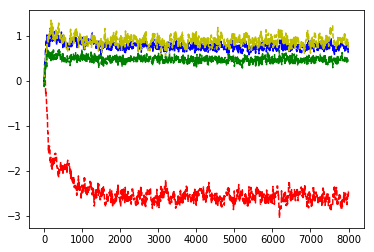

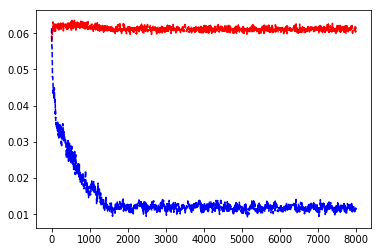

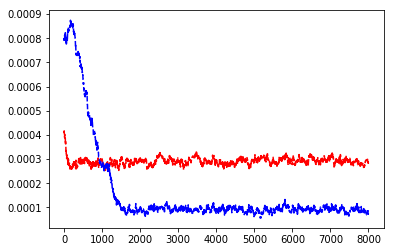

In [14]:
print('acceptance rate',chain1.shape, np.unique(chain1,axis=0).shape,np.unique(chain1,axis=0).shape[0]*100/chain1.shape[0])
print('acceptance rate',chain2.shape, np.unique(chain2,axis=0).shape,np.unique(chain2,axis=0).shape[0]*100/chain2.shape[0])

chain11 = pd.DataFrame(chain1, columns=['w0','w1','w2','w3'])
chain11['iteration'] = chain11.index
plt.plot(chain11.iteration,chain11.w0,'r--',
         chain11.iteration,chain11.w1,'b--',
         chain11.iteration,chain11.w2,'y--',
         chain11.iteration,chain11.w3,'g--')
plt.show()

chain22 = pd.DataFrame(chain2, columns=['mu0','mu1','var0','var1'])
chain22['iteration'] = chain22.index
plt.plot(chain22.iteration,chain22.mu0,'r--',
         chain22.iteration,chain22.mu1,'b--')
plt.show()
plt.plot(chain22.iteration,chain22.var0,'r--',
         chain22.iteration,chain22.var1,'b--')
plt.show()

In [25]:
print('last iteration T=1 elements',Tnew.sum())

Tmatrix = Tmatrix[int(Tmatrix.shape[0]*0.25):Tmatrix.shape[0]]
tprob = Tmatrix.sum(axis=0)/Tmatrix.shape[0]
#tfinal = np.random.binomial(1,tprob,len(tprob))
print(tprob.mean())
tfinal = tprob
#tfinal[tprob>0.6] = 0
#tfinal[tprob<0.6] = 1
tfinal = np.random.binomial(1,tprob,len(tprob))

gd = data[tfinal==1]
gp = data[tfinal==0]
print('driver genes size - final',gd['gscore'].shape[0])
print('passenger genes size - final',gp['gscore'].shape[0])




last iteration T=1 elements 225
0.159667852045
driver genes size - final 239
passenger genes size - final 1230


In [26]:
maximum = list(set(data.gene.tolist()).intersection(evaluation))

gene = gd.gene.tolist()
driver = list(set(gene).intersection(maximum))
print('Proportion of Driver from other lists (Recall): ', len(driver)*100/len(maximum),'%(',len(driver),'/',len(maximum),')')
print('Proportion of Driver Genes on Data: ',len(gene)*100/data.shape[0],'%(',len(gene),')')
print('Proportion of Driver Genes on other lists (Precision):',len(driver)*100/len(gene),'%')
#driver

Proportion of Driver from other lists (Recall):  63.63636363636363 %( 21 / 33 )
Proportion of Driver Genes on Data:  16.269571136827775 %( 239 )
Proportion of Driver Genes on other lists (Precision): 8.786610878661088 %


In [17]:
#gene = gp.gene.tolist()
#driver = list(set(gene).intersection(maximum))
#print('Proportion of Driver from other lists (Recall): ', len(driver)*100/len(maximum),'%(',len(driver),'/',len(maximum),')')
#print('Proportion of Driver Genes on Data: ',len(gene)*100/data.shape[0],'%(',len(gene),')')
#print('Proportion of Driver Genes on other lists (Precision):',len(driver)*100/len(gene),'%')
#driver

In [27]:
pd.options.display.max_rows = 4000
gene

['FOXA1',
 'ARFGEF1',
 'CLINT1',
 'GTPBP10',
 'MRPL15',
 'ETF1',
 'ISCU',
 'CA8',
 'MDM4',
 'MKRN1',
 'FAM181B',
 'SPOP',
 'TBX3',
 'WDR34',
 'SET',
 'BRAF',
 'PSMC5',
 'SLC45A3',
 'RPL12',
 'EZH2',
 'RBM19',
 'BCL6',
 'PRKAR1A',
 'APLP2',
 'SNX13',
 'PSMD12',
 'HSP90AA1',
 'RPS2',
 'HSPA8',
 'HOXB13',
 'TAF1D',
 'MYOT',
 'ZFR',
 'RCOR1',
 'PAX5',
 'MYL12B',
 'KRT18',
 'BCOR',
 'ATP6V1C2',
 'BTRC',
 'CSNK1A1',
 'RPS14',
 'CD74',
 'RPL37',
 'HOXC6',
 'RPL41',
 'MYL6',
 'RPL7A',
 'PDLIM5',
 'MFGE8',
 'RCCD1',
 'MAPRE1',
 'GABPA',
 'ZNF827',
 'UBB',
 'HNRNPL',
 'UBN1',
 'PCDH18',
 'SOX11',
 'ACTB',
 'RPS16',
 'TAPT1',
 'BZW1',
 'DES',
 'MED14',
 'TAGLN',
 'KIN',
 'USP7',
 'IFI16',
 'ZNF485',
 'AAMP',
 'COPA',
 'RNF181',
 'TMPRSS11D',
 'RPL37A',
 'NFIB',
 'NOL7',
 'PIKFYVE',
 'EIF6',
 'B2M',
 'SMG7',
 'FARP1',
 'HSP90AB1',
 'CYP2C8',
 'GAPDH',
 'ETV3',
 'HIC1',
 'TMPRSS2',
 'RPL31',
 'KLK2',
 'KLK3',
 'KLK4',
 'PPIB',
 'H2AFV',
 'PSAP',
 'TAF1L',
 'RAG1',
 'AHNAK',
 'FTH1',
 'MYH9',
 'GIGY

In [19]:
top100 = data
top100['prob'] = tprob
top100 = top100.sort_values("prob", axis=0, ascending=False)
genes100 = top100['gene'].head(100)
list(genes100)

['CSRNP1',
 'HSPA8',
 'ZFP36L2',
 'CDK12',
 'SPOP',
 'AAMP',
 'CTNNB1',
 'RPL10A',
 'PTEN',
 'CDKN1B',
 'TBXA2R',
 'SMARCA4',
 'SMG7',
 'MFGE8',
 'ESCO1',
 'KDM1A',
 'SMARCA1',
 'NKX3-1',
 'IL6ST',
 'EMG1',
 'GATA6',
 'RPL11',
 'TP53',
 'MAP2K7',
 'RPS27A',
 'RYBP',
 'XRCC6',
 'CASZ1',
 'TMPRSS2',
 'ELOVL6',
 'FBN1',
 'CLDN23',
 'HTR1E',
 'RPLP1',
 'AADACL4',
 'CRTC1',
 'SUZ12',
 'BCLAF1',
 'TIMM22',
 'TCTA',
 'NAA38',
 'SGIP1',
 'TOMM40',
 'BZW1',
 'EIF4A1',
 'RPL5',
 'CLEC1A',
 'KCNA3',
 'PIKFYVE',
 'MAPRE1',
 'NFIX',
 'HIC1',
 'ADSL',
 'ERF',
 'GMPR',
 'ETV3',
 'CSDC2',
 'KATNB1',
 'MORN4',
 'EPB41L3',
 'SHROOM4',
 'VHL',
 'COL11A1',
 'ERCC2',
 'SSB',
 'ZFP36L1',
 'DDX47',
 'RPL19',
 'BCAM',
 'CASP8AP2',
 'HOXB13',
 'ARID1A',
 'ATP1A1',
 'PNO1',
 'GIGYF2',
 'TPT1',
 'RPL3',
 'ALDOA',
 'MTCH2',
 'MRPS15',
 'DCTN1',
 'PTCD3',
 'KLK2',
 'CXCR4',
 'TXNDC17',
 'DNASE2B',
 'EBNA1BP2',
 'CXXC1',
 'GOLM1',
 'RAG1',
 'B2M',
 'CD81',
 'TAF1L',
 'KLK3',
 'RPS11',
 'CPLX4',
 'TAF1D',
 'CALR',
 

In [20]:
driver = list(set(genes100).intersection(maximum))
print('Proportion of Driver from other lists (Recall): ', len(driver)*100/len(maximum),'%(',len(driver),'/',len(maximum),')')
print('Proportion of Driver Genes on Data: ',len(genes100)*100/data.shape[0],'%(',len(genes100),')')
print('Proportion of Driver Genes on other lists (Precision):',len(driver)*100/len(genes100),'%')
driver

Proportion of Driver from other lists (Recall):  36.36363636363637 %( 12 / 33 )
Proportion of Driver Genes on Data:  6.807351940095303 %( 100 )
Proportion of Driver Genes on other lists (Precision): 12.0 %


['CDKN1B',
 'KLK2',
 'CTNNB1',
 'TP53',
 'SPOP',
 'ERCC2',
 'NKX3-1',
 'PTEN',
 'BCLAF1',
 'HSPA8',
 'SMARCA1',
 'TMPRSS2']